<a href="https://colab.research.google.com/github/maniatisni/Stochastic-Labs/blob/main/lab10/Stochastics_Lab10_Random_Forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Νικόλαος Μανιάτης](mailto:nikolaosmaniatis@mail.ntua.gr)
## Α.Μ.: 03400097

<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/PDSH-cover-small.png?raw=1">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

<br>
<strong>Για το εργαστήριο του μαθήματος "<i>Στοχαστικές Διεργασίες & Βελτιστοποίηση στη Μηχανική Μάθηση</i>" έχουμε προσαρμόσει το κείμενο και τον κώδικα από το παραπάνω βιβλίο στις ανάγκες μας.</strong>

# Δέντρα Αποφάσεων (Decision Trees) και Random Forests

Τα Random Forests είναι ένα παράδειγμα ενός συνόλου τεχνικών μάθησης που βασίζεται σε δέντρα αποφάσεων. 

Τα δέντρα αποφάσεων αποτελούν έναν εξαιρετικά διαισθητικό τρόπο ταξινόμησης ή επισήμανσης αντικειμένων: απλώς υποβάλετε μια σειρά ερωτήσεων που έχουν σχεδιαστεί για να οδηγήσουν στην τελική ταξινόμηση. Για παράδειγμα, εάν θέλετε να δημιουργήσετε ένα δέντρο αποφάσεων για να ταξινομήσετε ένα ζώο που συναντάτε ενώ περπατάτε, μπορείτε να δημιουργήσετε αυτό που φαίνεται εδώ:

![alt text](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.08-decision-tree.png)

Ο δυαδικός διαχωρισμός είναι εξαιρετικά αποτελεσματικός: σε ένα καλά κατασκευασμένο δέντρο, κάθε ερώτηση θα μειώσει τον αριθμό των επιλογών κατά περίπου το ήμισυ, μειώνοντας πολύ γρήγορα τις επιλογές ακόμη και σε μεγάλο αριθμό τάξεων.

Το σημαντικό βέβαια σε αυτή τη προσέγγιση είναι να αποφασιστούν ποιες ερωτήσεις πρέπει να υποβληθούν σε κάθε βήμα. Στις εφαρμογές μηχανικής μάθησης των δένδρων αποφάσεων, οι ερωτήσεις γενικά έχουν τη μορφή διαχωρισμών άξονα στα δεδομένα: δηλαδή, κάθε κόμβος στο δέντρο χωρίζει τα δεδομένα σε δύο ομάδες χρησιμοποιώντας μια τιμή αποκοπής σε ένα από τα χαρακτηριστικά.

# Δημιουργία ενός Δέντρου Αποφάσεων


Έστω ότι έχουμε τα ακόλουθα δισδιάστατα δεδομένα, τα οποία είναι ταξινομημένα σε τέσσερις κλάσεις:

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

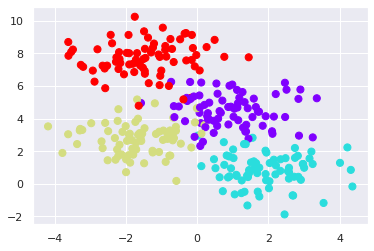

In [3]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

Ένα απλό δέντρο αποφάσεων που βασίζεται σε αυτά τα δεδομένα θα διαχωρίσει επαναληπτικά τα δεδομένα κατά μήκος του ενός ή του άλλου άξονα σύμφωνα με κάποιο ποσοτικό κριτήριο, και σε κάθε επίπεδο εκχωρεί την ετικέτα της νέας περιοχής σύμφωνα με την πλειοψηφία των σημείων μέσα σε αυτήν. Παρακάτω παρουσίαζεται μια απεικόνιση των πρώτων τεσσάρων επιπέδων ενός ταξινομητή δέντρων αποφάσεων για τα παραπάνω δεδομένα:

![alt text](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.08-decision-tree-levels.png)


Παρατηρούμε ότι μετά τον πρώτο διαχωρισμό, κάθε σημείο στον άνω κλάδο παραμένει αμετάβλητο, επομένως δεν χρειάζεται να υποδιαιρεθεί περαιτέρω αυτός ο κλάδος. Εκτός από τους κόμβους που περιέχουν ένα και μόνο χρώμα, σε κάθε επίπεδο κάθε περιοχή χωρίζεται ξανά σε ένα από τα δύο χαρακτηριστικά.


Αυτή η διαδικασία προσαρμογής ενός δέντρου αποφάσεων στα δεδομένα μας μπορεί να γίνει στο Scikit-Learn με τον εκτιμητή DecisionTreeClassifier:

In [4]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

Παρακάτω παρατίθεται μία συνάρτηση χρησιμότητας για να απεικονίσουμε την έξοδο του ταξινομητή:

In [5]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: The following kwargs were not used by contour: 'clim'


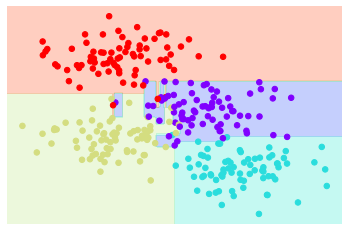

In [6]:
visualize_classifier(DecisionTreeClassifier(), X, y)

Παρακάτω παρατίθεται μία διαδραστική απεικόνιση της διαδικασίας δημιουργίας δέντρων αποφάσεων:

![alt text](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAd8AAAFRCAYAAAA1uqfwAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAIABJREFUeJzs3XdYVVe6+PHvPhXOofeOFUVFUBQsqIiCCsYWjcaYnsnk%0AZtq9d1qm3js9U+9vapKZTGJMNImJvVcUexcLCnaR3juctn9/kIBHQNqBg7g+z5PnCZt91noPwnn3%0A2nutd0myLMsIgiAIgtBrFPYOQBAEQRAeNyL5CoIgCEIvE8lXEARBEHqZSL6CIAiC0MtE8hUEQRCE%0AXiaSryAIgiD0MlVvdZRXc7C3uhIEQRAEu/PXT2vze2LkKwiCIAi9TCRfQRAEQehlIvkKgiAIQi8T%0AyVcQBEEQeplIvoIgCILQy0TyFQRBEIReJpKvIAiCIPQykXwFQRAEoZeJ5CsIgiAIvUwkX0EQBEHo%0AZb1WXlIQHlRbU0fa9g/RK+9itOjwDJ1B5PhYe4clCILQ40TyFexm//q/8sITWSiVEgCnLqzk6iUn%0Aho8aaefIBEEQepa47SzYRUlROWGB15oSL8D40SZysg7ZMSpBEITeIZKvYBdmixmlQm5xXJJaHhME%0AQehvRPIV7MLH15Mr2QOR5eZkezFTgXfoBDtGJQiC0Dsk+f5Pvx4k9vMVHlReWsGx3StxVmdjkvXo%0AfacxfkqCvcMSBEGwiYft5yuSryAIgiD0gIclX3HbWRAEQRB6mUi+giAIgtDLRPIVBEEQhF4mkq8g%0ACIIg9DKRfAVBEAShl4nkKwiCIAi9TCRfQRAEQehlIvkKgiAIQi8TuxoJwgMqK6o5fWgXFrORiJgE%0AfP197B2SIAj9jEi+gnCfOzducufsX1kyswqlEnYfPkRh7gtERI+3d2iCIPQj4razINwn6+xmlsyu%0ARqWSkCSJWVMMFN3cbu+wBEHoZ0TyFYT7OKrLWh5TltohEkEQ+jORfAXhPjUGHx7ca6Ta6GunaARB%0A6K9E8hUeKbIsc+7kGY7sP4jBYLR5+9HxS3lvvS+FxWaqayys2erK4DGLbd6PIAiPN7GloPDIqCir%0A5MDGP5ASl4OLE2w96E5w5MsMDQ+3aT8Wi4XTx05iqK8jZkocGo3apu0LgvB4EPv5Cv3Crs//ybNJ%0AJ5EkqenY6u0hzFz6EztGJQiC0LqHJV+x1Eh4ZDgqC60SL4BOlW+naGzPYrGQtnMD1KYjSWDWjGL6%0A3CUt3rMgCI8+kXyFR0aD2bWVY+52iMS2zGYze9a/T+71Q7y8TImPlxKAsoocdmyxMGPeMjtHKAiC%0ArYkJV4+50uIy9m/fQdaVzB5pv6SojLMnzlBdVdvttsLHz+fT7U6YTDKyLHPguAq3kNk2iNK+Urd8%0AwuKpxwgfbGhKvADurgrUxotW5xqNJs6fOkf27Xu9HaYgCDYkRr6PsWP7d+JYv5mnJhnIvCmx6cMR%0AzF3+TZRKZfsv7oC9m1YT4HiEcUPrOHnACYNuDpNmJHe5vaDQEFzcfsFnh3ZiMRkYPnYa4SGBNonV%0AnjSWa+h1bV0HW5r+7+qFdPKufEj8uBLu5ajYfCic5Ke/iUol/owF4VEj/mofU7U1daiqtzNruhGQ%0AGDEU/LwvkXpgP3EzErvd/tVLl4kKSmVkmASoSImvZ8+RrZQUTcTTu+u3il1cnUiY27+W/pjlxj9D%0ApRLKK8y4uTZe/FRWyzQoRgKNS6xyMj5leUoFoMLPB0YOvczGnZtImPukvUIXBKGLRPJ9TGVlZBI9%0Aoor7fwU83BQYq2/bpP2cm+lMm249UWjGRAOfHD7KjJQUm/TRX+i9J3Lt9h3mJurZsruG+nqZ6gY3%0ANB5xzJi/HIDCglIGBRQCzT9TR0cFStNdO0UtCEJ3iOT7mAodNJCM0474+zYXqqirsyBpbFPNycHJ%0Al7IKC+6uzbdTr1yH4EFDbNL+/cxmMycPH6K2Ihf/AaMZMXqUzfvoSTFTZ3DqsJIze04iKSyofEeT%0Akmh9e97N3ZlbJU5ATdMxWZZpsLj0crSCINiCmHD1mHL3dKWgIY5LmY3LvMsrLXywJZiJCbaZwBQ7%0AdRqf7gqhtrbxmWVJmYUjGaMICx9mk/a/ZDKZ2PTBb4gb8CHLp6fiZ/4zezassmkfvWF8XDzTn/we%0A8YveIC6x5XNxrVZDg8MUrt5o/Npslvl4mytjJs/r5UgFQbAFUWTjMXf1UgY5N8/j4ORD7NR4m07e%0AMRiMHNu/E9lQiNppABPjp6NQ2PZ679DunSSNWouLc/MksbSTStxH/hIfPy+b9vWg2tp6ThzYicVY%0ASdCQcQwbOaJDrzMaTRgNRnR6x073efHceYrvnsWMjvFTU3B1d+50G4Ig9A5R4Urot1I3r2TZ9CNW%0AxyqrzKRef5kJUyf3WL/lpRUc3fprlicXo9UquHBVIrMkmamzF7T5GlmW2bNhFS7SWRw0DeRVhBCd%0A8Ao+fj49FqetyLJMxoUMDA0NRI6LsvlFlCD0Rw9LvuIvSHikOboNoqDYbHXs2HlHho+K6NF+Tx3c%0AxAsLStBqG/+ERg+X0dSlUl/f0OZr0nZtJXlcGvNn1jJrqpkXnrjFmf3v9mictlBWUs6WD/6XUOUf%0AiXD/G7vX/JDs23fsHZYgPNJE8hUeaTFxcWw+EsXlrMbCG6nHVFQpk3Dz6NmJSGqprEXZx2DfKoqL%0Aytt8jaU2E0936z85f9e71NbU9UiMtnJy38e8siiHwaFKAv2UPD+/hIwTn9g7LEF4pInZzu24dvU6%0ApcXFjImJFrvb9EEKhYJ5K75J1pVM1qRdI3L8BEb49uyzXgCLKoj6+gs4ODQn02vZ3kyJbbtvs6xt%0AcayuQYu6j/9e6dV5LS40nFR5dopGEPoHMfJtQ0ODgU0r38S1+k0mB/+TYxu/z5X08/YOS2hDWPgw%0AZs6di3cvJF6AKbPm88G2YVzKlKmqtrB+lx73QYseWh0sJHwGR85omr4uKZOpYixqdd++Bq43tbyL%0A0GB2s0MkgtB/iAlXbdi76ROWxO1Fo2m+4l+zzYeEpb/sd7vMyLJM+qmzlORn4uY9iLETYvvde7RY%0ALNTXG9DpHGza7rUr1yjKzyMqNqZDbWdlZHD3yj6UUgMK3TCmzprb53/W169epSzr76TE1yFJEodO%0AqajVP0tU7CR7hyYIfZqY7dwFBzf+kadmXLU6dugUeI7+PZ5e/euqf+uafzAj6iwDgiVy8i1sPTqS%0A+c/9V59PCh11ZO9WTGUHcNVVUVztz4DIZQwZPtzeYT1SigqKSD+2GzATFhlPyMAQe4ckCH2e2M+3%0ACwwWV2RZtkpAhWUuDHJzsmNUtpeVcZUJwxoTL0Cgn4I5sRmknzxNVOx4O0fXfRkXLjLUbTMRsV9e%0AY+awesv7DBz6a5ttIPE48Pb1ZuaCZ+wdhiD0G+KZbxuiJs9nzVY3TKbGD+30K4CLbYtQ9AXZNzO/%0A2PygWUigRGnhLTtFZFt5N08RMcz65s7U6EIunb9sp4gEQRDEyLdN3r7exM79GWsPbAe5lqAhMcTF%0AhNs7LJsbOnIMpy5sZ/zo5q3rrlwH/wEj7RiV7VhkLRaLjELRfIFRXKbCzadjjw5qa+s5tnczCrkU%0ASRvMlMTZYsQsCEK3iZHvQzi76Jkxbwkz5j/PsJH9L/EChAwMIatoCsfPKZBlmTMXJU5ciyU8on8k%0A37FxyWzY01yC0WiUOZU5hNBB7T+zNBiM7Pn0VyyJ282yhDPMGb2Orav/X0+G2+saGgzk5xXTS1M/%0ABEH4gphwJQBw724OVy+cY+iICEIHhdo7HJvJyc7lxP6NFOdew9vHFb37UKalLEGr1bT72rRdO5gT%0A+TlO+uZr1MtZMqW679p8gwh7OLhjHdr6NPy9qrmR64Nv2BJGjhlr77AEod8QE66EdgWFBBIUEmjv%0AMGwq4/xZzPn/5rWFjSUf9x01oPSb16HEC2CoL7FKvABDB8D6U3fsmnzPHD1IZd5RlJIRo2o40+cu%0A7nSt5cvpFxjlu5MRQwEUxEQVs3bHRxhGRohiMoLQC8RtZ+GRU5hfyK51/yZ1w184uHMrFoul1fPy%0Ar+9k5mQDkiQhSRIzJxvIv76rw/0EDR7DpUzrY3uOOhA90Xp9q8FgJG3XDvZv+oDzJ0/36C3cs8cO%0AMdBxNcuSbrIkMZuUcbvYs+GDTrdTcPvsF4m3WUJMORfOiEIygtAbxMi3C8pKyjl1cBMaRQWyJoQp%0ASXN7dRa02Wxm74YP0HEJBWYqjGEkLHwFB4eW5Qv7m5LCUq6kvcmzsyuRJInyynTWr80mZdl/tDhX%0Aq6xocUyjaLv28oOGjxpJ6taZZOenMXxgDeeuuqPxeQIX1+blZg0NBnas/hUrUu6h1ym4lZ3G7nWT%0AmbX4pa69wXZU5B4nPKk5ubs6K9DJFzvdjizpMJlkVKrmiWjZ+Uq8fPr+DkuC0B+IkW8nVVfVcnz7%0Ar1kx8xBLZ1zkiegtbPv4L70aQ+rWtSyKO8LiWVUsmlXLilnnSN38fq/GYC9nj2xlyReJF8DNRcFg%0Ar/OUtLKhQbXBv8WxGmPLY22RZRmTsYHqGpljZ02UVTvg7h1gdc7x1J08N7cx8QIMDFYw0OMkhfnF%0AnXlbHSZJphbHFJg6PdqOiU/hk+3uTa+rq7NwKms4Awb3n+f9gtCXiZFvJ508sJ1nUkqbPvz1OgXR%0Ag69w5+bdDs2gtQWNOdPqWaRaLeGkuN4rfdubSqptUXnL37uBguISPL2tlw9FTX2a99b/lYTxjZsA%0A7D/lz/hZyzvc14m0gyREpBHgKwGOQDEfbVnF4GG/aorB0lCMo6P1NeyIwQaO3riOj5/t60wr9BEU%0AldzA27Oxf7NZpsI4pNPVyJxd9IxNfIOP9m5Gq6jArAom+en5No9XEITWieTbSVXl+ajV1h90oQFm%0AjuXk9VrytdByQoxFfjwmyei9RnIv7zRB/s3/BqcyfElYOrDFub7+viQ/9wsunb8EQPJzozqVpOrK%0AMggYa31+5NA8bt/MYeDgIAB0HkPILzqCn3dzAj6WrmdkwuhOva+OmpKUwp4t1agazqKUjFQaBxE/%0A/ytdasvTx5OkRS/aOEJBEDpCJN8Oqq6sYf+GP+MkZXDlmoLwoc3PV1NPuRI7b0yvxeLoGcu127cZ%0AOqDx64JiGYtjzy4Rqatr4ODWD9Arb2O0OODsO4XxU6b3aJ+tiYmbwt5Nd3DLPIGfRw1X7/oRMnq5%0A1Wxfs9nMibSDNFTn4u4zjMiYcV2qU220OLYoMVpU6kDgEFereLZ/cpmI4HOMGGrmwElHLC5PoHfS%0Ade+NtkGSJGbMWwYs65H2BUHoHWKdbwft/Oxtnk06jUIhsW1vDSAT4KshM9sPryGLiYju3TrIpw6n%0AUlN4EgkLCqcI4hJTenQjhK2r/8TzyRlNE3Qyrklkm14mKibW6jyLxcK+TWvQmhtHm7UMR+fij7G+%0AjNBh4xgybEibfZw5dozKgguYZD1j41Lw9HZv89zamjrKyqoICPS2et8Wi4WNK9/kqZk38HRXcOee%0AzL708aQs+2qn33NBXgE3jv2GhYk1AJRVWNh4JIbkpS3bunvrLtm3bhIRPc5qQpYgCI8vsauRDRze%0A8GOenFnQ9HVtrYUPNjiy4NW/dHqN5aOmtqaOzAPfZvZUo9Xxj/eMImHRt6yO7dv8CSnj9uDq3Pgz%0Aqa6xsHV3NcsWunDmItysTGbq7IUt+ti3eQ2Th+4nNEjCYpH5bKcLI6a9gY9f52bfHjt4gLgBH+Ll%0A0fxvcuYimHx/xIDBAzrVFkDuvVwun9yOWlGDwnEIcYlz+v2/tyAItiGKbNiAwewENCdfnU6Bu6fn%0AY/RB3LFrNLXxclPiBXDSK3BwaPw6OgLyUlOprZmNTu/YdE5tbT0uHCc0qHEEq1BIPDWnktX7tpK4%0AsHNLdmor7lklXoCoETKfHrnSIvmWl1Zw8sBmNMoK0IQyJSm5Rd3mgKAAAoJe6VQMgiAI7RHJt4N8%0ABydx+PS7xI1rHP2dvazAJTDBzlH1Dp3ekZzyIZjNV1AqGxPk1RsK3ANiWpwr0/LW9/33VoaFVpCT%0AXcDQ4QOajpWXVeLrUcP9K98kSUItVXU6Vq+AEdzKTmVgcHNbaSfVjB5n/VigprqWY9t+xXPzSlEo%0AJKqqz/HJxzeZt+JbDzbZ55UUlXF6/4fo1fcwWFzwCJlBVMxEe4clCMJDiOT7EDcys7h5YROOyhLq%0AzD44+axgzb4rgIWgoZOJHjnC3iH2moQFr/Phtg9wUt7CZHFE5xNH7LSWH/CyYxSFxbn4eDUm4eIS%0AE/fXH7l43ZNxc63XyvoHeLMvzZfxkUVNxyqrZdAO6nSco6PHsGNtLMVlZxgzwsyhU2qKzImM8LVe%0A9nPiiyVjX+525OykYOygS9y9lU3IwOBO92tPx3b8hZcWZH/x7LuM4+dWcSPTi8HDhrb7WkEQ7EMk%0A3zZUVdaQe+EfrJhd88WREj7clMf0pb9BrX78fmw6vSNznnqt3fOmzVlI6k4JqTYd2SJzKaOU5xcp%0AMJtldh/WovZOaVFbWZIkgiOWs2brKmIjCskt1JKVH0HyspROxylJEslLX+XurbusO3GVUWOjGeHj%0A2eI82VzVtGRMlmUuZxqoqjRTJee0SL6yLHM0dR/GqkwMZh1Rk1I6/Sy6p9y8dpuY8DtIUvPt8glj%0ATKzee9Duybe2tp6TafuRJInYaQmPRQU2QegoMeGqDfu3bWTxxK1Wa3qrayzsuvwMcTMej9vNJUWl%0AnDm0BbWiCpVuKHGJSV2aUX3p/EUKcu4SPXEKbh4ubZ5nNpvJzLiOl7dnjxSouF/66bMMUP8DL3cL%0AW/fUMHGcA0qlxIEzAYyd+Q38A5srYe1a9z6zxh7G16tx28X1u50ZOvkNfP19ezTGjrh1/S660p8x%0AOtz6OffqvROYufBlO0UFN7OyuHvubRbMqMBigQ373Bga+3VCBrVcj91TSovLOHVwPY6KUuplbybO%0AWIyzmIku9CIx4aoLGtd3Wh+TJNos4t/flBaXcX7vr1iRUoEkSZSWn2PT2tutLrNpz6ioCEZFRbR7%0AnlKpZERE+7sFWSwW9m/5FK35MrIsYXaIJD75yU5dGESOG0vq1kRy9mzmv191bnrtoNAiVm1fjf/S%0A7wCN5UR9HE7j69WY3CRJYlFSFR/t3UbSop6p39wZA4eEsGVVKBHD7za9hyNnVAwa1ftrsO93M30D%0AzyRX8eVz/OVzK1m9cz0hg77dK/0bDEaObv0tLy0qRpIkLJZM/rXuBvNe+NljNElS6MtE8m3DuMkz%0A2bL/AAuTapuObdznztTFbV/J9CdnD2/j6eSKpg90DzcFAz3OcSn9CkW5dxgRNRZf/96/9Xrvbi4H%0At6/l5XkXm2ZVF5Xksn+HgvjkRZ1qa/rcpaTVn0eSrOswO6nzmv6/rLQCP886oPm2riRJqBU19BVx%0AKd9k1Y6PcFLfw2BxxmtAIqOHdv55uS05KFvWtnZU9Uy969acOLifpbOLkKTG3xGFQmLh9ByOHzlG%0A7JTJvRaHILRFJN82uLo74zXiq3y8azMaRSn1Zh+Gxi56bPY6VVLTNBnpS0G+dZw8/yZPPaHm2LmN%0AXDoV/0W1pe4xm82cOHSIuspCBo+MaXU9rsFgZOenfyZyQCYB+kpcnZtvX3t7KpDq0oHOJV8AE+6A%0AdVJoMDdXsAoK8WPfUX+iRhY2HSsutaDWh3W6L1sxm81WS6LcPd2YvfTrdounNfVmL6C8lWO9o6G2%0AEr3O+vfXw01BdUZpr8UgCA8jku9DhIWPICz88ZnRfD+dZzg5+ScJ9LuvZvHpBpYvckKplJgy3syJ%0A8/vJvj2Z4AFdnx1cX9/AjtW/YUliNp7uCk6c38uh68lMmbXA6ryD29fx3JwraLUKcvNsd9swcHgy%0Auw69TVJcPZIkcfi0Co/QxKbvS5JEaNQKPtyyisgheeSX6MirHsusxUk2i+FB2bfvkZdzj4ixY3B0%0AbJ6klHX5EtmX16FX5VNncsclMInoyfE9Fkd3DBy9kLU7/sGCGdVYLDIb9rkyZHzL4io9JSJmGvuP%0A7mfG5OZdoHakOTI+3r634wXhSyL5Cq2KiZvCng238Ll2kkCfGo6c1jBxjKZpnS9ATKSFNQdPdyv5%0AHt2zhZcW3EOjaUyosVEyxQf2UVOdZFUfWSPfRattPEeWoaragrNT49fFpTIWh/afKbdm2KhR5Lr9%0AiDX79wIWhkRMI+qBkffQ8HCGDP81d2/nMXCYC5E9NGnHYrGw7eO/ERl6kckhZg5sc0Ef/BRRsZNo%0AaDCQc+k9lid/ufa5iEOnPiH79uBu/fx7yuBhYfgH/YYNaftAkpgwbwY6nUOv9e/r78O9W8v4dMd2%0AvF3LKKzwwn3AE6L0p9BniOQrtEqSJKLjnuBoqiP3ap0IinDHw/1dq3OybkLggO7dfpUshWg01rcH%0AwwdWkX0nl+Ejm+tAG8zNt5nnz9azeVcNZRVK9O6hWByiiE95sssxBAT5ExD07MPjlCRCBwY89Bxo%0AnKjX0GBAq9V0emb44T27WByfjpuLAlCyaFYNn+1ch3FsDKePHCNlagX3FyKJG2diTeohggd0fJvE%0A3qTTOxI/Z67d+o+eNA2LZQo11XWMcNb1aO1zQegskXyFVp1M24u2Zj0vzTaQXwSbDoZwMyOMp2Zm%0A4eulICffwsGLkcx/dmT3OlIHUlt7Bp2uOalcvOZK5Gzr0Vx4zFzW777KwsRqFAqJYUOdyCiaS1xS%0A39mD9kr6eXKvrsddV0hlvTtO/kmMi+v4bU5z3a0vEm+zqLBibl2/i5OrK2UV4HzfwM1kAoVSrJ19%0AGIVCgbOL3t5hCEILYs690ILBYMRQtIOkOCMKhUSAr8TLC+7i7hPKgWtL+eVbHmw+4IfO2ZPamrpu%0A9RWXmMKqbUO4c0/GYpHZe0QFbsnU1dRxKf0KBkNjOc+gkCCGTfkJa/bH8/H+WHLk1/tU4q2trac4%0AayXLk/OYE29m6exinBvWkpOd2+E2TLIbZrP1svubOc74BfgwemwkO44GY7E0f//z3S6MnzrbZu9B%0AEITeI4psCC3cuZWLY/GPiBhufWPk030RlJcW88qiXJRKCZNJ5t31Qcx/8aedWjtZVlLO6bStqKQq%0AtK7DmDAtnovn0inOyyYyZjJnDm0myOkkQ0LqOHnZA+fgxUTFTrL127SpA7t2M3/sp02bSEDjLeg1%0AqTOZOb9jM8KrKqpJ2/gLVswtQaORuHFH5viN6cyc/0zT94/u/RRHRQEGixvhMfMIDA7qkfcjCEL3%0AiSIbdvbl9c2j8szJL8CLM+fciBhe3XTMZJK5eaeGry7KQalsTDAqlcSihLucOHqMmLjW105WVVRz%0A4sAWlFSg1g0kPGo8Z3f/huVzy1AoJAqKT7Nz3U1mL3kFGMPpo0eZPuowwQEKQE1IUBXrdn1GQ9S4%0AFmUp+xJnF3dKyiHQr/mYwSCj0ujaftGDbbg6MX3x/7L+wA5kUwWeAaOZOT/a6vuznrRf1SpBEGxH%0AJN8eVF/fwP4N7+KiysSCglpGkbjoxRbb1vU1Wq0GyS2Jw6c3MTnaRFmFzGd7AvENGIi76w2rc708%0AFFReKmy1ndqaOtI2/oLn55egVEqUlp/iL+/s4KffqG5aQ+zrpSDY5QylJUvw8HSlqugKwRHNo0eT%0ASSYmoozL6ZcYEzO25950N42dMI7NK4N4ZVFO03tbu9OduEWdW5Kk0zsyPaXz65UFQXi0iOTbg1I3%0Av8+KWeea6kPX1h5j/WZHEhc+02N9fll6UW26ggUVDu4xTEyY3XghsOk9XFTXMVtUmB3GMn3uU22O%0AxicmzCEnO5I1qUfQuXrzxPNTKC4s4cDxg0yf2Lx2cu9RDVGxU1tt4/j+bayYW9K0PMnDTUGgVwEK%0AhfVyj5CAOnILivDwdEVWuGI0yiiVsG5bNRq1hMUikVu1jUFDh+Dq3nZtaHuSJImERd/loz1rcVQW%0AUmd2I2rGwl5dXiMIwqNDJN8e5KS8YbUxg06nwFR9noyLYwkfNbxHbkPv2fABiyYfxknfOHq8nZ3N%0AsVQl5QVZrEhqvhAoLN7Dwd06ps56os22AoMDCAxe0vS1r78Pd7IWsW73TkL9yrmd546DbzJerewa%0ABCBZKlssI/J2l8kvMuPn3Tz6P53hzdTFjQX3Y6cn8+G603g43mH2dH3TWl5ZvsPKbe+S/PR/d+Gn%0A0jucXZ2Ytbj36j0X5BVwPu1j9Op8GsyuBITNITwyqtf6FwSh60Ty7UEWuWUpSqUpmxDp9+z4MJBx%0ASd+w+dZ0OvlSU+IFGBAMx6+cxllZYHUh4OMlYTl3EWg7+bYmZloiRuN0igpLmRjrgUrV9q+Qm+8o%0AbmcfZUBwc79GyZdtJ0cy0P0cwf51nLnijU/Y00234vVOOqYt+im7Vn8PZ6eGptdJkoSr+hYlReW4%0AeTj3+Vv3PU2WZU7v/gsvLfryln8Juw//izyvn+B//4NnQRD6JJF8e5CsiyavcAf+Po3J5/otA8EB%0ASgaHKhkcms+q7R8xa6mNR3Jyy12XJMmCpZVVZbLctQSmVqsICGz/omHMhBj2bLhK1p3jDAmu5cwV%0AT1wGPMnUmEmUllSQV1DE1MUDWyRSJ2cdbl6hQJbV8cryUsoufZfLJe7o/OZ0ag1tf3PhbDozY/O4%0Af8OHxMkNrN63F/+FK+wXmCAIHSKSbw+KT36SI3t1GNPTKc65wujhZuInNc9+1avzbd5ntTwMg+F0%0A0+3egiITt6/fxGhSUTnZgssXOwFduw1OvjGdajv3XiEWs5mgUP/2T/5C4sLnqChfSHZOPhMXDESt%0AbvyV8/B0xcPTtc3XeYVO5VzGDcaMMAOQX2jCw83C5HEAZew9spbC/Ige3/e3z2pjgeAjMqFeEB57%0AYp1vL9n/+Zs8Pct6pvDHu0JJWPxjm/ZjMBjZt/F99IprlBUVEOBrJGWmHlmGv71fh7t3CGoHJ3Re%0AE4idNqNDbVZX1rB/w5+JHHQTldLC2esDmDTn63h6e9g09gddPHOaotuHKC64y7DgAhKnNZcIlGWZ%0Ajw/OYcYTXS8r+SiTZZkdH/6YFxc2zzTfc0SD16gfExDU8YsjQRB6zsPW+Yrk20uupJ/HnP8vEiY2%0AIEkSaSfJoo65AAAgAElEQVTVGNxeICK6c6PPjsrMyMLP+FvCBlnfbl69bzIzF7zQqbZ2rH2b52ad%0AblpCI8syq7aPYvay/7RVuA914tAhJgavxNuz+b2UVVhIzXqGyQkJvRJDX5Sfm0f6oS8nXLnhP3Q2%0AI6Kal2NVVdZQX9eAt2/PXiQJgtA6UWSjDwiPjOKe2w9Ys38/smwhLDKBYYNCHvqa6soa0ra9i4v6%0AFmZZg8VxHPEpSzo0S1qSFFalCLvDWX3Pam9fSZJw1tyzSdsdMX7yZNav3MNXnsxFoZCoqjbzh3+q%0AGDG+jIqyKlzdnbvdh8ViYd+mj9CYLqDATJVpCAkLX8HBoe/WTvYL8MevlTkDZrOZnZ+9Q6DLJZwc%0ADZzZG8zoaV8hIKj9jSEEQegdIvn2oqDQIIJCn+vw+Wnb3uH55IwvEl8N+UW7ObLXmbjEOe2+dujw%0AwWxdFcywwTlNyTr1uIawyM6PFA3mloXpDebe25pNoVAwc/H3Wb13HZUlN3CUsvmfb1lQKHawZf9B%0AvIa/StjIUd3q48C2dcyNOdi0sYHReI6PNr1H8tL/sMVb6FUHtq1n6fQz6HUKQGIy9/hgy0oClv/Q%0A3qEJgvAFsbFCH2UymfBwuGE14vTzljBVXezQ6yVJYlLyt1i1YzSf7/Zkzc6ByF4vEzLw4aPt1ngP%0AnMmxc83Lps5lKHAJ7N5MY1mW2b9lLQc//xFpn/+AXes+wGw2t3m+k4uepEXP4ebmwktLlWg0EiqV%0AxMKkOrIzNncrFgCV8YrVjkJqtYSL6nq327UHlenmF4m3mac+m4YGg50iEgThQWLk20cpFArM5pZL%0AgSydWB7k6e3B7KXf7HYsEdHjuZHpxpp9B0E2Ezg0juhR3dtK8MD2DSSO3o2XR+PFRU1tGus3QdKi%0A5x/6OgdVactjypbHOssst/xTMFsezbXERtmxxbF6o2PTTHNBEOxP/DX2UQqFgip5NDW1x5pGMZcy%0AFXgEtb6BQU8bPGwog4cNtVl7ivoLTYkXQK9T4GC53O7r6kxegHUt6Tqzd7fj0XnFcu32LYYOaPy6%0ApEzGqHk0q0WFjkgk9XgW0yc0Fim5lydjcpjQqZ2nBEHoWSL59mGJi15k41YnNOYszLIWt8A4xkyY%0AYO+wWijIyyf96GYclBU0yAFMmbO43YlKstzapLH2k4PPoOn87f1TvPCUI0oFfLalhnrH7ld0ip02%0Ag5NpEmevnQRMSLpRzJjXd/YL7oyh4eHcUv0Xa/bsRaIBvddops+Nt3dYgiDcRyTfPkypVHZ4L1h7%0AqSyv4tKB3/Ps3EoAjMZM3v/kLvNf+MFDX6dwHkN+UTZ+3o1JuKLKgkHV/qSpgtsnefUZHWnH6zCb%0AZZ6ap2fLwctYLJZuj+xipiYA/WPp0sChgxk4dLC9wxAEoQ0i+QrdciptB0/NrgAak6haLREXcYOs%0AK1mEhYe1+bopSU9waLcF+dw5JCwY1SNJmPdUu/05KCrQaCRmTm2uFObhVE5tTT1Ozh3fO/d+sixz%0AeM8uTLXXMZj1jI2bi7dv929lC4IgtEUkX6FbZEsdKpX1LWRfLwvXsx8+CUqSJKbOWgAs6FR/9bIf%0AJlOmVZ8FFb6MdGo5yaijdn72L56YcAJPdwWyLPPZzouMjP8hXj6PaelKQRB6nJiBIXRLyLAJnLts%0AnXz3HHdjTEx0j/Q3Zc5TvLdxANduyVRUmvl0uzOB4Yu7vD1jWWklIa7n8HRv/FOQJIklsys5e3ib%0ALcMWBEGwIka+QreEhQ/j6L4FXNu5Hy+XSvLKfAga+RQaTcvtFG3B0VHL/Bd/zJWLGVy6VsLEBbFo%0AtZout1daXIafVx3QHK8kSagVNTaIVhAEoXUi+QrdNmlGMmbzLGqq6xjhou/yKLQzwiNG2KSdgUOC%0A2f+pHyPCSpqO5RXKOLgNt0n7giAIrRHJV7AJpVKJi2vvlZy0FYVCQcjoFazeuppRg/LJK9ZR1DCe%0AxIWP717BgiD0PLGrkSDQOOM5+04+Hp6uXZ41LQiCcD+xq5EgtEOSJEIGiH1wBUHoHSL5PiLMZjMn%0ADh2ivqaK6EnxNtlGT7ANg8GIyWhCp+/6cidBEB4vIvk+AspKyjm06XcsTirAWS+xI2032oAVRI6P%0AtXdojzVZlvnLj9dyZvNtjNVmgqPd+M//W0JAsG0LdJw7dpW1/3eQkrvVeA924dk3EhkeMaDDr6+p%0ArqW8vJqAQO9emQwnCEL7xDPfR8Dude+yIvG41QfnJzt8iV/yC/Fhep/C/GLu3blD+OhRODo+vLa0%0ALax5axdbv5+BSm5epuQ3W8HvPnvdZn2Ul1XxrWl/R77VPJlNM6qOvx/4VrtLrGRZ5s8/+pTTn9+m%0AodSC7xgdr/32CUaNFWUnHwU11bW8/fON3LtYhrO3Awtem8zYSWIW/qPkYc98ey35Bod2v/j942p+%0Akpm//MLd6tjqddX84LdmkXxpTDIjhhj5xks6xkdp+GRjLSs/M1FS3rM3dtRFLgyuj7Q6li/dJdfn%0AWof/XWoqawHQu7Q+yUuqVhFZNcWqPbNsIt01Dam9eWG1CkZUxKKVmm+HX1ddpNKzkNqquof22xaL%0ASUZbo0dr1lGvrMbgVItCKWr19ASHUheGN0Q3/dvnS9nkeGahUIm/+UdFcW5Jm98Tt50fATdvW5Bl%0A2eoDOOOaiS/rKT/unHUm3vmdK6FBjSPQb77iAlTyh3dkJEXP/YyMkrHlMYzIRjV0MPka6ho3uNc5%0AurZ+gkVCRka6799aRkY2q8D48D4c6/VWiRfAyxhAWUNJ+/22QpZl3Mo9GWwZ2fR1liGdatfKbl8E%0AWswWMAIqUKhEMjebzPg3DLD6ufrJwRRV5WJ0MtgxMsFWxG3nR0BJUSnHtv2Op2YVoddJ7D6sRfJ6%0AhqjYSfYOrU9I3fRvliUctzpWWGzidMHXiJ4wrt3X37uTw9XzaSjVOmKnJXV44tRnuw7x3pKdeMuN%0As6RNkpGRS4ex4tUXOxz7wmUzANjwyb5Wv19TU82vXvsZyhyHpmPSEBM//cfPUakeXkVs5d//xY11%0Ad62OGb1q+cnKn7PipXkP7bc12zdt5vD/O4ZSar5mN0oG5v1vCpOmTO1wOy3a3bCZtDUHURRrMDsb%0AGJ4Uxgtfe/Wxvqtz40YWb/3H2zia9FbHBy0K5sWvv2qnqITOmhDf9mMCMfJ9BHh6ezDrmV+y+2Aq%0ADfXVRMVMw9PHw95h9Rmy0o2GBgtabfOIKeu2lqDhoe2+9vThVJwbPmX5dBMGg8xnGw8zOuE7+Pr7%0Atvmaxpnnh6mvyuGOaxZFtbnET5jJ4DFDmDPvCZu8py/p9U688OOX2fHxVirzK3ELdGP+c4vaTbwA%0ASQvm8Pfjf0GR0/j82yQZCY8fjl6nb+eVraurrkWB0uqY0qKiory8022dOHKEC8fSMWHk5pFbOFQ4%0AgwTKahVXN1/n9PgTjI/te3tX95ZBg4biFu5Mw0VL0zGjvp6Y+Mf3Z9LfiOT7iFCrVcTNTLR3GH3S%0AhIQUPvz0LM8+kY9WqyC3QOZ60VjmTH/4rGNZlqnO3U3KHDMgodVKrJhXzkd7NpG4qPXRRUlhCce2%0A/5GFMwpIHgXSNxX8fWUl3/jf/+6Bd9YobNhwwv638xNtAgKD+Nqb32T3xh3UV9UzKGIQicnJXY4j%0ALjGeUxtOoS5tfk4sBxiYNnNGp9rZ/Nl6jv77OGqDlhI5H3e8rZ6gaEwOXLuQ+VgnX0mSeOn7X2Ht%0AO2sovFGE3l1HwhNJjBw12t6hCTYikq/wyNPpHJix9CdsOLAdjGXoPYcxe8nkdl/X0GDAVVfW4rhW%0Aans7xNNpn/HSokIkqXGU/e3XXLh7r2UbfUVAYBAvfO0rNmnL18ePuV+fR+pn+6jMq8QtyI3ZzyxB%0A59jxkbQsy5zedQq1oXE0rsOZaipxoXlCoUk24h3kY5OYH2UBAUH858++Z+8whB4iku9joLamjvy8%0AEoJD/VCr++c/uU7nwPTkRZ16jVarobTGB8hrOmaxyNTLbd9y1quKWjyLHD5U2cbZ/U9c/DQmT5uK%0AyWREpVJ3+rmsxWKhvqIeLY1LpxwlPRVyKRoccMARk2zEJcaR6UniLo/Qv/XPT2KhyYHtn6M3pTEo%0AsIJjG71wDl7ImAlx9g6rT5AkiYDhi/hs5wc8EV9JSTlsPRTEzMVPtfmaOpMHYD2J6fotM9GPUb0T%0ASZJQq7u2jaNSqcRniDcVJXVNx7zxx326ngDfILyDfEiYlYRKKT6ahP5N/Ib3Y1cvXWaEz24ihsmA%0AhhFhlWza+yk11WPRO4nNAwDCI6MYEBbO5kOHcHFzZ/6LYx86mhs1cREfbrrFklllaDQSqz6rZute%0AmaXLejHoR9yy11ewqv49Si6Xo3BQEDIhiP/43jc6NInscfbgcsOuunv3Nvfu3GXs+PE4OIiSqPYi%0Akm8/lnPjLNMSrFeSJU6qZfvx40yZmWCnqPoeR0ct05Jmduhc/0B/3J78FZsO7iW7PJ83f70TySL+%0AjDojKDiEH/zpf8gvyMXBwRF3t7Zn7h87fJj0w+dQqBRMSoxjVGRkm+f2VyWlxXz4l/fIzyxAq9cS%0AOT2SRc8s7XQ7FouFt//wV26n3UVRo2Jr4BZSXnmCyfFdXyYmdJ341OjHlBo36uosODo2L8G5dU/C%0ALzDYjlE9+hwdtcTPTuFCaQ7Sj3eDpf3XCNYkScLfL/Ch5+zYtIWDbx1qmpy1+shqFn2vjvETH69Z%0A0O//8Z+UH61FLemwACfvnsXdx4PpiZ17Lr5nxw6yd+ahRdc4uzwXdn6wnZjJE7r8GEHoOlFKph+b%0AMD2JNdt9MJsbR7+1tRaOXB7O0PChdo5MENp3ZvfppsQLoKrQcnh7mh0j6n3V1VUUXLKe5Kc2acg4%0AcbnTbd3LzEaF9a392tsN3Lp9o9txCp0nRr79mIODlmkLf8QnqZtRSaXI6mBSlqfYOyxB6JC6qnoU%0AWI/IGqoamv4/6+pVUjfvpb6qnuARwcx/ajFKZf+aea5Sq1FqFVD1wHFN5z+6nb2cscgWFFLzmEvt%0ApcDf/+F3IISeIZJvP+fs6sTMBcvtHYYgdJp/mC/52aVNoz6LbCEgPACAWzdvsPJ/3kNZ1DgyLjhc%0AQnFeMa/+99fsFm9PcNA6MGjCIG5vuddU1tPk2sDkWVM63Vbyk/PJOHEZQ4YZpaTEoK5jzJwonJ1c%0AbB220AEi+QqC0GlGo4HDBw+gVKqYNHVqjywNWvG1F3i37m0KLhYhqSRCxgWz7MVnAUjdsrcp8QIo%0AJRU3jt6k+tUqnJycbR6LPb38rddY5/0J2Zey0eg1TEmZ1qWJZ056J97440/YtWUblSWVjIgeRfT4%0AmB6IWOgIkXwFQeiUWzdv8P5v/oXxugTI7Bu2h6/8+HWCgmw7kc/N3YPv/OqHVFSUoVSqrJKqoa7l%0AjlKmWjN19XV9NvlmXr3Cjo+3UlVQhXuQGwueX0xQcEi7r1MqlTz17DM2icHBwZH5SxbbpC2he8SE%0AK0EQOmXTB+uRb6hRSSpUkhpLlopNq9b1WH+uru4tEmr4uHCMKuut9bzC3fH26ptlKauqKvngl+9R%0AcqgSQ5ZMwf4y/vnLtzCZWl5ECI+HXhv5Rg0XV1tC/1NeWIpG69D+ib2orq6WD996n7wreWj0GsYl%0AjicxZY7N2i+7VwYP7G5Umt12PeyeMG3mDApzC0jfl05DlQHvMC+Wf/25Xo2hM/Zu34mUo7HaQMKY%0AJXP44EHiZ3RsjbnQv/Ra8pUQ68iE/sVoMtutb5PJyL6duykrLGV0TBQjRkU0fe+ff/gHRfvLkSQJ%0AE0b2Zabi5OLExCmdn6TTGhcfF8pv1Vgdc/Xt/Uk7S55bzqJnlmI0GXHoYxdAD5ItMhIPVqeSsJjF%0AIvHHVa8l349P7u+trgShV1y8m8+vFz2D0WDq1X7rG+r5wxu/oua8CZWk4uxn6Yx7eixPPbecurpa%0Acs/nopGadxpSN2g5l3bWZsk3adkc1tz+EGW+AzIycqCBWcvsM6NeqVQ+EsuLZqTM4tSWU6jym8s5%0AqobITJkeb7+gBLsSE64EoY/JvJrBqYMn0Og0zJqfgquLG7Isc+nybszGCxzck0vdeR2qL5aeaBsc%0AObv1LHMWzUWtUkMr9X8lRfdrAn8pIjKSN94OYe/2XSgUCmYmz8bZuedHvscPH+HcoTNISIxLiGFc%0A7KOzm4Wrixsr3niO3Z/upDy/HI9gD+Y9t1BUlnqMieQrCH3Iri3bSP1nKuoaR2RZ5sK+C7z2y6+T%0Am7uJhUm7CPSTyD4vUSxZb6puLpLJzr7DiPAIgscGkbenuKmYgsmxgej48TaN09XVnSef7r3dJPZu%0A28m+v+9HVd+4vOjOkXXU/lcNU2d0rUa5yWRk/+49VJSUMylhCoG9UHJ15OjRjBw9uv0Te0hdXS0a%0AjbZH7hRs+HgtF9MuYmowERwRxLOvv9znHwXYm0i+Qp9hNpu5fD4dnV7PkOHD7B1Or1EpjZw6tRpv%0AnyiObT6Cuqbx1qQkSXBXw7oPPkE2HWHf+8446M24BJRhko2opOZSgdogFYMGNZYN/cp3XmeN80py%0AruSi1WuJmRVPzMSJdnlvtnJqz8mmxAugqtVyYtfxLiXfysoK/u9Hv6P+khklKk6vO8PMr8y06aS0%0AviQr8yrr//kZJTdLcHR3ZHxyDE8sXmiz9ndt2cbJ986gMmsAFbdv5fK+8R3+43vfslkf/ZFIvkKf%0AcOvGTVbt+5yKwXrIN+J3cBtfW/4qemcne4fWo0aENfCL7+uYEP0p6ZfX4uQLFTesR0cZZy7jXTYK%0ASZKoBQovVuEcfZGyi0PQGJww+9ST9MysppGGVqPlxW981Q7vpuc01DTw4MrIxmOdt/mT9RgvSU0X%0AL5pKHWmfH2T6rJn9bltDi8XCmv9bhTlLiQPOyBVw+N9HCR4UQtTYaJv0kXHi8heJt5FCUnD3fLbN%0AtkDsr0TyFfqEdYe2Uxvr21T2vThA5vNt63l+Wd9dPtJdt+9e4tc/0DN+TOOILnKkzA9+auQ7C8tQ%0A1bkDYJJNaOodrD7EVEZn/Ly0jP76cNTKYCZNmdorz1w7oriokK1rN1FdUo3PQB8WLF2CRtP955r+%0Aw/zIvl5gVWoycHhQl9qqKKhokRTqChooryjDy7NvrhPuqqzMK9Rca8CB5v27NQ0OnDtyxmbJV6Fo%0AWS5CUoqk2x5RZEPoE4rM1pXjJYVEwQPH+pvCgrNNifdLY0ar0Q4vwCA3UC1XUKC90+pfaXaeNylz%0AX2NW8tw+k3hramv48w//xPXP71BwoJT09zL46y//aJO2V7z+Il7TXWhwrcHgXoP/TE+efvX5LrXl%0AGeyJRbZe4uMUpMPdzdMWofYpzq6u4GC9p7csy2gcbDfRa+z0aEwOzQVPzLKJoTFDxKi3HWLkK/QJ%0Azgrtgxu34KLQtnpuf+HtFcn5S6uJGtX8Pq9eh4YaD2qpQo2GQMNgcoy3cJY9UEqNE2WMjvWkLHmu%0Az3247d68Dct1JYov4lJICgpPlpCVdZWwsOHdaluvc+I/f/o9amprkCTQOeqtvl9SXMS+HbsBmDEn%0ACU8v7zbbWrBsMbcyfkf52RpUZjVmn3pmLZ/3SCxZ6qzAgCCCYv0pTC1D8cXvjxxoIGmh7Z5vT5k+%0AHZPRxJl9pzE2GBkYGcaS58RmLu0RyVfoE6YMGcvWG2dRDPZElmWU6YUkTl6ILMtknExHtlgYOWFM%0An0s43TFwYCQ/+FkNv/8pjArXknlD5pPNIzBlmXCTmm8T+ltCMYZV4+zgidpRTUzidCbETbZpLLIs%0As33jJjJPZiIpJMbEjyU+sXOVl2ora622qwOQGpQUFRR0O/l+Sa/Ttzh2KT2d1W82rjsGOLf9HM+8%0A8Wybmw84ODjyxm9/yukTxyksKGBKwnRcnF1tEl9f9PoPvsX60LXkXc9D76YnafEcvL18bdrH9KRE%0Apicl2rTN/k4kX6FPmDYlnqCsAI5fOINKoWBm8ovIRgu/f/In1JyuA2Db2HW8+Lev4xPk3+n2b924%0Ayfbje6mw1OGpcmLBtGR8Azrfjq1duKJl3vN1fOeby3F3H0V0dCCp+t/BfQWkJCSiYsay/OWu3Wbt%0AiHWrP+XMynOoLI23I3ee2Y3FbCFhdlKH2xgbN54Lmy6hqbuvkEQojI/t+kxrWZbZum4jV45nABA+%0AIZy5Ty60ugjb89kuVAWOTaUbVQWO7F6786E7/0iSxPgJj/YM8I5SqzUsfX6FvcMQHiCe+Qp9xuCw%0AMJ5Z/DRLFy3F09ubjW9+jPG4jNbsiNbsiPmUxMbffNzpdmurq3k3dS13R2mpGO3GzREq3tr0AWZT%0A71amakuDQc24cc8zeHA0vr5+DJgcjFm+L7ZQI7MWpPRoDBmHLjUlXgC1QcvZ1DOdaiN8xEimvhwH%0AIUbqHKtRh8Oiry3u1oSrzWvXc+Tt41SdrafqbD1H3j7Bpk8/tzqnsrCyxeuqivr3fAHh0SdGvkKf%0AVZJV3OI2c0lWcafb2XdgH4YxPlZXmtWj3Tl25DBx0+K7F2QP+Op3v8HWgRvIycxB565jzuK5eHp6%0A2aRto9HA1vUb0VToMCjqqa5u3P/WZDTz4MeBqQtlM1MWLWDWvBSqqqtwc3Xv9mOCy0cuob7/osCi%0A4fLRyyxYtqTpmGeIBwXXy6xe5xHi0a1+BaGnieQr9Dl1NTVcPbYVrU8BVbInSqn511Tv2/l1vyaL%0AGenB5RAqJYbavrmdm0qpYsHSJe2f2AV//eWfKE6rJEyKQpZl/vjGm/zgT/9DcEQQt2/lNj2zNWNi%0A0JjwLvWhUqlxd7NN8rOY5ZbHTNYzlRe8sIR3c9+i/mrjRhcOw5UsfKFnfn6CYCsi+Qp9Su71S5iz%0A3uT1xHJemyLz17fusOuvw1DUuWD0rWfqS/M63Wb85HhObPsXcqRf0zHHC8XEPWfbNcT19XWsfucD%0AcjNzcdA7EDt7glUFpqtXLnM9M4vYyZPw9rbthJeOyLh8kYLjJWikxolJkiTRcNnM3h07ee5rr7DS%0A/E/unL+LQqVgWOxQFq/onfKRNTXVaDSaVuscDxo7kEsZV5suwMyyicHR1pO3goKC+clff8HJ40cB%0AiJkwqV/OXBb6F5F8hT6l4upHvPZEBY2zZyS++19aykzlVBqjiVs2A/+Bna/B6+7pwdORs9idfohy%0ASx2eCj1PTFuIRmvbovbv/P7vTVv5Gahj+9Ud6F2cGBM9jn/87v+RfSAPdYOWQ6sOE7c8zqYl/lpj%0AsVgoLinE1dUdrUZLTvY9VAbrPWWVkorKkgq0Gi1f/c43ejQegBvXr5G6ZS+GGgNuQW7cvXSHkmtl%0AaJzVRCREsPTFFU23qmtqqtE6aGGkAXO1CbVKzdDxQ1j6QsvJQ0qlkomTu7ZrU8blixzfdxQJiYmJ%0AkxkePrJb71EQOkIkX6FPcdUUtDg2arQjgUkvdKvdyMgoIiOjutXGw1RXV5FzLhft/Vv51Thwev9J%0AqiuruLenAI3sABJoynUcXXuEqUnTeyye0ydOsPW9zVTdqcHBS8P4lPEkzk9m/wf7UBQ0z0Y2ONYx%0AdvK4HovjfjeuZfHvn7yLsvCLzRHkHMopxkcKhCpI//gSPoF7SJiVRPbdO7zz038g31GhwJFyZTHO%0AQ3RMTphi01Ht4QMH2fp/W1FXNd4NyNq/kgXfXUjs5Ek260MQWiOSr9CnVBj8AOtJVeUGXwLtE06H%0AycjQxr7od7Juo5atR9lykZLL6Rds1n/GrctsuZVGmaoO9zoNJatuoM1zQocz5MKxVScYMjKMlK8+%0AwZ6PdlFxo5JKZTkLXlhI2LCuPdvtrP1b9jYlXgCNpEUhK7DIZhSSEpVZQ9a5TMbEjmP1P1fCHXVT%0AwQ53izcFmfdY+eZ7/PTtn7e7Fd+OTVs4t/8sxjojQaOCWPHai2g1LYu2HNlyqCnxAqgqHTi8JU0k%0AX6HHieQrdMidmzc5cvYECoWChEnx+Pj1zDNLl+HPsGrrb1maWIrFAp/s9sIzsu/Xd3Z2csE/yo+S%0Ag5VNt01Njg2MmRpNWUkpV+RrVrsQyW4mwsKHU1lVQX19PQuXzehy3xaLBd3CCLwXjgP0FB6/jXeu%0A2ur2sqbBkf/5wfexOBuRZZlCqQAHjQPzlnzU5X47q6G65UYISlSYMaNAiSzLZGVe5Tcv/BJzhYUq%0AytHLLjhJjQUwFCgw3YRDqQdISGp7/fGBPXtJe+tw4y12JG5ey+b9+nd47XvfbHFuXWUdD664rK2o%0A7db7FISOEMlXaNex40fYcO840lAvZFkmfc8HvDB+HsOG26Zq0f0Ch4yiPuCfvH14G0gKRiSloHF4%0ANMpMfuW7r7PaeSV5V/NwcHIgZtYUYiZOxGQycv7IWcpOVqOWNTRo64iaOxovL9sU8be4a/GaN7bp%0Aa5W/M/WOxWju24LPIlswK0yNT9Ilqem/3jRw9CByDhagkpsvQuqoxV1qLAVZ5JyD+x0f1DQ+l9bh%0ATIGcjV52QZIkLFhAklCqH37bOf3w+S8SbyOFpOD2uTuYzCZUSuuPPJ/BPuReL2r6WciyjM+Q3p8M%0AJzx+RPIV2nXg6mmkMY3rTCVJwjLalz1n0nok+QI46ByJSljcI233JCe9E1/99tdbHFep1Hz3Vz/i%0A8IED5N/NI2J8JOEjRwHg4uyKi7MrGz7Z1+V+NxzZzD65pGmg6xDqSWl0JvrDZpRS44hSMcTM6j9v%0AairP2J2Rdlclz59HcW4hV9MyMdaY8BrmwdRhU6jMqcLB2QGXEkcqj9dZvcYRJ2qopEauQo8LmmES%0Ak6dOe2g/Eq1cVEhSq8eXf/VZ3in7O0XppSCBb5QXy1/t+3dahEefSL5Cu6qob3GsWm55TGibQqFg%0AakLnN37viKQxMzh8/G8YJzWXy/SbFMrY8IEU3S5E76Fn7lMLWq2L3F3FJUWsf38txXeLcfZ2ZtZT%0AyYQNa/2iTJIknn/9K9S/XE99fR1uru5W31/11r+pOHbLekTuZEEVpCBICsQr2JsFzz3ZYvT6oKhp%0AYyBdVnsAACAASURBVNh+YidqQ+PI3yKbGRgd2upELTd3D77/25+Ql5+DJEl4eXpz/XoWPr5+uLi4%0AttuXIHSV+M0S2uUjOZN339eyLOOlcLZbPII1vU7PV4csZPPRVMpVdXiYdDwZtZxQ/9Ae7VeWZd76%0A+V9ouNC4aXodZay8+m+++7cf4O7edpENB60DDlqHFsfnLJ5L1sk/Id9WI0kSRqWB2PmxLH+lczWt%0ApyYkYKg3NO6yU28keFQoy195+GjW3y+Qk0eP8bc3/kze7VyUCiUarYZB0YN47psv4eXdv/b5FexP%0AJF+hXU9On8v7Oz+lfJAjGM143zXx1NJX7B2WcJ+wkDC+ExLW9HVtXQ1b1q3HZDQxfXYibm7uD3l1%0A15w9fZLqSw1oJC1m2UQphci5Mu/9422+/aMfdro9b29f/usP32XXhm3UVdYRNmYYU6Z3bTnWzOTZ%0AzEye3eHzjUYDW97dROntMjzxQys7QD2UHq5mpfldvvPrzr8fQXgYkXyFdgWHhPDjV77NpfPpaDUa%0AwmaP6Fdb+/U3d27d5F8/fwf5tgoJiRObTrLs208TNS66xbmyLPP5hx9z+dAlTAYzQaOCeOEbr+Dg%0A4NhKy9YaGhqQZAmTbKKQHPwIQiEpyd9fyode7/HsV1/qdOyenl6dHunaQlbWVepvGfn/7L1nfFTn%0Atbd97TJNGvUuhCQ6QnSJXkTvYGMMBtu4xXYc27FPnHpSnjxJzsl7zklOksctcbdxAxcw2PQq0Tui%0ASAgJVFDvbTR99vthsMQgCRVGSMBcv58+aGvv+15TtNe+173Wf9mxoRGaVuWCIFCSXoahwdAlYXsP%0A9y6erkYe2oUoigwfPYpBQ+M9jreHs/nzTQi5akRBRBAEVCU6dqzb1uK5W77ZyKmPzmK/LCFcVXN1%0ASzEfvPp2u+YZO2EimgEiVZQSTu/GZu1aRcf57Reoqq5022vqasLDIxD8mutIA0haCVn2rFM8uBeP%0A8/Xg4S6jpqR5O73a4uZt9wAyjmW4lP6Igkhe6lUUpWVHdD2yJPPEL59GE6FqbMjwPY4qKMi/2kHL%0Au4+goBAGzRiIGg01SkXjcRtWBkzs36JAhwcPt4LH+XrwcJcR0Mu/2TH/qObHAES5+S1AUkntjm70%0A6duP+59YhlWwuBxX95YZOPD2KGe5i6d+/EMe+PUDRE4Mw9ynFp9ELWOfGc2TLzzb3aZ5uAvxxFI8%0AeLjLuH/1Mv6V/Trmiw4ERMQYO4tWt9yhyDfShwvieUS781YQSAhx4we2eG5rTJs9i8xzGWTty0ao%0Al5B6wYInF6JWu7dxRVcjCALTZ89m+uzZbZ578vgxju85iuJQGJ2UwLiJk256vqHBAODZN/bQiMf5%0AevDgZvKv5nHq+HGGDBtG/wEdc2TuIDwikt++/kcOJidjNplImjWrxbCpw6SQueUK4Y5oEMCm2BCG%0AWHj02Sc7NJ8gCDz70xcpXJXP1bxcRoxKaLGUqC327tjJkc2HMNaaCBsQysPPPU5AoHv6An+Poigc%0APrCf/CtX6T90IKNGJ3Y4h+HAnn1s/vsWZMO1BhEHNlL3Yh2z5jfPrjaZjLz9lzfIP1UIQK9RETz7%0A8xfQ6bzaNdfVvFxStu9FEAVmLpxDWHhE2xd5uCPwOF8PHtxEVl4mb7//DpajRvQmPw7qDtN/Th+e%0A+bcXbrstsiSTNOPmKlZaszeyuckpy4KMvdrWrv3eloiMjCIyMqpT1545fZLtr+5A1aAFZIpyKnin%0A9p/84r9+06nxWkJRFP7xp/+hJLkClaLhpHyGUwtP8PTLP+rQOIe3H2p0vAAqo4bj24+16Hw/eetD%0ASvdUN3a7Kttbwyc+H/LMT55vc55jBw+z/m/rUVVpURSFczvP8+ivVxM/fHiH7PXQM/Hs+XrocVSW%0AlVNe3Ly1YE/mVOZp/pr+GcaTRnzM/giCgNqkI2tLDmdOnuxu81pEVJr/+9utdhSllfZMN2A0NrB3%0A904yMzNu2ZYTe49dc7xOBEGgNLWc0jL3fQ+OHDjQ6HgB1DYtmdsvcznrUofGaalBREvHAAovFrqs%0ArAVBoDC9sF3z7NuwB1WVtvE6uVTLrq93dMhWDz2X27byXTW2a6T1PNw9OBwOxMGh+E2PQ5Qlqvel%0AYz9XjCj2zNImq81OdWkZAP/59V/R9+1NcL2fazchm5Y//v5XKPqWHVppWQlabcdDtO6gQV2PzW5F%0AtjuznRVFIXJYJLKsauNKOJScwrdvfYtQJGPTWug1MZwXfv2TTssxtvgZSwqyG3v3Xr1ytdHxfo/K%0AqCX9/AX69W//9kDk4Egup+U1ZngrikLE4PAWz9V4abDi6pi1+vZ93nXldYCqhWMe7gY8K18PPQYh%0A2p/er8zHL7EvPiNjiHp5LmL/oO42q1VUsoRaq0XWaMBPi2ZoKHVerjdHo2LAIJlocFhb/IHOhXjd%0AgaBTSHh8JHVBlZTKBVxVZXLu+Bl+9+wvWfvBxzgcLT8w2Ow2tn60BblYiyTIaMxelOypZOs3mzpt%0Ay8Q5U7D5NTkpRVGITAgnMDC402PeyMChg7CoXDXJrb5GRo8d06FxHn72ccJnBmL2N2DyqycoyZdH%0AftTyPvn4+ROw6ppel01nZuy8ce2aJzjW9buvKArBse57Pzx0L7dt5fv5sT23ayoPXYDFbEEQQNWF%0AGaz/seYf1ElNz4OCIDBg3nj++MTPumxOd/Hh2jWkxdipnp2HtNWAt9Ubk2gkYkkEf3x9f4tJPefy%0AivnDoodQu3F11xEEQSA0IhRdnR4fmzOxSalTKKq7ij1LBD5l5ZOrASguKUSlUhEUGEJRUT6GHBPe%0A163KJEGm6HJRS9O0i8FD4ln2y2Xs/3YfDTVGIgZGsOoZ59xnTpxk26ebqSyswj/Cnzmr5pE4rn0O%0A7HpGJiRwcuExLm2/jKpBi9XXSMIDozu8T63VaPnxb3+KwVCPoijo9a3rnCfNmomX3puT+46DAqOn%0AJTJ2woR2zbPs6ZW8X/4WhnQziqjgN8ybFT94uEO2eui5eBKuPNwUo8HAe1+uIY8aBKCfFMRTK59A%0AVrUdmuwoOkHFjUE1L8H983QFK5cs55+fv4ttRhTlseUYz1ez6L4FTF82v13ZtA6Hgx2bN5OXlofO%0AX8f8BxcTHBTS5XafP3LOpfetIAhoFGeCT+bxTMoWlfDuf/+L8vNVCLJAZEI4T/7kGTRhKrhuO1ZR%0AFHxDfG/JlsTx40gc7+pUDYZ61v1tLXKxFg16jGU2vir+kgFvD8LPt+Xa5Zvxg5d+xJWFmaSdO0/C%0AuLFERPTqtL3e3vp2nTdm/HjGjB/f4fGjonrz21f/yLnU00gqmfj44R51ubsIj/P1cFPWbPiMvBE6%0ABNFZGpFpsfHFN1/y8HL3PIHbrFa27thKSUMlUo0ZW3oDcpyzg4ySV82EviPcMk9Xo/XS8ZMf/JiK%0AklKs4y2E9+7Yaurdv79J9uZ8ZFQoisKlY3/lp//7S/z93VtqcyOS3HzVreBAQEAQBD5/82MMJ614%0ACT5ggYqUWjaFfc2YxWM4+slx1CYtdsWOeggsWn6/2+3bs2MnYpHaZR9dLtGyd9tO7l+xvFNj9u03%0AgL79BrjJwq5FFEVGjGquye3hzsfjfO8ByktKuJqXx5Chw9DoOpbck2+tRhCb2qmJaplcU7nbbHvt%0Aw39SOMILUaNC6ReAek8O/ZRgBEkgcWASI0aOdNtct4OgsI63nrPb7WSlXEGDsxxFEASUKyq2bdjc%0AGPZtCYvFwrspn3BFKkdCYIgQxeqpDyGK7U/lGD97ImsPrUWucyYi2RU7ViwoosLAsQNJ3ZWKKDQl%0AKYmCSNGlYh7/xzMMGjaYM0dO4Rvox+xF8ztV29sW3t7eOLAjXpee4sCOzrt9dbIePPRUPM63B2Kz%0AWvn62/XkmyrQKDJJw8YxbHjHV4CKorBm3cecE0pwhHmjXbeH+f0nMGXy1HaPoRZkLM2OuWeP8nxq%0AKvkxArLGGVoWJBHrpF70qe/FzNlz3DLHnYDiUFDqXMOJgiDQUNNw0+ve3/8paeMFRNmZaXvMUIfu%0A0DesmPwAAPWGej5+432KLhah0WtInDWGuUsWuowxYvRoLL+ycGBLCgVX8mmwGogOjSFuXBzLHl3J%0ApWOXMBe4Jl7p/Jwdj+KHDSd+WNfWnE6dMZ2Ub/ZhS1caQ67yQKVdKlQePPRkPM63B/LuZx9weYiE%0AqHauhD65tJun1BoGDR7coXGOHD7I2dA65KBQJMAe4M2W04cZmzC23SvghPCB7CnLQQpx7m8pBTWM%0A7zu6Q3a0Rn5BPlK4676Z5KWhsqTGLePfKUiyhK6fGuVy0zGrbGZQws0/7ytSBaLctNKWvLVk2Jtq%0ASN/5yxtUJNchCDIm7Oy9lIzeT8+kpCSXccZMGM+YCS3vSY5fMIFdObtRGZ3fF1uAmaT7OtdjtzPI%0AsooX/vAy33z8NdVF1fiH+7P4kaV3nHSlBw834nG+PYz62jouy9WI6rCmgwOC2J96pMPON6soF7m/%0Aq3Mz9/HlfGoqCePbly26YN5C9Mn7OJuWiSgIJPYZy9hxHU8eaYmJEyax97u3YXjTa7VnV5Iw9OY6%0AuXcbgiCw7EfL2fD219RdNqAKlBk+ZxiTpiTd9Dq5hUpB+ZpwhqHBQGFqMVqh6fNXWTSkHjzD+MmT%0Asdvt7QpPz1o4j+DwEE6mHEeURabMm3ZLkplHDx5kzxe7qCmtJah3EIsev4+4+PibXhMSEsYzr7St%0ACAXOBK3tmzZjMpgYM3U8AwYO6rStHjx0JR7n28OwWa3Y5eYF2PZ2qg5dj5/aG4elAlHd9DGLpQai%0AJsd0aJypSdOYyrQOz98WvgH+LIgdy85Tx6gLlfGusDMlNI6+/fu7fa6ezojRoxn25kiKigvw9w9s%0AlwD/ULE3h+qqEH2cq1JHcR2Jvs5OQqIgILQgXFFsL+M3yX8n6OezMGaWsPXkDuYn3DzEPzIhgZEJ%0Arkk/iqJgMhnRanXtzsAtKSliw9/Xo6r0QoUXtSVGPitfw+/+9Se3rGSLi4t4/Tf/QLkiIwoiqRvP%0AMePZ6cxdvLDti9tBeUUpRqORqF7RnqxjD7fMHel8z589S1FhARMnTcHbp33p/ncK/kGBRNRruD6l%0AyV5ax9DeHU88mjNzLqkfvUptYjCiWsZWaSDeGkRYRMtqPLeK3WZjy7bNFBgq8BG1LJw5D/82hPGT%0Apkxj4riJFF8tICQiHK2XrktsuxMQRZFekb3bff6qKQ+iO/IdaearSIpAon8cs0Y7leR0Oi9iEntT%0AuKO8UYnJ5FVP/cRAVBND8QF8hkezOf0cQwoHERPZ/geyA/uS2bNuF3XF9fhG+jDn4XmMmzSxzeuS%0At+9BrtC5ZC7bs0UOJO9jhhv2+Ld8sQkhW833flFt0HFo40FmLZiHdAu11CaziX/+1/+j8FgxigUC%0Ah/nz5M+eJiKy82VKHjzcUc7XarHw2of/pCBWRAzxZvf6N1gycBITJ0zubtPcypOLV/Hp1q8otNeg%0AFWQSwwczaVLHX6PWS8fPH3+J7bu3U2Mx0Dd0KJNWTekCi528ueYtcuM1SL1VKIqFS1++w68efRGd%0A981XcSq1mt79+nSZXd1BSWER36Zso8ZhJFDSc/+sRQQEubdsSBAElk5YzNJW/v7MT1/gc7+PKEgv%0AROOtQTU4mEvjnLW4DpudhnOFyMF6DmUdb7fzrSgv47vXN6Gq9EKLHkuNwobX1xM3PB5fH7+bXqvS%0AqFBQEK7zvg7Rjlcb34/2Ulde3+xYQ5kRk8nY7prclvjig08p31fbGMI3nrGx9l+f8JM//rLTY3rw%0AcEc53++2fUfRKD3ytTCqMjKcbacOM27MeCT5jnopNyU4NJSXH2/fHldbaL103LfY/fWXN5Jz+Qo5%0AQRZkrfMGJQgCDQkh7Niz87bM35MwG0288e0azOPDAW9KFAf5X7zDr5/92S2twDqKWq3m8eefafz9%0AZNoJLlYdw5xfi+PtbIJzfDDpSjgzKJflk+5vly5zyq69zVavUrGG5F17WLy0tccAJ3MWLeDk1pOQ%0A5wwxK4qC91ANY8e3T/GpJc6ePs3xfUcRJRHZR8ChOBpX+gC+0T543WIP3eKsEpcxAUqyym5pTA8e%0A7iiPVWqqdtm/BKgJECgrKu6wqIEH91JSXAxBriFjUSVRbzG6dR6b1crGzd9wtaESL1HFzMQp9Ovf%0AswQT9uzbg3FUUOO+vSAIVA/14+ihQ0yc0nWRh7YYHZfAlu+Syd6cQ6/cUBBAY9JhP2Pn26/Ws/Sh%0AFW2OoffzwY4N+TppSYdgx8//5qtecCpCPfN/n2Prum+pLa0jICqABx9f2aG65OvZu2Mn21/bgcrg%0A3PM2+xlQxUmYsxREq4QcA/c9ufKW92d1vlrqcP0ee/ndu9sjHtzDHeV8/SQvFIfJJZFEX+MgMKTr%0AZfg6w/FjRzmalYoNB3HBMcyZPe+uTdQYlZDApk9TsCU23ZRs+dWM6D/NrfO8/dn7ZA+REdXOG272%0AsY28oH6IqOj275V2NSarCUHl+q8l6tTUtxAWvZ0IgsBTCSv4y+v/7XJcEiQKL7Wvzd20WTM5+O3+%0AxrpbRVHQDZeZNPXmmdnfExPbh+d++VKHbW+Jw1sONTpeAE2NN4FDfZj34gIqyssZO36iWxK5Ziyd%0AxSfnP0Yud85l1ZmZvKB9r9eDh9a4o7oaLZq9EP2REuwmp+yD/UoFE8PiUWs1bVx5+zly5DBflh7l%0AaryGongd26XL/O1v/8PF8+e727QuQa3V8MDIWehOlmHOLkM6U8IUJYahI9wnD1ldUcllTY1L9MMR%0AH8Keo8lum8MdTJ0wBS6UuhxTnS1lSjsdVFcSEhyGd6irOpSiKOiD2rcnqlKpeek/fkr/ZTEETfSl%0A//IYXv7T7Q2nf09DdXMREmO1kbghQ5k8dZrbaoHjhw3nh//9I/otiyZ2cS8e+uMKt2VQe7h3uaNW%0AvnpfH3711E/Yu3cXNcZ6EoYupt+AnhVy/J7Dl05Say1HKSjFWl2P5K2lcHwf3snfQ/jBHfx49Y/u%0AuszehIRERo0aTWlhEQFBQR2WsmwLo6EBm1Zs9qW1YnfrPAClxSUcPHoAHy89SUnTW+zmdPjgAS4W%0AXsFL1DB3+hz8AwMACAoJYdmAqew8eZAKq4FgyZvFY+ah8+p+SUS1Wk3igkSS39mPD/4oioLQ18qC%0A5YvbPUZgYBBPvPhM2yd2MWH9QinJrWqMJimKQtiAsDau6hyxffryxAt9u2RsD/cmd9TKF0CtUTN3%0A3gJWLF3RYx2voihkXLqEPr43fuP6I2jUBE6JQ9ZrkSP8KBsTwPrNG7rFtqqKCj798jPe+eIDdu7c%0A3mrP1s4iiiLhUb3c7ngBwnv3IrTcNWxvL6llaO/Oiz60xP4DKfx1z0ccjqljmz6XP7/7N6orK13O%0AWbt+LV+ZUrk4UOFkXyP/+/VbVFZUNP69wdRAg2jDEetLrdZBVt4Vt9p4KyxdtYIrfudJ0x1n+FNx%0A/PwfvyYkpGucVley6ker0SeqaVDXYdTWEzDZm4efeYyamioajIbuNo/z51L56tPPOXXyOIrSfX2b%0APfRM7qiV753C8SNH8Jo+EEmnxm6yovJ3XfEIkkip9cbmeV1PdWUVf/v6HcxjwxEEkYy6bPI++4Af%0APPqDTo3XUF/P1l1bqbEa6e0fxsyZszudPNMeBEFg9axlrNu7iRLRgM4uMSZsEONuIVs24+JFdp1M%0AwaBYCJV9eHDBUnZnHkMY7XRGkpcGw8RwNu3awmMrHgWcr/u0IQ+5n/McQRQwjwln49aNyGo1RcZK%0AMnMvo5/YH22IL4TDwdxchqalM3BI3K2/EW5A0og4NFZWrH6ku03pNMHBofzqL/+HwqJ8QGD9mnW8%0AsuzH2Mw2HGoHidPH8MxPn29XFre7ee/Vf3FpSxZqi47j8ikOzzzI8794+a7N+fDQcTzOtwsoKC1C%0AjnHuoYkaGXvDja0JwFdy/8qwLbbv24F5THjjDUDy0ZGuKqWitIyg0I4lrZkajPzl4zcwjAtFkETS%0A6rK5/PG7PPf4s11heiPRsbH8/MmXsJgtyCr5lpx9SVExHx7fhGN4GKCh3KHw2idvURfgcPnHEASB%0AGnvT/mJ1RRVmX4kbMw1OZp3H677hCKIfgSNHU7k/HT9vDZKXBjkmkDMZ53qM8+0odfW1qGQVWm3P%0A2yqJjIjig9feomhbOcFCJAA2k5XTW0+zPnwdKx67vQ8YmZcyyNiWicbifOhW27Rc3V3I6ZknGJ04%0A5rba4qHn4nG+XcCYkYkcPP4l0oBgBEFA9tFSn16APq4Xit2B+lQJC+Y/dtvtanBYmkkO2gPUlHfC%0A+e7cu4P6xGBEyen8JB8dWT4V5OfmERUTfcu2njl9ir3nj2BQLITLvjy08EEEQOfthSTLqDW3nkyz%0A59Be7MNCG0tWBVGgNEpGnVEFQ5rOUxwKAVJT9CK8dy8CdjpoiG06p+5sLtqJsS7vr/+EgdSevIL/%0AuAHYDWYC9V2jLNYWVquF4pJCQkLCO9z2r7yslA/+9i6laWWIapH+E/vy1EvPdUuC1c3ISc1FvK7b%0AliyoEBSBqxeu3nZb0s6eQ2NyjXapbBquXMzyOF8PjXicbxtcuZSJ3e6g/+CB7Q4ZRcVEM/V8fw6e%0Ay8DayxtftAw2BaG7rEUjq5jz0PJukcUcFN6HCxWpSNdltvrkmek/o+N7pjUmQ7OaayXUi/yrrs7X%0A4XCwbv060uvysaMQowrk8WWP3nRPODsri8+z9sHwIMCb4islnHzjj3j1CcHLJDKxVzzz5yzosM0A%0AJ08c59Tl8wiCQG1JOUL/Gx46NBJjoodw/EwuyrBQ7HUmAtPquP+RHzWeIooiS8fM5qvjO6iL1iBV%0AWQjLsVE/8IY6Z1lCcSg4rHYCUquZ9vSTnbL5Vth9Zh/bqo5TEynhc8VOkjaeJWPb/96tee0Dao40%0ANKo7ZW/KZ0PoFzz4yKquMrlTSLJIS9kLav3t7340PGEUh7yOYDDUY8UCCNhEC0vj2p/U5uHux+N8%0AW6G6spJ/ffUBJZESSALBKd/yzH2PEhrevtXLkoX3MaOmlsuZmfS7byB6X58utrhtJkyaRO7XeZwp%0AKsDkIxJY7uC+xNmdUgeLjx3I6ZLDyGG+jcc0WTWMXOEqwP/Z2k84HWNEHuBsfZdld7Bm/Wc888hT%0ALY5bXVnFe1+ugQX9AKcMormgisCFwwCwAHvyMom9cKHNbjg3sjd5D1vqzyEO9gfALgk0pGTgM7Wp%0A801grpllzzzE3Jpa9h9MIcA/gHE/nNgsvD18xEji44eSeTEDXV8t5iEm1hz9FuuYiMZzTOcLGSKE%0AElsYwPwnHkZWqbidVFdXsdF4DCaEowWsMbAj4yIjCoa0eS04H5xKMkpQC00KUZIgk3sut4ss7jxD%0AJsVz/NJp1Nc2A0xKA4IXJC28fe0Pv6dPn374jvDCeshGgOB8uLM77Jzcf4LRCWNvuz0eeiYe59sK%0AX2xdT+XYINTXVru1kfDlrk288Gj79zT1fr6MSExo+8TbhCAIrHrwYZbU1VNdXkFETO9O75mOSkgk%0AY/1lTpflYg7W4FNoZv7gSS7lU5ezMtlfcA7/+KFNNkgiuZaSFscsKSzitS0fUeJn5XsVZMOlInyG%0AuYaxxWh/Tl0822HneyTnHOJI/8bfpf7BBOQb8DpdSZ3DTKjkw/J5DyEIAj7+fixYePOViiTLnL54%0AlqO1WSjheurz8tGXVaGK8MPXoWHBgAkkTZnWIRtvFUODgV0Hk5EkCYvYgDIm9HolSMRBwRw+dqJd%0AYwmCgNpbDTcoKWr1tz9foS2WPboSlUbN0e2Hqa+pwy/Sj6ee+ylxQzr2HXEXetkXk9CU4SwJEleO%0AX8HhcHRpUuLNKC0tITPjIiNGjUav7/7FwL2Ox/m2Qqm9DkFwFcIvsdV2kzXuxdtH75aw98oHHmJR%0ATS1F+QXETu/XrBZ25/EUlBbCflIrFW5b9+/EOiYCbY6MIasY7/7hqHx1WKvqXTLGFbsDndzxcKLR%0AYW12TBfgy28e+7d2Xa8oCkcOHySvtJDo0EhEQeSYbxmqmEhqU3ORevlTdbWcFSGTWLhg8W3PbL1w%0AKZ13du7BHBCDotiwXz2Fqm84cmjTjdZmMBGki2zXeIIgMHLmSI5/dBqVzfl+2wPMTFnY/WIhNyII%0AAvetWMZ9K5Z1tykALZYWKY7uKzda86/3uLAtDaFG5tvQb0l6OIn593nC4N2Jx/m2greg4cZiIL3Y%0A85S0uhu9ny8D/Hxb/JtBMSP7aDEVVqGNdApQWGsbSPBvWQqyXjEDarxiQ6hLy6fyYAaCzY5cYsQR%0AFYSocibUaE6VMvvBBzpsa6TsxxVFaRJlsDuIUge0+/o3P/gXV/ooyH28OVZ5FiU5G3nBICr2pRE4%0ANQ5Jq8IUE8zGHZtZtHBJh+3rKPX1dXz31TfUl9cTNag3J8uLsQT3RQAEJITYCZi37EZ8OB5RLaPY%0AHQQdrmb6/Gm8yf/XrjmWPbKSwNAg0o+lIWtkJs9PYsh1kQwPLTN0wjB2H9mLfO2hxaE4iBkV3S2r%0A3jOnTnJhQzpqq5ezIUYZJH+8j4nTJuPn1/7vvwf34nG+rTBj+EQ+S98Fcc49GyWzgqRBbfcs9dBE%0AmOxLSX8d9ekFGHPKQAB9sZXlv3+uxfMjdYHkWpzNM3yGOBtl+Jyo4Oe/e4FNWzdRbK5CL2hZsOAx%0AfNoh5H8jDy9ewbtff0S+txHBAdEmPStXtrz3fCNnT5/hSpQNOdD5oCEHemMZH0XJ1tOELRjdmHym%0AjQjAOiySirJygkKCO2xjezEaG/jLz/+M/aKEIAhc3pJHUUw1XvOaeswKgkCYMIDRZwModtQQhJ77%0AZ67ocN3r9NmzmT57trtfQrdRU1vN0TMn6B/dl76xXaNaNWv+PIwGI6n7zmAz2YgZFsWjz93+hDuA%0AtFPnUVtdkwGlCi1HDx5izoKOyWRaLBbWvv8xRZeK0PpoSVo8nZE9aGvtTsLjfFthxIiRBPoHRZEp%0AWgAAIABJREFUknL8IAoKk0beR5/+/brbrNvC8RPH2J9+AqNioZc6gJVLVnRKCvPBRcso+extbCFe%0AEOKLX46Zxx9b1mo4dsmCJRR8/DY5/iYc/hqEYwXYff34z7WvESR5s2TiXPr06/zN0tffj1d+8BLV%0AFZWIoohvgH/bF10j+2o2cozrCl8d4Y+tqElrWlEUas/kYKtr4J/r3mXuuBmMGdM1CTbbNn6H7aKI%0AeO29lJHxK5AxVJej9m9y+sF6HQ9Ovnmrv3uJ7fv38u3ZDGwBveBiCkO8U3hx1WNdsiJd/OBSFj/Y%0A/e99aK8wzinpyEJTwp9NZ2ZA3OAOj/XWX16jeFcloiBSj5l159ai/Q8tg7tpb/1ORlBuk+7Z3qKM%0A2zGNh1sk7cJ5PszYidDPud+t2B30OmPg5ade7PSYeVeyMdTXM2hofLtucldzcrmak8OmnMMoo5qy%0Ah9XHivg/j7/Sos5yV3MlK4vXz21E1bfJsdlzKhlWpid1gBWVvzfVx7Kc+9SBzv105WoNDwQnMn58%0AyxGTc3nF/GHRQ6gliQ1rd3fInjVvvkfmVzkuxyyKmYqJEnL8RHA40Ffn8eP77yMmqnnd9cyFiZhM%0AJkLvQFnJ9qI0COhN/kiKhEFVi9m7Ae/4aQTGjW88x9pQR/GO95AVWzda2rUoioK62ot+lmHIgoxJ%0AMXJFdx6Hb/MciJvhcDiIqOhLiOKaM5CuPYHdt7mQkAcoKi5o9W93nLazh67lyIWTjY4XnNnJeV4N%0AVFdU3uSqmxPdtw9xw4c1Ot629KR7x8ZQWlt5TXmqCePwIA7sT+m0HR3hanYORw4cwGw0AaDVajGk%0AXqX+YgGK3UFdegHCqWIe+8HTxOWpsV2pwGG2NTpeAKG3H0eyUrvEviGJQ7GoTC7H5Cj431/8gkVh%0AKu7v7c2fn/1hi473XsBhUuhbF08fWxzR9oEMNiagrvPGJ9Z1haby8kHU3937noIgYPFvIM3nKOm6%0A42T4ncTu03FnqSgKktI8WCoqPUtw5U7BE3b24IIDBXANCysiOOy33jmoIP8q63ZtpNhei05QMT6q%0AdbEM8VqvWBdL7EqXJ6zY7Xbe+vgdLvs3QLAXm9Yd5L64JDLysvBfOgpLWS01J6+g6xOKEidTW1nN%0AM6uf5syJU/zz8tpm41m6oOMSQOLYcWQ9dIkz21Kxltnw6qNl0ZNL8PMLYNHMeW1e7+vjh6+PX4dX%0A3HcKb/zp7xTvbXpgFASBPt4Dqa8rA11T9rfDZuHJFY9x/+zOibbca/zPr/6D2qOmxq0jm9bMz373%0Aa8ZO8OTDdBSP873LaKivJ/dKNrH9+3WqhV1C/2FcKjiI0MuZ0KQoCpG1GgI7ID957txZtp9KoVpp%0AIEjUs2j8TPoPGMiHW7+gdmwwAj6YgN1FWYSdOMHoxMRmY8xImsmRr97EntAkamJKyWLks8s7/Jo6%0Awo4d27gySET2CgLAPkrH5pP76e0VDIioQ3xRhzj3fs0GC/W1tVjtVr5K3Yld5Swn+V5i0m6y0Ne7%0A68K6K59azaIV91NSWkRMdB9k+faKePRkhBYe0iRZYkxEIMeqK5B8grBbTIQbCliwvGv1yO8mnvr5%0AD/nsjY8ovlSCzlfHxLlTPI63k3ic713Ed9u+40BZGqZwLbozW0mKGMa82fM7NMao0QlUJ9dw5Mw5%0AGhwWImU/Vj2wut3X11ZV89nJrThGhQM+FAMfJW/gB45llIXi0oxAivDjzKW0Fp2v3teHB4fN4J/f%0AfoYQ4o1iteE9Oop/fvkBv3z2J11WQ1tQX44U6VpSVhMmkWj0JaO0COm6mtngcoiMjebzrz/HkhCG%0AvzGAyuQ0JC81DpONRJ8+LH2s4yVRHUGv92mXYILNbmPXlq0UXSkiuHeIM6rQxXXIdrsdi8WMTnf7%0A+xgnzhjD+kPfoDI6P0uH4iBmdDQ/eHAVCedTOXvlMiERfsyeuMjz0NIBgoNCeOn//Ky7zbgr8Djf%0Au4SrObnsM2QgDQ9DAzhC/dh18TyjikYRFtExQf/pSTOYnjSjU3bs3b8P+3BXVSXziGDOnk9FaiF0%0ALV9LO7ickcGV7GzGjRvfmIWclZ9DwMIRLs0KSh3VZFxIY/DQrsmu9JG0KPYGBKlp5aSttDFr6Vwc%0A+3Zx4tQljLKDUJuOh6YvRRAETIoNQRCQvDQETY93SmIWVjF38Mwe0YBAURRe/dNfKUuuRhZUZCrZ%0AqNQ6rP7GLptz/c6tHMrMxuAQCNdJPDJzJv1jb1+1wNgJEzG9YuLojiNYDBZ6D41l5VPOh8iRQ0cw%0AcuiI22aLBw8t4XG+dwknUk8g9XetKxUHhXDs+BEWL7n/ttkhS85mAtc1mEGxOfALDCA2V0+e1d4o%0AliFcKCNpwjLe+OCfZIdYECJ82PndW8yNSmDm9FnYFXuzLkxoZBoaGugqFsycT/pnb2JIDEFUy9iK%0Aapjg2wcvvZ77F93PYrsdi9nsEtIfGB5LWsW5xoYVoiwRVGwnemHbZVE2wQF2SC1uWXKzPYwIv3lo%0AO/X0KUoOVaAWnLKQkiDTxzKEi+b2yUx2lGOpJ9iZV4kQ1AcBKAHe27aNP//w+duq+jV15gymzuzc%0AQ6QHD12Np9TIjTTU17M3ZS+SKDE9acZNO/e4m0MHDrDefg7pOhlGW3k9j/iNva1tzIwGA//5+Wsu%0ADQa0h4v43Q9+isOhsP679RSYq/ASVMwYNZn8gqts1VxG8mmqIxbPlPD75T+muKiIN05vQBzQ9FCh%0AO1bC7576aZeuKI0NDezcvYNai5FhfQYxYvToNq9Zu34dZwy5mL1FAqsEHpwwr0VdYYfDwboN67hY%0Am49DUTj/5R5qz+YSEBbaaXttdgeWegOiIODr01x8xFBhYKxtVjPHd0TZiTrY/d9R0S+c3rMfdzlm%0ArCyhaOd7XfK5KYqCIqkRZDV2Yy2CJCM47N2moezBw/dUlBW3+jeP83UT6WkX+PjIt1hHhIJDQXum%0AjGdmPUR0nz63ZX6Hw8Ff3/o7ZQl+iBoVdpOFiDMGXnn2ZbetNhRFIfXUKbILcokfMISBrRTpZ1++%0AwtYju6lyNBAoeXPf1PlERvVq8dwPv/qE9AGu4WhLZT1P+k5keMIo9h9IITnzJHWYCRH0PDB5Hn37%0A93fL63E3pgYjddU1BEeEtfqer9+0nkPBZUjeTqfnsNjI+PVavGs6nxVttdmpLi0DhGZ1uxa7neqK%0AcuKVMYQJUY3HK5VSLmpP4RPYcaWwtnBo/Og15wcu70Ht1QxqTmx0u/N1OBxIYQMITZhHbf4lJLUG%0A75Bo6vLSqcs6hmQ1uHU+Dx46QnFBfqt/8zhfN/G3NW9QMsK1WUHMeQvPP/LMbbPBYrawY9c2yhqq%0ACfMOZM7suW5rY6coCm9+8C+ye9uRQn2w5VUx0hjM6hWP3tK4327eSEpouUtvYOVCKb+Z9zR+gXdf%0A/eV/ffwaVcNdlbJK1h3hwz//s9Nj3kysI7W4hN//9BGoF4jTj8Je6EAMExi9ahxLnu6anrwlRUX8%0A7f2vsfo5a4wdNit95QpeetH9WcVr1nzG6RpvTFXFgIAusCm/QanK59c/XEZI6N0rJOKhZzMtvvU8%0AB8+er5uocjQArs63Sum6vcmWUGvUXSbof/zIEa7EOpCDnJm1cnQAqZdLmZaTS+/YmE6PO3fmPM59%0A8CqVI/yQvDXY8qsZq4u+Kx0vgEQLK2I31FC3xMGUFPZuP4Sm0gujrp6fb/gTl9MziB3QHx8/9694%0AvycsIoLnH1nE9l0pGMw2ekX68cDSrtE1rjJYEAQ9ltoK/GJvaPjg34ujR46xaImne4+HnofH+bqJ%0AANGLG1NmAoTbX2LRVeSU5CP3cX24EPsGcv7CuVtyvmqthl88/W/s27eXitIqhvabQfywYbdqbo9l%0ARMRAdpRlIoU430trtQHj2dYl6DrLrs3b2PX6HlRmDQMZQZ25muO7DpJ031y3z9USMbGxPPt0bJfP%0AE+SjJafKgajWYjPWI+uavqMOQwX9+4+/ydUePHQfHufrJhaOmcGaQxuxDA9BcSjoUstZNLdrwnrd%0AQd+IaI6Wn0AOvu7mdrmC4WNm3vLYskrFrNlzbnmcO4E5s+Yg7obUc5nYUTixZjNilantC4GykhJ2%0AH9iLTXEwflgC/QcNavXcE7uOozI31Sv74M+pbw/fNud7u1h6/0KyX3sXW0Ao1TnnCeg3EkmtxW6q%0AZ4CPjcFDhnS3iR56CMn7krlwKQeVLDJ1QiKD4uK61R6P83UTg+Li+G1MDPuS9yJLMkmPrUat7Z7+%0AvxfOneN4+mlEQSQpcRIxbkj6Shg7lhMfnSHTWoMc4Yc9p5IEJYJe0S335vXQOrNmzmEWzoeNVa+u%0Ah3YkxGVlXuK9w984a6gFgdQLm1lSVsKUyVNbPN/S0Fy711J/94nfe+t9+M0vX+bIocOU99eDIFBd%0AbyQmKpIpU1t+b+5mFEVh/dffkJ5TAijE943k/qVLbmuJV09kw4ZNJGfVIuoCwAIZ36TwmMXK8BHD%0Au80mj/N1IzovL+bP71h/THezL2Uvm6tTEQcFAHbSjq3nkbpZDBt+a6ICgiDw3BM/JO38ebKysxge%0AP5nYTrRYzMvOZuPBHVQ6DPgLOhaMm8GAga2v4Dw42XEsGceIsMYdY7FfEMmnT7bqfCOHRJJ9KR9R%0AuNbMQnEQOeLubLIgiiITJ0/qbjN6BF9/vYH9eRYkrbPzUHJ2A8r6TTyw7L5utqx7OZGeg+gb2/i7%0AwyeClCOnPM7Xg/s4mH0GcWRTVyJlcDB7zx7utPPNzrrM7hMpmBQrMb7hLJy/iCFDh7Z9YQtYzBbe%0A3bkO87gIQEsD8MH+DbyoeYQth3ZRbq/HR9Awd9x0+vcf0Kk57lbqFTPg2kqx3mFu9fxHn3uSdw1v%0AcuVkHjXVldRoy/nlK3/qYis7j9lkYt2X6ymsqMdbq2L21PEMHtK9YcE7kbTsYiRdU0mZqPEiLbuQ%0ArhU57dkoioLJ0jyp0Wju3jaSnir0uwyD0jy02KB0rG/n9+Tl5PD2sQ1kxolcHaIhJaCYDz//qNO2%0AHUhJpmFEkMsxy4gQ/vrJ61yKE6ga5kveUA3v719/Sy0M70ZCZR8Uh2tVYKikb+Vs0Gq0vPjrV3j4%0A769QHlaALcCCWtM92yDt4Y23PuB0lY5SOZxsWxDvrd/L1dzc7jbrpjQY6rFYWn8A6g5aqhx1diq7%0AdxEEgchA1+RXh9VCTHj3VlR4Vr53GeGCL9fnzip2B+Eq31bPvxl7jqbgiG/qZiR6a7ioFGOoq8fb%0Ap/Ubf2soioMb2xU2ZBajGdfbZU/KNiKUPQf28sB9yzpl9/ecOXOa3ecOUaeYCBb1LJ22kF5RUW1f%0A2ANZvnAZb3z+NsWRIopWxv+KkQdnP9jmdSq1psfv95UUFZJTC3JAkwCH3T+KPSmHeHx15zPpu4qS%0A4mI++nwDhbVWVCIMjQnmsdWresT7PCg6lCOFJkS1U8TFbjYSF+Opc3585VLe/+QrCuocyIJCXISe%0AZR1oGNMVeJzvXcZDc5by/nefUhoGWBV6V6l56OGnOzWWGRvgqkhk1YoYDYZOOd8pSdPZt+ZvWMY2%0ASU+SUYHY23U1jChgtd9aSKi0uITPL+yC4aGAnqvAu1s+43dP/6yZ7ODV7BwsZjN9Bw3sETfQlvD2%0A0fOLZ1/hckYGxgYjQ2YMv2vkE80mMw6huRiM3dEzV2xrPt9AsaoXYhDYgVPlRoK+28Kixd2b7wGw%0AYsUy+GI9F/OuAjAkNpxly25d211RFLZt20H65XxEQWDMiEFMuoP22YNDQ/nFK89TU12FWq1G5+Xd%0A3SZ5nO/dRlhEOL96+hXys3NQqTWER0V2eqxBoTFkVl1CCmgK2YRWSwS3IeTfGmqNmqdmrODbwzuo%0AsBsIEL14/MGnWHd4M6axTdrOwsVypk6+tTKtfYeTUeJDXNbZtQP1nD5+nIRx4wAw1NXz5tp3KQqx%0Ao6gkglO+4wcLVxHeq/PvWVfT7yblRXcqvWNjCVM1UHXdMUddGYmTE7rNptYwGY0U1FgQr+thIql1%0AZOQUsqj7zGpEFEVWrmw7ItJR1q/fSEp2A5I2BBTIPXgJu93B1KQpbp+rK/Hz7zniPfe08z1/7iw7%0AzxygVjERIupZNmMxYZERbV/YwxEEgd59b728KGnaDEq+KSc1JwezSiHUrGXVrFtL3ejTry8v9XvO%0A5dgTOi++ObiNMkcdvmiZGT+FiFa0oNtP8xWsw+HAam7aE//iu68oS/RHda1zUm0UrNv1DS8//vwt%0Azu2hIwiCwFOPPMDa9VsoqjSg16mYlDCY4SNHdrdpzVCpVGgkuDGLIu1iFhfT0xnczbWjXUVq5lUk%0AfdMWgOAdxLGzGXec8+1J3LPOt6ykhE/ObEMZHgZ4kwu8teljfvts87DkvYogCDy09CEesFgwm8zo%0Afdtu2t4Z+vTry0/6udfhjY4bwe7kNfiPb8qarj2dQ0HfplV7ib0WQXSVWSxR6txqh4f20Ssqip++%0A5H7tZ3cjyTLD+4VztLAeWevceqkvzkYd1o/Nuw7ctc7XanO065iH9nPPOt+9h1JwDHNt+l49SM+Z%0AEycZPfb2teC7E1Cp1ajUrmUuySn7OJufAQiMjhnCpEmTOzRmRloaqZcuEOwTQFLSNCTZvV9Fs9mE%0AoFFReeAioizhsNrwHd2HuoomNSlvQeMS6gTQCz03I9hDz+DhVSs48spvqBa9QVHQ+IeiCwynsjav%0Au03rMmJCfckwORCuLUzsVjP9o4LbuMrDzbhnnS+0/NTmzMj1cDO279rOTiUTKd65Es4tOo1ln5np%0A01ylJk0NRtZv3kCJtRYfScv8iTPp1bs3X238isNiPnKfAGyGSo68c5qfPfmSWxXBBsYNJviUDuvk%0A2MZj9ioDfUOaFLlmjJzEx6nbUK5ldDtyqpjcd1S757CYzFSVV6CgEH7LYfK7G7vdzpGDh6ipqyMp%0AaQre+q6JotwOBEFg4MD+ZNtdnU+gz9374PbE6pW8/9HnZJfWIgkwODqEZcvuHvnc7uCedb7TJkzj%0A1O41KEObmpj7Xapj1DOeVW9LZF7M4GT6GXw13pwszEAa03TjkSJ8OX42jem4Ot/XP3mL0kQ/BElH%0AMZCz8zN+NH0lx+uvIA91hn9lby1ViTLbd21l8aJbz8r8HpVazaK4KXx3IgVDrDdSuZF4RwhTViY1%0AnhMfP5QXffzYd2w/DhyMGzKHQe3QAi4rKeH99Z+QUZyNblAEkkqmV7Wap5euJijYsxq4kZrqav7x%0A5gdUasIRZS37Tr3PQ/Mnk5DY8xKq2suS+TN4++MNGPS9QRTR1uayaPn87jarGTarlc/XfcWVoipU%0AkkjCkH7MnTe7w+NodTqef+6pxjrinloVcCdxzzrf0PAwHh46m11nD1LrcNaBPrDwUc9+bwt8t+07%0A9pkzkfoG4jDXUX3iKr71emS9tvEci+KqIJOVkUFhL1BJTe+nZWQoG7dtwjLQy0WrSVTLlJvcv9c6%0AfvwERo9KIONCGpHDehEUGtLsnKjo3jwa/XCHxl2zeR1ZtjKC70tAuPb6KhSFtVu/5oXVP3SL7XcT%0AGzZuodqnL9K1G7YtoA9vf/oNITsPE+yrZenCWcTExnavkR0kJjaW3//iefbtTcbhsDNt+nNodbq2%0AL7zNfPTx55yr9Ua8pnq19WwxKvVeZsyY3qnxPE7Xfdyzzhdg+IiRDB/R8zIqexIWk5nDJWlII50r%0AVVGjImDxSKoOXiRwijO5xGG1E6NxXfHVVNeA3nWfWJBE9AH+6PKLsAc3hR1tBhO9fLtGTEGtUTNs%0AtPs+Y6PBQJG6AcEiNTpecN6Uimw1bpvnbqK8zogguNaF29U+1HtF0qDIvPPJBv7vL19EVjWv9e3J%0AqDUa5szrud24FEXhUkElYoB/4zHRy48zaZc77Xw9uI972vl6aJvK8nIMfiLX72YJooC+ToDTRQgK%0ADFAFs3LFCpfrRiaMZuOH+zCPaSpmt2dXMmHkAiKLrrLj7EmID8VeXEtssczMxzseCusOZJUKlU1A%0AsTfPDfAW7949v1sh0FtDQb3ismpyWM0IolPApc6rF4cOHGDg4MHs2LUPk8XO4P69mZqU1NqQ9wx2%0Au52U5GTyi8qJjghhyrSkm0bnFEVhw4ZNnMvKx2Z3UFNTh9eNpa2d0C5RFMWz6nUzHufr4aaERITj%0AVwWm68qGHRYbU+PHsGTBEoAWM5UlWeaRSYvZcHQH5UIDeoeayTHDGTB4EAMGD2JMZQJHjh4iNmYc%0AgxbcOT1XVWo1cbpIjshW6tML0Mc5E61s2RVM7Du6m63rmSxZOJfstz+mzjsaQVZRl38JlZdf481c%0AUBSqKiv5+3tfYvGLQRAELhy7SkHRV6zqAsGIOwVFUXj19bfIsQYgab05UVTM6fNv8/KPf9iqI/zu%0A280kZzcgeTkTC41FZWjtNkTJ+T/qMNYyfGRsu204eOAQuw+fodpgJthHy31zpxI/NP6WX5sHj/P1%0A0AoOh4Njhw9TX1/HrH6JbDl9FNuQIBzlBqIKBBY9vrpFp3vy5AkOpJ/AhJUoTSCvrPoRACq1yuWG%0A4RcYwNxubr/YWVaveJSgrd9xOus81ZcvEhEcytwJMxl6i20beyqbNn3HibRsTFYHUUHePP7wg/j5%0A+7d94TWCQ0P43S9eYN+efVRUVHK0yIYY3qTU5WMqpKwmCKt/bGPpn6Tz5XRWDsvM5h7dEKI9mIxG%0A9ienoNVpmTh5MpIkNfv7R59+QV5JLSpZZHRcDEuWLOLk8RPkmH2QrkkhSlpvsg1Wzp4+w4jRLWfl%0Ap10pRNKEN/4e0G8khoxDREb3QZZFRg+JZdbsWe2yu6SwkK/3nQb/3qCDcuCTDTv5w4D+d/xn0hPw%0AON97CEVR2J+8j+zyAvzV3sydNQ+tV/MkkZqqal5b+zZVQ3wQA9WozpbxQPw06mrqiIyOZPCClp98%0A086fZ13ufoRhgYCOcquZmrXv8/zjz7V4/p2KIAgsXLCYhSzublO6nOS9+9h9sapR3SjbrvDeR2t5%0A5eWOfaZqtYY58+YCMCo9na17DlJTbyHIV8sDjy9nw+Zdza4xOWQM9fV39I3+wvkLfLxhJyaf3ij2%0AKnYe+H+89Mxqgq9L/nvvw8/IsgYh+AVgBHZn1OC1cxe1tfVIXq4iMJK3P9m5ua063xsXxKIkExYV%0Awx9+9UKHbU8+cBjFL8pFC8Goj+JAyn5mtNOBe2gdj/O9h3jv0/dJ721BHuCFw1rF2Y9e5RdPvIxG%0Ap3U575sdm6idEIp87T/ZnhjBrtNH+Pcn/u2m4x+6cAJhcFMvYVElkS3XUF9b12XqWB66lnOXcpC8%0Amj5TQRDIq7bQYKjHy7vjzTUABsfFNVOCio0IJiurobEbD0CI1oF/YOCNl7uVrt7L/G7nfiwBfZ29%0AW2UVdep+rN+0lWeffgxw7uleKa1DCGpyxpLOh3OX8rh/XhLJF3cj+TWtZB3VRSQumdfqfCMGxVJ4%0ArhRR5+xkZreYGBzdPMu/PWjVKhSHDUFqchOKzYxPJ5qqeGiOp67mHqEov4CLumpkf2eTBFElUZsY%0AzK69O5udW+EwNLshVToacDhuLkBib0GgxC4L2K3d27T6VrFZrRw5cIDzqakt9ku9m5FbSO6RBJAk%0A9z63L1i0gHjfBqjKw1xVhG9dDivvn9NljnHz5m387s+v8bM//J2//uNf5Ofnd8k85XUml98FQaDi%0AumOCICC18BIlUaBPv35MHhgM1fnYLSaovsrkwaFERbdeGTB33hzmDgkmxFJEoKmQiZECq1Yt75Tt%0As+fMxKu2qaeyoigE2UpJvNaYxMOt4Vn53iPk5eaihLm20RLVMlXG5vW1foKOkmbHtG3WQI+MiSOz%0A+ARSuPOpW1EUetVr8QsKwNRg5GJaGtGxsQQGB910nJ5E5qUMPk7eiCHOF0ptBL+1ixdXPYOPX+d6%0AJN9pTBgznMxtJ1D0TjEah81CXLgPGq22jSs7hiiKPPP0E9TWVFNXU0Nk72i3Ol6Hw8H+5GTyCsqw%0ANNRwtkJEulbeVgh88OkGfvuLF93u7AO81ZTfcMzfu6kETxRFBvYK4HydBVF2HlcMlSRMHgjA8uUP%0AMKOsnPS0NIYMnUFgUNsiLvMXzsMd6RQ6L2+ef3I5W7btoarBQoivlmWrn/RkPbsJj/O9Rxg+aiTf%0AfLEfx6imPV5bWR2DeiU2O3fR1Lm8/t1HmEaFIKgkSCtjZtzENucYN2ECVTurOX46HaNiJVLy45H7%0AH2Vvyh52XDmOOUaPtGsPI6VePLK8Y8IW36MoChfOnqWsrIwJEye1uGftTr45tB3z2DDnP4oPVAXr%0A+XrrNzyx8rEunbenMGLkSFZabBw4norZaic2LIDly7uuCbmvnz++fu1P5movr7/5DpdNPkhaPTaz%0Ag5qC8wQOCkYQBBSHncv5pbz77vtMnTyBQXGdy76vr6tl46atVNWbCPbz4v77FjE3aRyfbz2E3b83%0AisOBV20Oi59wXYk++fgjfPHlei4XFqKRJcaNH8ykSU29coNCgpmcNPWWXn9niYqKagyR90QUReGr%0ArzZwIbsIxQEDegezauWDzZLaeiIe53uPoPPyYkG/8Ww9dQRjrB65pIFRYgSJM5uHkMIiI/jNoy+z%0AZ99ujBYTU2bMJ7SdPXznzZ7PPJpk9gx19WzPPo4yKhwVQKCeUyUVDDl5glEJzR3/zTAbTby65k2K%0A+6gQ/XXsWHuCB0fMIqGD43SEMkc9Ak1JL4IoUO6o77L5eiJjxiYyZmzXvcddzbnUVLLqNch6516l%0ArPHCt/dgDCU5eAVHUZV1Cv8+w0k36zi/4TCTz19k+fKOtc60Wa389dV3qfHtiyDouFxq58qrb/Hv%0Av3iZvn1j2bs3BY1aw8xZP2qmhCXJMqtWrWhl5K6lvKyUnVu30W9Af8aMn9CuVa3JaCT9wnmiY/t0%0Au5zqNxs2cSDP3FhadbzUDJ9/yaOPruxWu9qDx/neQ0yZksTYxHFkpKUTNSz6puFfrZfQyf63AAAe%0A5klEQVSOBQtuvT346ZMnsA0K5PrnUDnMl/TLmR12vhu3baI00R9Zdo7mSIhg88lkRo9O6LJQmK+g%0A5cbAvI+n81G7MTYYEASxW6UXs7NzkbxdlSZU3r40lOVRV5BJQP/RiLJTXUvyDeHIxTzmVlfj24Fy%0AquR9+6jSRSEJzq0ZQZQokUI4fvQIY8dP4IFlS933gtzEv/71DkfOXUEfPYSDBZf4fP02fverl24a%0A2t63N5mtB1Jp0AQhm48zKtafx1Z3LorlDtKyi5A0kY2/SyoNl/LvjO5SnoSrewyNTsvwhFG3bd81%0AJrYPFLm6L7vJSsANJRTtocxSiyi7hpOq9Q5qK6tvycabkTQgEUdGGQCK3YF0spj542d02Xx3C4b6%0AOv7x6lv8+i/v8ev/eYc3/vkeFou5W2xJHJMANYUux6zVRfQLUuPlMDQ63u+xqP3Izcnu0BzVNXWI%0AKteHMlHtTVlZhcuxBkM9yXv2kH35cofGdzcX0y5w5HwOgXETUHv7ofYJhOgEPv70q1avMTYY2Hwg%0AFWtALCovH4SAKE4U2jhx7NhttNwVsYVnboE7Y0/a43w9dCm9Y2MYWOeDrcYIONWx/E9VMXN6x+sE%0AfQRts2xjvQH0fl1XxjRl8lR+POZBRl3WMi7Ph18t/SHRffq0fWEPwm53YFVEqior2j7ZTXz82Vfk%0ACmEIQbEQFEumJYC1a7++bfNfT2SvXkyN7wVVV69lDRcwqX8Qv/73n7F49hTsZqPL+TpLFf0HDmpl%0AtJaZMGEcVBe4HJOqrzJlSlOf65Tk/fz+f99nfWoF/1i3l9feeBu73X7jULeF1HPpSFrXBExBEMgt%0AqWz1mlMnTmLxct1+kr39uZiZ0xUmtouhA3rjMDVtAznMRuJi27dF1t14ws4eupxnVj9NSvI+crIK%0ACNT6M+eJR1Br1G1feAOLZs4n68u3MSaEIqpl7JfLmRw9okWlLXcS3SeW6D6xXTpHV7F1x2b8xyzG%0AO7wf//HGWqYOi+a++7teHCSvrA7Brym6IkoyuWW1XT5vayxduoRp0ypJO3eewXEzCApxhlZnzp5J%0AeuY7XKk3IHoFItRcZfa4If9/e3ceFtWdJnr8e86phQIKKDZlEwRFxT0qIijGLW4xms09JpnOnult%0Anrndc5e+d+4zc+8807fTM3kmT2emuyedpWOSNkmnE2Nco7iLJopxjaKCigqyb7WdOvcPErUEVLCo%0AQn0/f4XDWd7qfuSt3+/8fu+LLTy8S/dPTklhTt4gthQfoUE3EWPyMnPK6CtT1263izXbvkaP7d/2%0ACsacyElnKxvXb2Dm7M737faUvolx6B5Pu+OOyM5fD2T074+y7ShYr57j87iJjQ7dvt8HH5wDxhoO%0AnjiLYcCg9EQefTRwrUl7kiRf0eMURWHy/VO43TL5sXFx/LcVP2HTlo00uVrIHbGA/gOyAhLj3ajk%0AyEFOuc3YUwcDYDjSKDp0lvz8SyQk9uzoIMxiwnn9MXNoV6A6HLEUFPqvGtY0jR//8AWOHj7MmdNl%0A5BUsw+GIxeV0Un7mNKn9+mELj+jkjv5mzJjG1CmTqautISY2zm/FbdmpUzSqUX4NSjSrjbMXgzcb%0Aca2JhYV8vvZLas+fJDI5CzBoPXuY557ufKFZSloaOYkWDtU1YrLZ8Xk9OJxnmf7AS8EL/DqKojDv%0AoTuz1pwkX3FHCQu3MXfOnfhPLfgOnSrFZPdfPGNEp7C3eC9zHuz6Yjrd62Vr0Vbq6xuYOKmA+ITO%0AKyflDh/A2oMXUL9vqdN0mfxJHZclrbp0EYvVSnTM9e13gmfI0KEMGdoW37p1G/iy+ChNmp1wfQOF%0AI7OY99CtbZzVTCbiEhLbHU9KScWmN+Pj6myAoevE3GCk2RHDMFi16mMOnqzAo/tIT7Dz9IrFXR6p%0Aa5rG//nHX7Dqgw/YvmszTo+PqIQk1m7aQUxMNH2Tkju87tlnnmJb0VZOlVfgiI5k1swXsVhkAWJ3%0ASPIV4i6VEp+AfvkCmu3qtKDRVEX2oK7vGW2or+fXr/0ntWEpqJYwtv77BywoHEnh5Ekdnj9r1gNE%0ARe7g68MnUBWF8dNHMGas/+r2Sxcv8sY7H1LRqqGhkxVn5YXnnsRs7vorie64XFnJ7t17SO+XxvBR%0AbT2fL1dVsa74W3BkYAV04th08CwjR5yhX0ZGt58VabczLjuJnaeq0exx+DxuHK1nmTv3+S7dZ83q%0AL9hZ7kb9rkDICbePN956j5df/EGXYzKbLYwcOYq95S7Cotq+MJQDv3/7I/57JwVHFEWh8P7JhGbX%0A8d1Fkq8Qd6nC3HzW7HuVWiUNc1gE3tYGcmJVBgzM7vK9Pvn0c+qjstC+/4Ps6MeGnQeYOKmg08pn%0A+RMLyJ9Y0OHvAN5d9SlVtn6Yvxv8lXq9rFr1Z5YuXdTl+LrqizVrWf9VKcSk4jtaQkbRTn708nPs%0A3LkLI8a/mYAak0zx3q9vK/kCLFr0KDklJRw8/C2O6AimT3+py00jjp6uQA27OrJWVJUzlQ3drlFd%0A/PUhlCj/kfolTxjlZ06T3j+zy/cTt06SrxB3KVVVWfLIIn7xs79CDYvkb372c8bnT+jWvWoaXSiK%0A/8KaBo9KU2NDtytSVdS0cM0sLKpm4mxV56ttu2PL5iJKjpaCAqNzBlA4uZDWlma+/OoEiqNt9KhF%0AODjjtrFx4yZSU5LwHTuKFnH1M+muZhITOp6G7arhI0cyfGT3W0+aNBWuKy+uad3ftNLxVh39ju4k%0AdauKdxezYfs+6lrcJNhtzJ89mUGDBwft+bLVSIi7mKpqmAwvamsdeQX53S5GEh9lw7iucUa0xSDS%0A3v0a1+GW9t/9wy2B+5O0bu16PtlbTpkvnjI9no/3nGb9+g18e/w4Tov/+2XNEsb5yhpGjxlLqqkB%0An9cNgE/30sd7iYmFHU+vB0JrSzMrV/6JV19/k7feXkltTedfQEYN6U9D6de46tsqRvvcTnLSE7v9%0A/+v9hRNQG65ukTJ8PtIidJKSU7p1vztF5aWLfLChmOqwVPTYTC6ak3jrw7VB3YsuyVcIcVML5s/B%0A0XQa3dWM4fOh1pQxc+LomzbbuJHxIwbga6m98rPaUMGUieMCES4A+w6fQr2mmIsa7mDfoVIyM7Ow%0AuP0Ls/g8bhIdUSiKwk9+9BzTM8MYEtHE/Wkaf/uTF2/rc96IYRi88m+/Y+9lC2V6LAfqI/iX19/s%0AMAlsLdrG5zu+IaLfUHweJy3HtjEpzcTyZd2fpk/PyODJByeSrl0mzn2B4VFN/PXzT9/OR7ojbCna%0AgS8mze9Yc0QKO7ZtD1oMMu0sAmr3nt3sOXkALzqZ9iTmP7igx/5wieCJtEfxP37+Y3Zu305tbT2F%0AK5bf9urkuXNnkRC3hwOHT6BpCpNnTmPAwIEBihjcXh2umz31eH3Yo6PJz0lj2/FLqFF90J1N9PVV%0AMXPWi0DbQqQHH7r90qq34qviYqrUeLTv/o0oikJ9eBqbN2322//rdrv4Ytt+dEcGGmCLT8UbGcu+%0Ar/YzZ+6sLq92vtbwEcMZPmL47X6UO4rFbAKfD67ZDmboHsKDWAZVkq8ImOLi3XxcVYwyrG20cbH5%0AMs0frmT5wuUhjkwEgqqqTCwM7DrX3Lzx5Ob1TH/Y9MRovrpQQ2v1eUAhPDGN9KS2d7mPPjqf0SdP%0A8NX+b+ibmErBpMWcLS9nT/FXREdFMnXalKCsuq6urkG1XNfq02ShoanF79iZ0pM0XLdP2BQWziV3%0AGG/98QNeeO7uH60G0owZU9nzL7/H5WirE2AYBnHuS4zLC15DBhmSiIDZc/IgSto103wRVo40nb/n%0AGtCL3iFnUBa+xiqiM4YRnZ6D93IZuWOuLnbKHDCQxx9/hEmTC1m/biP/+u5adleaWXO0gX/85Ws0%0ANNy4IldTYyPNTe37YXfFxMKJmBquawRQd56CfP8vJMkpaYTp/t20DF1HURVOXwpd5bA7VUSknRee%0AeJgB5hoSPBfJsdXzw+efCOosnYx8RcDo+Do85vP57oj+muLusnl3CbaU72o0Kwrh6SPYtHUPOUP9%0Ai314PG6KvjqGEpMBtHXGaYjKZPXqLzrc9tTc1Mhv31hJWa0bRYH+sVaef2YF1rCwG8Zz7MgRdhTv%0AB2DC2JHkDBtGRKSdx2dM4PMte6hzq9hNPqYWDCM5xX/BU2RUFLnZfdl6ohJrTCI+r5va0hJiMkdg%0Adl7s5v9C97b0jAxeev6pkD1fkq8ImEGx/ThXX44W3fbexPAZ9NMcknhFl7mcTv7w9nuculiPpioM%0ASU9g+bLFXRqZNLS44bqZ47oWd7vz6qqraTIsXNvbSFFUaps6Xvn6zsoPKVf6oMa1xXLap7Py/Q95%0A+qnOX6/s2rWLVVsOgb2trOfhz3bxWH0j+QUTyM3LZWzuWJoaG4iItHf672XRosfQ33mHjcV7UWyR%0AOLJGge5heGZgtkGJ4JLkKwJm1szZNH6yikOlZ/AYPtJMDp58RN73iq57648fcKzFTlPzZQzdQ2Vd%0AC1bLxyxa9NhNr91atI0PP11HbZMTc20jimYiKq1t/2ZiVPvRaWxCItGam2vfshq6Th9Hxw0DzlU3%0AodivblBWVI3yqhtPP28r/gbsfa8esPdha/FB8gva9l2rqnpL+6WXPvEEGZk72XPgGLqvliFZycx5%0AcPZNrxO9jyRfETCKorDw4YUsDHUgoldzu128u3IVZZX1WDSNscOyeGDmDL9zTl2so/bit8RkjkSz%0AhOF1tbCpaBcLFz56wz2tx48d452PN2BNyiahf1sy87Q2UVe6n4zEGB5dvKzdNZqmMbtwLH/+ch96%0ATBp6axMpWh0PPfRch88Is5houe6YzXLj2Z1mpweu68/Q7GrfVehW5Bfkk1+Q3+HvWpqbKNqylYiI%0ACAomTbwyim5taebYkaP0z8okxhHbreeKwJLkK4ToNsMw2PLlZk6UXcBmMTF75tQbNlzweNz83396%0AhbqYwajhbQU61pRcICxsK4WTr66kbqmtIiptCJqlbaRqsoZjThnKwQMHGDl6dKf33128H91kwRJ5%0AdRRptkUSbjL4xd/9qNNp64KJ+YwcOZztW7fRp28/Rt13X6dJPm/EIFZ/VY4a2ZbEjMYqCjppGvG9%0AJEc4Da6rJSANwyDZcWvdkm5Vyf4DvPvZFtzR/TC8DWza8So/fmEFe/ftZ2PxUZzWOMxf7CF3YB8W%0AL775DILoWbLaWQjRbW+/8x6ffH2RYy12vq4N45X/WMnlysoOzz129Cj/659eo7zBQNWufu9Xw2PY%0Af+Sk37lxUWGYI/yrZ1mi4igrO3vDeFRVwfC1X13f6vbhcbd/33utSLudWXPnMHrMmBuOrqfPmMqS%0A+wczwFpHtrWeJ2aMouAGNawBli5+lGTveby15/HUVNDXc45liztv39cdn3+5C29sJqpmQrOG0xCV%0AxbvvfcS6PcfQHRmYw+3gSGP36XqOHDoc0GeLrpORrxCiW5oaGykpq0b7rkayoig4ozP4Yv0mnli+%0ApN35n6wtojUmE6XhSPubXZcvly9dyK9XbsQal3r1YH0FYx956IYxTbu/gHXrt+BNzcb0XdN3n9eD%0AT9Eo2lLEA7Nmdu1DdmJ8Xh7j8/Ju+fyoqCj+y09fourSRTAMEvomdfvZO7Zt56tDJwAYN2IwEwom%0AYBgGlxudfkVFFEWh9HQZSnquf6MIewLfHD5KzrAbj9ZFz5LkK4TolvraGlxY/Ao/KIpCi8vb4flV%0A9a0o8Sq6x41P914Z/fpa6hg9foDfuVkDs7k/5xC7j53FEx6HueUyk4ent9uCc73k1DQmF4xh59Hj%0AKJoKKBi6TnT6EKB79Y8DKaFP35ufdAPr121gTUkFanjbgq9T24/T6nQyddoUHBFWaq87PykhlgvN%0A1Sj2q68CdFcrCXHxiNCS5CuE6Jak1DTiTS6uXefrc7WQmd1xgomOsFIHxGSOoP7MYRRVw6a4eWhG%0Agd/73u89/vgjTK+p5ttjxxmcM7NdOUuX04nb5cIeHe13fPkTSyl95be4v6teBBBWW8r9UxZ0+7N2%0ApL6ult07d9E/M5PsIHXD2XuoFDX86tYiNSKW4oPfMnXaFGZOGsuf1u9Bd6RheL1ENJfz1DPL+NNH%0An3HS2YJmDcfnceM+s4+1Tcls2nOYof37sGTJwm43ZhDdJ8lXiB7idrrYXPQlLreLwvxCYuLurlWm%0AqqqycN40Pvh0I9V6OFbDxch+MUyfMb3D86dNGMlHW0pQolOI6T8Ma/0ZXl6xjLT09E6f4YiNY3y+%0A/8pen8/Hm2+9y5GztXgMlaRIlaeWLqBvUltSsoVH8INFc/l8wzZqm1zERlqZt3R+QNvkbdiwkbW7%0AjuKLScMo2UGWvYiXXnymx/e0uzqoV+3y6ADk5uUyMDuLLVu2YbNFMnXqy1isVl5+8Rk2b9rM2QtV%0AHD9yGCMzF6/ZihfYc7EV2yef8vDD83s0btGeJF8hesCF8xW8vvodWkfHoZg0dqz+HQuHT2PMfWND%0AHVpADR02lL/PGULF2XKiYxztRqHXKphYQP+MdLZt343FYmLG088Qabd3+ZmfffY5B2utqLFtTQYq%0Agbff/ws/++mLV84ZmJ3NT7Kzu/GJbq61pYUNe45gxGagAIo9gRPOFn75z6/QRBge3SAjwc5TTywk%0APKLjvcLdlRYfyZFmHUVtS/KGrtMv8erCNEdsHA8/4j/CV1WVaTOmAfB3//Aqmvlq9tYsNr4tkwpZ%0AoSCrnYXoAau3rsWV1xfVam579ziqLxsO7gh1WD1CVVVS0zNumHi/l5yayqLFj/HwIwu6lXgBTp2v%0AQrX4F8u4UO/B5XR2635d9e3x47Sa/afAWyrLuGBJpTUqA6+jPyfcsfzh7Q8C/uwVyxYxwFyDUn0a%0Atfo0A601LFvy+C1fb9LaTy+bNEkDoSAjXyF6QK3eAvgnl1rf9aUZRHfYzCa4rvKjVTMwmYLz5yyj%0AfwYW9w6MiKtfNnSvG1PY1VGuoqqcqWzAMIyAvk+1hoXx8os/uNLv12Lp2lT60Mwkdle0oFnaWhD6%0AmmsYlzcoYPGJWydfeYToAXGm9tONsWpgiyrcq+6fOA6tseLKz7qziZEDU9CClHyjYxzkZiehN1a1%0APd/VisXb/ouVpqk9tpDJYrF2OfECLF70GFOzIuirXyLVqOTRvCwKJ0/qgQjFzcjIV4geMH/qHF77%0A6A0aRzpQLWZMByuZM1Zq8AbC4CFDeFZRKdpZjMujMzg7hWmdLPLqKYsWPcrwQ4c5ePgo8bFx2MbN%0A4cNdJ1Ei2rYA+VytDM1IDGpMt0JRFObPnxfqMASSfIXoEfGJifzi2b9lx/ZttNS3MnnRImwRMvIN%0AlOzBg8geHNrp0pxhQ/0LVagqew4cxeP1kd2/D/MXSJITnZPkK0QP0UwmCu+fEuowRJAUTCy4aZlJ%0AIb4nyVcIIcQ9y+vxsG7tei5criMuKoI5c2dhDWvfejLQZMGVEEKIe5JhGLz62m9Zf7KFI812is75%0A+NWr/46u6z3+bEm+QggRAF6Ph9rqanw+X6hDEbfom5ISyt2RVwqPqJqJSlNfthUV9fizZdpZCCFu%0A09ov1rP162M06SYcZp150ycwdtzdVc3sbnTu7DnUcP/iMJo1nKrquh5/tox8hRDiNpSePMG6/WU4%0AozMwxabSaE9n1drtOFtbQx2auIkJBRNQ6s75HfPVX2Ts6BE9/mxJvkIIcRuK95WgRPXxO+aKTGXX%0Ajp0hikjcKkdsHLPzBmOuPYOroRqtrpwpQ5PoP2DAzS++TTLtLIQQtyHSFoZPd1/pTwzgczbSp6+U%0AbbwTzJgxncJJEyk/c5qUtLSAN8PojCRfIUTAeD0e3nx7JScr2tq6D0yJ46kVS4JS+vHShQrCbLZ2%0AfX+74vTJkxw6fIQRI4aT3r//LV0z44Fp7HnldZqjs1AUBUPXSbU0kzNseLfjEMFlDQtj4OAhQX2m%0AJF8hRMC8+94qDjXZUR1tCfCbBjfvvf8hy5cv7rFnnjt3jjdXfsJFpwkTXgbGh/H8s09iMpu7dJ8/%0AvPkOJRVO1Kg+bDq0gbHpdpYvX3LT68JsNv7mxRWsXrOBuhY3fRMiWLDg2e5+HHGPkOQrhAiY0xdq%0AUSPSrvysmiyUVlwK+HPcLhcHS0pISUnhvQ9XUxPej+8a9XDC7eHjj//CwkWP3fL9jh05zIELHrTv%0A3t2q0X3ZW3aJ/JMnyBww8KbXx8bFs+KJmydqIb4nyVcIETBaB71hTZoW0Gfs2rWLv2wspjksAbV1%0AH62NtUSmJ1/5vWoyU15Z2aV7Hjn6LZo93u+YFt2Hb745ckvJV4iuktXOQoiAGT0oHV9rw5Wf9ZZ6%0A7huS0aV7XKyoYNWqj1nz+RpcTqff7zweN59tKsbt6I/ZFonqSMHjbV+NKNzStXFFVv8M9OZav2N6%0A02UGDer5Va/i3iTJVwgRMA/Om8OcEX1INipJMSqZNzqZ2XNm3fL1W4u28cv//ISdFzXWn2jhH371%0AGy5XVl35/ZnSUurVqCs/K4qCZrbibrh85Zip/jzTJud1Ke4Ro0eRbXfjba4HQG+uJSdWYXDO0Jtc%0A2XvU1VTT1NBw8xNFryDTzkKIgHpg5gwemNn16wzDYNOuEnD0QwEUk4WWmAF8umY9f/XUMgD6JiVj%0A1ZuBuCvX2VOzSXGeIspmxmzSmDJnJhmZmV16tqIovPTiM3y9bx+nzpxlYNZwRt13X9c/RAjU1tTw%0A+u//SHm9jqF7Mbde5ocvPMmgITmhDk3cgCRfIUSv4HI6qXf5UK/bZlnX5Lry3/boaMZkJVB8tg4t%0AIgaf7iWq6Qwv/OhZIu1R3A5FURgzbhxjxo3j+LFjrFr1MSlJfZhQkI+iKLd17570zvsfUWVLJzy8%0ALUZDH8D/+7c/8M//++fEJcTf5GoRKjLtLIToFaxhYcTa/BdnGYaPhBib37FlSxexfPIgRsW0MjlN%0A47/+9IXbTrzXeu+9Vfzm4x3sumTig11l/OrXrwWly013nblY5/flQNE0fLYYNm7aHMKoxM1I8hVC%0A9AqKojB3ah6mmtP4dC96ayOxzad5eP7cdueOyxvPiuWLePiR+djCwwMWQ1XlJYpLL6NFJQCg2SI5%0ARyKbv+y9icxER12UDDy6dFfqzWTaWQjRa4wZO4acnCFsK9pKjCOZceOXBnXK9+iRo/gi4rl2/K1Z%0AbVysrAlaDF01JW8kq78+hzUmEYCWyrNYVMgff2e8s75XychXCNGr2MLDeWD2LHLz8oL+rnX4yBFo%0ATf57hL3OJtJT+wY1jq6YPWcWM4cm4Cotpv7IduzeGpbMLZT9yb2cjHyFEOI7Dkcsk4f3Y8s3ZyEm%0ABV9TDdlRHgomTQx1aDf00MPzeejh+aEOQ3SBJF8hhLjG/AXzyMutoHjvPrKycskZdufs9RV3Dkm+%0AQghxnT7Jycyb/1CowxB3MXnnK4QQQgSZjHyFEEL0OF3X2bFtGw0NjUyeXIg9OjrUIYWUJF8hhBA9%0Aqq62lldff5MaazKq2cKWA2+xaNYExuWOC3VoISPTzkIIIXrUn//yOXX2TDSrDUXV8MVm8MXmPRiG%0AEerQQkaSrxBCiB5V0+Rut2e7plXH43GHKKLQk2lnIcRdxdnaysr3P+J8dSM2i4nC3JHk5uWGOqx7%0AmiPSwrlGwy8BO2waZrMlhFGFlox8hRB3ldd/9xbfNEZSG5ZChdqH9zeXcOTQ4VCHdU9bMG8W9oZS%0AdLcTw/Ch1pbxwKQxvbpbVE+Tka8Q4q5RX1vDmVovWtw14wp7H3YU75diGSEUGxfP//zZDynasoXG%0ApmYKly4hNu7ebncoyVcIcdfQdR+G0n5C7x5e19NrmMxmps2YEeoweg2ZdhZC3DVi4+NJjTT8VtEa%0AzdWMGzUkhFEJ0Z4kXyHEXeW5p5cywHwZW0MZsc5zzBubwegxY0IdlhB+ZNpZCHFXiXE4ePmFH4Q6%0ADCFuSEa+QgghRJBJ8hVCCCGCTJKvEEIIEWSSfIUQQoggk+QrhBBCBJkkXyGE6KUqzp/j0MESdF0P%0AdSgiwGSrkRBC9DJej4ff/McblNaBTwsj+rPNLFvwAEOG5oQ6NBEgMvIVQohe5tNPV3PKG48Wk4TZ%0A7qAlOpMPP//ynu5/e7eR5CuEEL3Muap6VJPZ79jlVmiorwtRRCLQJPkKIUQvExnW/o1guOYjIiIy%0ABNGIniDJVwghepnZM6ZiqTuNYfgA0JuqyRueiclsvsmV4k4hC66EEKKXSUpJ5ucvLWfdui9p9XgZ%0ANWGENIe4y0jyFUKIXsgRG8fiJY+HOgzRQ2TaWQghhAgySb5CCCFEkEnyFUIIIYJMkq8QQggRZJJ8%0AhRBCiCCT5CuEEEIEmSRfIYQQIsgk+QohhBBBJslXCCGECDJJvkIIIUSQKYY0iBRCCCGCSka+Qggh%0ARJBJ8hVCCCGCTJKvEEIIEWSSfIUQQoggk+QrhBBCBJkkXyGEECLIJPkKIYQQQSbJVwghhAgySb5C%0ACCFEkEnyFUIIIYJMkq8QQggRZJJ8hRBCiCCT5CuEEEIEmSRfIYQQIsgk+QohhBBBJslXCCGECDJJ%0AvkIIIUSQSfIVQgghgkySrxBCCBFkknyFEEKIIJPkK4QQQgSZJF8hhBAiyP4/4Wv2MpBRy3AAAAAA%0ASUVORK5CYII=)

Αυτό που προκύπτει είναι ότι καθώς αυξάνεται το βάθος του δέντρου, έχουμε την τάση να έχουμε πολύ παράξενα διαμορφωμένες περιοχές ταξινόμησης. Για παράδειγμα, σε βάθος πέντε, υπάρχει μια μικρή μωβ περιοχή μεταξύ των κίτρινων και των μπλε περιοχών. Αυτό είναι λιγότερο αποτέλεσμα της πραγματικής, εγγενούς διανομής δεδομένων και περισσότερο αποτέλεσμα των συγκεκριμένων ιδιοτήτων δειγματοληψίας ή θορύβου των δεδομένων.

Στο παραπάνω τμήμα κώδικα, ως κριτήριο επιλογής της σειράς των features στους κόμβους του Δέντρου Απόφασης χρησιμοποιήθηκε το Gini Index. 
<ul>
<li><b>Ερώτηση 1:</b> Να περιγράψετε πώς πραγματοποιείται η κατασκευή ενός Decision Tree με τη βοήθεια του Gini Index.</li>
</ul>

Επιπρόσθετα, ένα άλλο κριτήριο που χρησιμοποιείται για την κατασκευή Δέντρων Αποφάσεων είναι το Entropy.
<ul>
<li><b>Ερώτηση 2:</b> Να αναφέρετε τις διαφορές ανάμεσα στο Gini Index και στο κριτήριο Entropy.</li>
<li><b>Ερώτηση 3:</b> Ποια είναι τα πλεονεκτήματα του Gini Index έναντι του κριτηρίου Entropy;</li>
</ul>

 - **Ερώτηση 1**: Τα Decision Trees είναι μια ιεραρχική δομή όπου μια απόφαση παίρνεται ως το τελευταίο αποτέλεσμα όταν ακολουθούμε έναν κόμβο ενός δέντρου. Κάθε κόμβος αποτελείται από ένα attribute ή ένα feature το οποίο χωρίζεται σε περισσότερους κόμβους βάσει κάποιου κριτηρίου, καθώς κατεβαίνουμε προς τα κάτω στο δέντρο. Στην περίπτωσή μας, το κριτήριο αυτό είναι το Gini Index, ενώ άλλα κριτήρια που χρησιμοποιούνται είναι το Information Gain ή η εντροπία. Το Gini Index δίνεται από την σχέση: 
$$ Gini = 1 - \displaystyle\sum_{i=0}^n (p_i)^2$$ 
όπου $p_i$ είναι η πιθανότητα κάποιο αντικείμενο να ταξινομηθεί σε κάποια συγκεκριμένη κλάση. Καθώς χωρίζουμε έναν κόμβο του decision tree, θα θέλουμε να διαλέξουμε την κατεύθυνση κατά την οποία το Gini Index γίνεται μικρότερο, καθώς αυτό σημαίνει ότι αυτό είναι το πιο πιθανό ενδεχόμενο. 

- **Ερώτηση 2**: Η εντροπία ορίζεται ως: 
$$S = -\displaystyle\sum_j p_j \cdot log_2(p_j)$$
Όπως και στο Gini Index, το κατάλληλο split για ένα feature επιλέγεται εκεί που η εντροπία είναι μικρότερο. Η ελάχιστη εντροπία, δίνεται για ένα ενδεχόμενο με πιθανότητα 1, επομένως τότε η εντροπία γίνεται $S_{min}=0$, ενώ η μέγιστη εντροπία είναι $S_{max}=1$ για δύο ισοπίθανα ενδεχόμενα.  Αντίστοιχα, για το Gini Index έχουμε $G_{min} =0$ ενώ $G_{max}=0.5$ .
  - Η Εντροπία παίρνει τιμές στο διάστημα $[0,1]$ ενώ το Gini Index παίρνει τιμές στο διάστημα $[0,0.5]$ .
  - Η Εντροπία είναι πιο δύσκολο να υπολογιστεί από ότι το Gini Index καθώς περιλαμβάνει λογάριθμο στον υπολογισμό.   
- **Ερώτηση 3**: Όπως αναφέραμε και στην ερώτηση 2, το γεγονός ότι ο υπολογισμός του Gini Index είναι πιο γρήγορος από ότι της εντροπίας εξαιτίας του λογαρίθμου είναι το βασικό πλεονέκτημα, το οποίο μπορεί να μην φαίνεται τόσο σοβαρό, όταν όμως έχουμε πολλά δεδομένα και το decision tree γίνεται πολύ μεγάλο και χρειάζεται να υπολογιστεί το κριτήριο για κάθε δυνατό split, η διαφορά είναι αισθητή.

## Δέντρα Αποφάσεων και over-fitting

Η υπερβολική προσαρμογή που φάνηκε παραπάνω, φαίνεται ότι αποτελεί γενική ιδιότητα των δέντρων αποφάσεων: είναι εύκολο με την αύξηση του βάθους του δέντρου να εξετάζονται περισσότερο οι λεπτομέρειες που έχει κάθε ζέυγος δεδομένων, παρά οι ιδιότητες των κατανομών από τις οποίες προέρχονται. Ένας αλλος τρόπος για να φανεί το over-fitting είναι να εξεταστούν μοντέλα που έχουν εκπαιδευτεί σε διαφορετικά υποσύνολα των δεδομένων - για παράδειγμα, στο παρακάτω σχήμα εκπαιδεύονται δύο διαφορετικά δέντρα, το καθένα στα μισά από τα αρχικά δεδομένα:

![alt text](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.08-decision-tree-overfitting.png)

Είναι σαφές ότι σε ορισμένα μέρη, τα δύο δέντρα παράγουν κοινά αποτελέσματα (π.χ. στις τέσσερις γωνίες), ενώ σε άλλα μέρη, τα δύο δέντρα δίνουν πολύ διαφορετικές ταξινομήσεις (π.χ. στις περιοχές μεταξύ οποιονδήποτε δύο συστάδων). Η βασική παρατήρηση είναι ότι οι ασυνέπειες τείνουν να συμβαίνουν όταν η ταξινόμηση είναι λιγότερο βέβαιη και, συνεπώς, χρησιμοποιώντας πληροφορίες και από τα δύο αυτά δέντρα, μπορεί να καταλήξουμε σε ένα καλύτερο αποτέλεσμα!

Παρακάτω φαίνονται προσαρμογές των δέντρων που έχουν εκπαιδευτεί σε ένα τυχαίο υποσύνολο των δεδομένων:

![alt text](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAd8AAAFRCAYAAAA1uqfwAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAIABJREFUeJzs3XdA1fe9+P/n5+wDyN4oKCKoOFBw771X1AzNMmnSNmm6%0A0nvbX27b22+b3tt729uRrjTNHqaJccS4F8uBA3CACqKIgMjeHM78/P4gAU8ARcY5jPfjv/Pm83m/%0AXwePvM77/XkPSZZlGUEQBEEQHEbh7AAEQRAEYaARyVcQBEEQHEwkX0EQBEFwMJF8BUEQBMHBRPIV%0ABEEQBAcTyVcQBEEQHEzliEaK6hMd0YzQS+Rk3cCj9teMiWr5bifLMh8dnc2idU86MTJBEATHCXKd%0A0+7PRM9X6HYRUeGczBiGzdayhHxvggvjpi51YlSCIAi9h+SITTZEz3fgqa9tIPnAVlyUtzFa3Rk+%0AfjnhkZHODksQBMFh7tXzFclXEARBEHqAGHYWBEEQhF5EJF9BEARBcDCRfAVBEATBwUTyFQRBEAQH%0AE8lXEARBEBxMJF9BEARBcDCRfAVBEATBwUTyFQRBEAQHE8lXEARBEBxMJF9hwLNYLDhgozdBEIRm%0ADjnVSBB6ozu3izif+C5eulsYLS5YXaYwb8XDzg5LEIQBQCRfYcBKP/ZPnl6T/+WrGgqKDnE6yZ8p%0As+c6MyxBEAYAMewsDEjlpVUMD7plVzY4SKK+7IKTIhIEYSARyVcYkLQ6DQ1GTatyGa0TohEEYaAR%0AyVcYkNwGuVBYM4b6BltzWeIZLUOjFzgxKkEQBgpxnq8wYFmtVuL3bEdtvY7Z5kLo6IVEjo52dliC%0AIPQT9zrPVyRfQRAEQegB90q+YthZEARBEBxMLDUShF7gVMJRGisvYZM1hI6az4hRI50dkiAIPUgk%0AX0Fwsvg9nzIr6hAhsRIAyecuk2X7FlHRY5wcmSAIPUUMOwuCE8myjKrxNCGBUnPZrDgjBVePOjEq%0AQRB6muj59iOZ6WncyTmIVlVHnSmIqYuewNPbo9vbKS0uJT3pM/TqcgxmHybM3oBfgF+3tzMQWK1W%0ANMqGVuVqhcHu9a3cPLLTvkCjqMJgDWDawkdx9xzkqDAFQehmIvn2Ezev56KqeJNNS80AyHIxb+6s%0AYPVTP+/WdsxmC2cP/o4t6yq+LMnjnZ15LHrsVdRq8XF6UCqVisrGMOB6c1l9gw2zMrz5dVVFDTfP%0A/ZHNS+sAsNlu8uaOQlY//Z9IkvT1KgVB6APEsHM/kXMpgdmTzc2vJUliyqg8cnPyurWd04kJbFxc%0AZle2YVEppxMTurWdgWTC3C2883koSacl9idq+CQ+jrkr1jf/PPX4AR5aVNv8WqGQWDwln4zzl5wR%0AriAI3UB0VfoJidbLtZUKGYvF2q3tmIz16LT2vS29TsJkrO/WdgaSgKAAlj/+MyoratBq1Ux01dv9%0AXJZNKJX2v3OPQTL1ZXWODFMQhG4ker79xNBRs0hJVza/lmWZlMtDiIga1q3txE6fz75E++SwL1FP%0A7PT53drO1+Xm3ODorjc5tvMfZJzvn4cfeHm74/K1xAsQOW42x88p7cr2H/chdtpkR4UmCEI3Eztc%0A9SPnT5+kIv8IWkUNdebBxM7bjK9/90+Eykg7R0nOF+hVZRgsvvhHrGLMxLhub+crVy9egNI3mDPZ%0ABMClLAU36zcwec6iHmuzt0k7lUhNwWE0ikoM1iDCxm0gYqRYCywIvZnYXlLoEbIsO2TCz9HPfsum%0AJdl2ZZ8cCGDuxld7vO27VZRVkn7yKJJCInbGYjy8xGxjQRDad6/kK575Cp3mqJm2GmXr58kahWOf%0Ad169dJGaG//k0bkGbDbYfTSZoHEvEB4Zed97jx/6HEtVCmpFPTXmMKYsegZvXy8HRN0zqipr0bto%0A0WpbH8koCELHiOQr9HoN1iFYrQV2k45qzIMdGkPBlS/YvKwRkFAo4KEl9Xx0YDfhkT+6531nTyQz%0AcfAehk1rei3LV3hn999Z8fgrPR90N8vPvUnmyXcJ9btNTb2eOmkSC9ZsFsudBKETRPIVer1Zyzfz%0AzmdlRIddQ6+VSb8WStyiJx0ag15V2apMp6po40p7tcVpDBvX8lqSJIb551FVWYtnHxu2zjz5Nk+t%0ALvryVQN3ShM4lRDI9HkLnRqXIPRFIvkKvZ6Li45VT/6YO0VlmBpNLJ8a7PAY6i3+QLVdmcEScN/7%0A5Db+ixnNStRqZRtX9153isoYGVrI3QskAv0kjBcuAyL5CsKDEkuNhD4jMMiX0GGOT7wAUbEb+HC3%0AJ7V1Niqrbby7y5voaRvve19I5BzOXmxJwEajjds1o3B1c+nJcLudm5sLlTW6VuVWWi+NEgTh/sRs%0AZ0HoIJPJzOmkZJRKJZNnzUCl6tjAUUbaOYpvxKNWGGhkGPNWPdYnt+Lc98k/WDfzDJ7uTd/ZDyTr%0A8Rn1MqHDwpwcmSD0TmKp0QBzM+c6ORf2olNWU2cOYPqixwbEJvy1NfWcPZ6Ai5s7k2ZMR6nsW0O7%0AvZ3NZiP50B5kQw4WmwsjYhYTNjz8/jcKwgAlku8AUl5aSXbyL1i7qOmkHJtN5s2dQ1j91M/79azU%0AjLRz1N58nxVzG6iuldl5NJDZa/+9R051EgRB6Ih7JV/xzLefST+xn9ULWtbFKhQS82NvcTXjihOj%0A6lmyLFN87XPWLjKgVkv4eiv4xoZizsRvc3ZogiAIbRLJt9+xoFDY93DdXGUa6lufGdtfmM0W3HWl%0AdmWSJKFTlDgpIkEQhHsTybefGT5mFifT7J91Hk7xI2bSBCdF1PPUahV1Ru9W5Y02HydEIwiCcH8i%0A+fYzwyKGUa15jE8OBLLrsJYP9g4lcvLz/XrykSRJeIYu52CyGptNpqHBxjs7vZkw8yFnhyYIgtAm%0AMeFK6DdKi8u4cDoetdaNqXMXiL2H78NqtXJs90dorZdBkjCpxrJg9WP9emKeIDiSmO0sCP1Ewa1C%0ArqYlIim1TJ6zlEHurp2u69CO91k3PRE316YBsMpqGwfSlzB/1cPdFa4gDGhitrPQ5xiNJq5kZFNb%0A0/pEo95AlmUsFotD20w7lUxd9qtsmn+MjTP2c27/zyi4VdDp+nS2y82JF8DLQ4HSlNEdoQqCcB99%0Ab5udfuZ2QRGXz8WDpCJ25hK8fMS61HPH4zEW72bCyEqykl2pkmczb+Ujzg6r2fHDX2CpTEKvrqOq%0AMYRRU59wyC5P1fkHWLbMAkio1fDo8lo+OrSbwaEvdKo+uc3v3mLIWRAcQSRfJ7pw9jTKivfYNN/0%0A5RmxJwke/xJDI4Y7OzSnqamug8rtPLTYCKgZFmoiI+swVy6NYdTYaGeHx4VzqUT77Wbk1K9K8nhv%0A9z8ZMvRXPfqsVJZltMrWJytpFPc/Wak9Fs04KqoO4+3ZlISLy2Rwjel0fYIgdJwYdnaiipv7WTDd%0AjCRJKJUS6xbXcy39C2eH5VRpKSdZOM1gVzYmSqLwRrqTIrJXUZDKyK99N5o0spCcrJs92q4kSdSb%0A7U9RkmUZg/X+Jyu1Z/6qRzh0YSmfHgrmk4MhJGatZPaStV0NVRCEDhA9XyfSKto6I7Z12UASEjqM%0AnDyJ6MiWsrp6G2pd63W8zmCRNciybNfLrapVMSjIrcfbDhu/kX/te5OVc6qpqoF9JwYzd23nh+Ml%0ASWLeyo3A/U9nEgShew2Ynu+t3FscPxpPTVWts0NpVm8JtHstyzL1ps73ZPqDEaNGcCJzNLV1NgDM%0AZpmP9wcxbd4iJ0fWZHTcIvYntxwHaDLJXC4YSWCwX4+3HTlqNNPX/oaDmY+TUfUCq5/+BR5e7j3e%0AriAI3a/fLzWSZZl9/3qdcaHpjI6wknhOj8llFVPnLXFaTF+5mXOdnDP/YMXsMhoaJfYdD2L6ipfx%0A8fNySPt5129wLW0bLspiGq2e+IUvY2zsJIe0fS9Wq5XjRw5ia7yFTfJm2oJVuLjanxtrs9k4e+I4%0ADZW5aNwGM3XOXIdtJJJ7LYfrF/ejUdRhJJQ5Kx5Go1E7pG1BEPqOAb3O93RyEpOC3yPIv6WTvyde%0Ax6h5/4PbIOcfaG42Wzh3MgWtTs+EyRMdtsGBxWIh/pNXeHx1yzD3oeMaAsb/nMDg1r3vxkYjCV+8%0Aj6viOlZZh85nGp5+QyjIzSJi9ASGDh96z/YK829zJfUYIDF2yiICgvy7FP/n7/+RNbMuEeCroLzS%0AxqdHRrBuy4/FBhGCIPQaAzr5xn/+No/OP2VXVlFp5fit55kyc2o7d/V/pxKTmTv8HTw9WnqLsiyz%0A9dgCFq59rNX1e7a+xpNLL6JWNyW3rOsWzmeYeWSNnnMXJbJKZ7Nw7eNttpWZnoqt+G0WTDcCcPC4%0AHpfQbxI1ZkynYr9yKZMQ+Q+MGNaSaG8Xy6SXPEvc9GmdqlMQBKG7DehNNhRaPxoabHZlmTlqhg7w%0AQ8DVGi2NJvsymw0kReuhW5PJjJ9LVnPiBYgarkKrsQIQN05muHcyBbcK22yr+PoBFs4wIUkSkiSx%0AdFYjhVf3djr2wpvXiBhqXxYcIFFdlt/uPdezr3N0z+fk5uR2ul1BEITu0u+T79R5S/hg72Dq6psS%0AcG6+jdyKKV0e9uzrJk6JY29SEHcPfOw+6srEGZ17Fj4lxsqVC2lt/qytWd0aRXWn2gEYFTOZU+n2%0AXxIuXoUhI8a3ef3+T9/Eteo3bJqzB03pf3Nw+zudbrs3yr58haO73uLwzve4XVDk7HAEQeiAfrnU%0ASJZlUk+lUF2WR/CwsSx//Kfsjz+CpbEU76BoFq+f6OwQnU6hUDB1+ff54MAnuGmKMZi9CB+/ss0d%0AtjQaNWWGKMzmlmHnazdM+Pm0JMDUSwoio9tOfg3WIKAl2cqy3Gqm94MIGRJM/MVFNJ48ytQYE2mX%0A1dysmsGidVGtrr2akcmUEacZFdH0euIYGYXiJNezZzM8su9vZnI2+SjB6k/ZtMCGLMscPH6OhroX%0AiRg50tmhCYJwD/3uma/NZmPXu79j7ZxsgvwlruTA2evTWbJhi8Ni6I+aJlx9gKvyBhabhqtZdWx5%0AqIqwwRKZ2TKpudNZsuGZNu+9XXCb88f+wuJpd7BaJQ6nBDFl2ffwC+ja8pzykgquZlwkYtTodkcy%0Aju7+lE3zDrcq35q4nAUr17Vbt8lkRqGQUKl69/fThG3/wSNLS+zKPjo4moUbfuCkiARB+Mq9nvn2%0A7r8snXDm+HHWz7uKv29Tr2xUBNTUnaIgbxGDwwY7Obq+S6fTsnTjN5pfz5VlLp5L42TCDULCx7Bk%0Aw6h27w0eHEzg469yMfU8CqWSFU+N65ZZyT7+3syYP/ee1/gPieJ63iGGh7W0l3HVTMmdMmw2GwqF%0A/ZOX2uo6kvb8Az+3G1itSqosY1i8/tleex6yRlHTqkyrbF3mbCeO7Mdckw5IaDxjmT5/sbNDwmQy%0Ao1IpW30GBMER+l3yra+6hf8E+z+UsWNsfJaSMeCTb3lpBWeOvMcgTT4Wmysu/rOZPKdzm1dIksT4%0ASbFAbIeuVygUxEx6sOH+hoZGKitqCA7x63SyHjthPJ9/MA6F4iLDhkhcv2ni4uVGnllxmk8/bmTV%0A5pfsrk/e9xZPr7yCQtHUXn3DaXbtcWfhmkc71X5Pq7OEANebX1utMg3W3vU5Tzq4i+nhewgJbPqd%0A3iq8wYkjFmYsXO6UeIoKi7iY9A7eLvkYLXrM2im96uAOYWDod8nX0y+CgqJ4Bge1fJs9la5idIx4%0Azntq/195Zm3el4mslszsbVxK9WFsbO/73RzdvRV3ThHsW8+x44GERD/KyLHjOlXX6sdf4r2//J6R%0AgecYEqxi00NNu0KNHpzBndslBAa3DFl7qHObEy+Aq4sCjTW7a2+mB42euon3Pv8HM8YXUdeg4OzV%0AcBasb71UzJnk2tTmxAsQGgKnMs4Azkm+5+P/ydNrvpoZX0vhncOkJPozdc48p8QjDEz9LvlOnDqF%0APVvPMW3keUaPgFPpSgob5hM5wGc33ykqI3ponl0PMjpS5uKRFFJNJipLC4gaN4UhQ4c4MUq4mnGF%0A00mJrJh8hugoJaBk4thStu75gBGjf9Op4V9JkggNdWfNfPv9l4cEGLlabJ98LbIWsD9D2CprO/NW%0AHGJwWCghoa9yNTMbva+e1U+FOjukViTMrcoUUusyRygrqSQi2H5JWkigRHLGJUAkX8Fx+t3DDkmS%0AWLX5O1Tof8TWxFVoh/2ceSsfdnZYTqdSKjFb7IduzWaZnCvnifF7k01zD2C+9SpJB3Y5JT6TyczO%0Ad/6HIOv/8d2NZ8m9ZSAlteV0o2njy7iaea3T9Xv6jyU3336994kLvoweaz8r2OYyiaKSljmIF68q%0A8Ro8q9PtOoIkSYwaE8XQ4b0v8QIYiMRobPndGww2GqXWM9MdQafXUmdovRWoTdY4IRphIOt3Pd+v%0ARI4eSeRosdziK77+XpwsGMG0CdmoVE1J+J9bG/nhs1pcXZq+g02bYGN/0hFqaxYxyN3VofEdP7Sb%0Ap1dmo9MpAImVi9zYsbcOq1VGqZQoLFbjO9Kn0/VPnDaVo7tvcPn6KUL86rh8M4DgUY+0ms08b8UG%0AThwdhOXiRWyyCu8hM4iZMrmL767rEvZtR6o/g0oyUG0KY/rSb+Dp3XpZWG80f82TfLzTjKt0FYB6%0AeTSLHtrklFjcBrlwu3Ys9Q3nmj/3Cae1DBuz0CnxCANXv1tqJLSvoaGR5H0f4KLIx2xzparazLcf%0AzrO75vYdCxk1P2B8bOeer3ZWwq7XeGTBJbuy8xmNeHoo8fZSsS0+hpWbvtPldhrqDZSXVREyJKDP%0AzHJNSTxKbNDHDA5q+tIkyzLvfjGC5Zt/7OTI+iar1Urivp0ozdcxy3rCRi9ixKj2Z+sLQmcNqKVG%0AQvtcXHTMX7MFq9WKTqcl6eBe6upzcXNtSULns1yJnO34zSfMshc2m2w32enqDRVm9Tg0gyJY/uiK%0AbmnHxVXf6oSk3q6x4iKDJ7b8XiRJIsQrl/q6BlzdnH84SF+jVCqZv2qDs8MQBjiRfAcIm83Goe1v%0A46G8iFplpqR2GJMWPsuHey+ycmYOIYESJ9OUNKgdP+QMMGXeGt7Zmcmm5aXo9QrSMyVUvmuYt2St%0Aw2PpKKvVStKBz1GYrmO2uTIiZilhPbBnuK2N/6YmiwqlqneuPRYE4f5E8h0gEvZuZ93MFNzdvhq6%0AzObdPe+ydstPSD99lkMXcvHwG8rkuROcEp+7pzsLH/1/fJFwGLOxirDIycyaGumUWDrqwKev88j8%0AtOZnh/uSrqJU/Xu3rycPGDaLcxlXiBvTNEPYYLBR0hCNTtd7Z2ELgnBvIvkOEEpzdnPihaahSw9N%0A0wk/dVW38deeINJzH+f2+KD2W87k2T0zAUWWZU4cPYS55jJWuWmiy/CopiSr02mZs3Rlj7Tb3Sor%0Aahjqfak58QIsn23gw8MHGRz2bLe2FR0Tw8VzT/PxoUSUUiNmxXCWbBAz+AWhLxPJd4Cwyro2yrTk%0A5uQS7r6P2LEyoCFyeC37E3dQWT6pzUMWuuro5x+xcHwCAb5NXwQSz1zmmu3FPjfhpb6uAS93E2A/%0A9KtSNPZIe+PiJkOc82ddC4LQPfrGdE8nqqmqJSXpJMVFJfe/uBfzGzqH1MyW71rFZTJm7SRyr5z5%0AMvG2WDzTROqp5HvWdzPnOoe3/ZbjO/6dI9v+h5yrWfeNwWKx4GI915x4AeZMNnLrytEHfDfOFzIk%0AgEu5IXZl+bdlXH0dO0tcEIS+SfR87+HEkX3ojfuYM76BjKsazp+cypL1Tzs7rGYN9QasVluHJkiN%0AjY0jM13J1kNJqBQmlG5jmb9qCSeOHaGm1or7oJYeXF6hTEBI+ztdGQxGbpz7G4+v+GoD/0q2HXid%0AoMG/vufsW5PJgl7bumdoMXb+bF9nkSSJ0dOe5f0v3ifYu5CaehdM2qnMW9m7N+QQBKF3EOt821FR%0AVkn+2f9g8cyWbfBybsrctHyHsRNiHBJDZnoaxTlfoFOUYbD6M3j0OqLGjMFkMnN4++sEDbqCWmUl%0AvzycGcu/jYeX+wO3YbFY2PP+L3lm7W3UaomGBhsf7BvB2i0/afeexIMHWDVhG3p9y8CJySSz4/Rq%0A5i1ffc/29n/0a55efbP5dVW1hQ93GNH7TmfZI9/utacH3UtdbQM6vabXHz8oCIJjiXW+nXDh7BnW%0ATzEBLUOkEUMlzsRngAOSb2V5NQ35b/PYUuOXJbf47MCbDBn23yQf+JTNi86j1TYlP1m+xnt732bZ%0AY99/4HZUKhWLH32FbUd2o6QMWRXMisc7O+np/icPTZj3DO/ufpMQj2ysViu19TZeeMqN+oZ09h7c%0Aw7zlazrZtvO4DXL8WtuiwiIundiKq6oIo80D36GLGRc3xeFxCILQOSL5tiMsIpLMaxIxo1vKqmps%0A6NwCHdJ+2qljPDK7kbsT2qp5texMisdFkduceKFpCHSQOq+NWjrGxUXHgtUdnz07Zc48du48zKaV%0ALefG7jwyiCkr7z9DOjA4iIkLXqA47WXmTNY0954HuUkoTLkPHvwAJMsy6Uf/wpZ1X81DqCbx9Hvk%0A3wx2+sEYgiB0jJhw1Y7wEcNIvT6eO6VNG8LX1dv414FQpsye65D2lSoNZrP9E4FGo4xGq8dia71D%0AkxXH7dqk02kZMeU7fHggih1HfPjoQBRhE1/o8M5RHp5uNJrd7YatZVnGZBvUUyH3K5fSLzF/UpFd%0A2ezJJrLOxzspIkEQHpTo+d7Disde5HRyMoZL11HoAlj55GKHPdebMmchn+2I5/HVLZORth/xY8nm%0AWWSmu5CamUtstBWA3HxQekx3SFxfCQ0fRmj4jzp1r06npU4xnZv5Rxg6RMJmk/nsoDvjZvWNNb7O%0AplQqsVhbl8vy/Yf9BUHoHcSEq16sML+AzJSduKgrqDf5MmH2RvwDm86ezUhPpzj3OBI2BgVMYNKM%0A2Q9Ud8shC7ewyG74Dp3P2NhJPfE22pV6KoWa4gtYZBcmzliBj7+3Q9vvq2RZZs/7/8mz6243n898%0AMFlLwPifEhTimMcigiDc370mXInkO0B98cFveXplVvPxgmcuqDF6v0Tk6L612cVAVV5awdljH+Gq%0ALsJk9SBk5DJGjhVrjAWhNxGznZ2ssdFISsJRLOZGYqcv6JGdox5EeWkVI4KuNSdegMnjzWw9nDhg%0Akm9W5mUKrmfgHTCMmMlxzT3IvsLHz5ulj7zU7s8vnE2lvDAVq6xl3NSlBAQFODA6QRDuRyTfHna7%0A4DYZCb9nw+JKNBqJ/UnxuAx5mugJsU6LyWK1olbZ+PrSIEmyOSegr8nKyCD/ygE0yjoMtlBmr9iM%0AXt99hwgc/OwdYoedYPY8iVuFNna9N5q1T/2wzyXg9iQf3MXYwL0sXvDlEHV8GsZxPyR0WJizQxME%0A4UtitnMPy0zZwRNrqtHrFSiVEivnNVKc84VTYwoI9OHKraHc/cQhM1vCd0j3rhMtvlNOVWXtA91z%0A83ou1qK/s3lpFhsXFbJpwUmObPtjt8V0K/cWo4JSiI5sSrShIQrWzLpC6qlT3daGM1mtVuSaZKK+%0APNlQkiRWzW8gO22vcwMTBMGO6Pn2MJ2yvFWZvo0yR5u+/EXe2/sugzQFmG0uuPrPZvKc7umNl9wp%0A4dzh14kakkdpo5rk8lEsffhF1Or7f9xyLh5l80JT82uVSiI67Bp3bpcSGOzX5diyL19i0ywrd/f6%0Ag/wlqjNvAo6dMd4TjEYz7i71rco1ijonRCMIQntE8u1hjVY/oMCurMHS9STSVd6+Xix77Ac9Undq%0A/DtsWZtP08CKFaPxItv2fMKidZvve6+C1mtoXHQ2jI3GNq5+cKPGTeBU+m6mT2wZYr9VaMPbP6Jb%0A6nc2FxcdJTVB3P2ZMxptGCWx+YYg9CZi2LmHjZ+5gXd2+lBTa8Vkktl+wJWQUWudHVaPkWUZd3W+%0AXZlWq0Ajd2z3Kr+wyVzKsv9YpmUPISy8ew6oDxkSTG7VHM5caGrj8jU4lDqBmCmOXWbVk0bEbeaD%0AL3zJvmHhVBp8cCCauSs2OjssQRDuInq+Pcw/0J9Fj73KkeQkjI0Gpiybd8+Tf3qTtFOnqC4+j9mm%0AJXrSEkKGhNz3HkmSMFtdAPueqsXWsfc8ZkIMr//ahctXi9DrJMorbVRZIzsTfrsWrtnErdyZfJSQ%0AxpDwKFZt7l8zvIeNiGBoxH+RfeU67hGDWDVHzHQWhN5GrPMV2pS4fztxoQcID23qze5PdsEn6vsM%0AjQi/773JB3cxcfBewkO/fH1Wg83vW4wcO/a+9549cYLYwLcJ8m/p/WZkQZXrvzFiVPcmYUEQhJ50%0Ar3W+YthZaMVms6GoP9mcPCVJYvlsA9cvHujQ/bOWrOVqzRY+PjKerYfjUIZ8v0OJF6CmPN8u8QJE%0AR8rczLn6QO+hPTabjTPHT5F85Bgmk/n+NwiCIPQAMewstGI0mnHTtZ4xq6Ljy4Zip02nM7OHA8Oi%0Aybp+hKjhLbORT6apiJ7Q9WeyZSWlpOz7A6vnFqPXwe7t+xg68XmGR4ketSAIjiV6vkIrer2Wkppg%0AuzKDwYZZObTH244eP5bTOdM5c0GBxSKTdEZJft18ggcHdbnutMRPeeahEvx8FLi5Kti0sprcC591%0AQ9SCIAgPRvR8hTaNnvYk7+1+k4mRhVTWaMi+M4Zlj6x3SNtLNjxDQd5iPkvJIHpCLFGB3bM0S68q%0AabWLlYuyuFvqFgRBeBAi+QptGjJsKIOH/oqb1wvxCXNl1QIvh7Y/OGwwg8O6Z3nRVxotXsBt+zKb%0AOElJEATHE8POQrskSWJYxGB8/R2beHtKVOwaPt3visUiI8syB5M1+IUvd3ZYgiAMQGKpkTCg1NbU%0AczbpADarhfFTF+AX4OvskARB6KfEeb6CIAiC4GBina8gCIIg9CIi+TqYwWDk/NnzlJU4/2QjQRAE%0AwTnEbGcHSj2RgKl4J1PG1ZB1QUtq9WQWr9/Sbw5xF7qXLMtse/MoGYl5aFyULH1yMnEzRzs7LEEQ%0AuoFIvg7SUG/AXLKDtYsMgIqgACt5BSdJTxnNxGlTnR2e0Av9/Zc7OP77PFQ2DQBZR/by3Xdh0myR%0AgIXWsjI9kgqFAAAgAElEQVRucuSzVLQuKh56di7ePh7ODkm4B4ck34sVhY5ople7cvo8T8TVAcrm%0AsrDBErsvnkUVNXDOWh3nff+TkdqTEn+IxvJTKBUmGmzDmbf6CTQadTdG5zwXKwrJK6tsfm2z2oj/%0A9DJ6W8syL6lUz5t/PcSdQFtbVThcwdXbFFy6zcjZI/AMEH/onen8ngwu/t8N9DXuTcvo3n+NJb+b%0AQUC4v7NDG9Cen9D+hCuHJF+NKtYRzfRqwUP9uXzjC2ZMbDksvrHRhqwZM2B+PyZLKhcrCjuVgM+d%0ASCLa7zMi4pom5xuNd9i63cDyx17s7jAd7mJFIWmX86iqjiTc1rT0yWoxY63Z0+paS7ErctYYR4do%0AR5Zl9r75HpUnS9A16sn6azIRq8YzfeUyp8Y1kF1+/zD6GnegaX2+Ps+Ls3/JZ8U35zs5sgFuQvs/%0AEsPODuIXMoSUM9OIGJJEgJ8Co9HGG5+HMmr1Q84OzWE0qlhMltRO3VtbfIaIcS2r4rRaBZ6aq1it%0AVpRK5T3u7BuqqiNZ5x9tV5YYHUTF8brmOQEWycykKTGMD3Tu+bwnk5OoTSxHb3MBCVxq3bi5/xKP%0ArF+Ft5dPl+s3m03s2PopRdeKcPVyZfH6ZYQNHdYNkfdPNpuNj6qMgP0okLbB5vTPitA+kXwdKHbt%0Av7P91HhIvYxZ4cfIlRvQ6LTODqtPkGi9HP1B56mdPR5PXXEKSsmMRT2SuSs2oFD03gn/T37/Wd6T%0A3+TOlRLUOhUjZ0axar3zv6zlXs1FbbP/3CortFxITWXewsVdrv9v//0nSuIrUUhKyqnhjfS/8/0/%0Avoyfr0gkbVEoFPgM9aGu3NhcJssyPmFd/yIk9ByRfB1IkiSipy8Fljo7lD5H7xvLzfxshn75eNxs%0AlqkwRna415t6MpERgz4manxTEq+uzePznfUsWb/lnvfZbDaOHz6ItfEmVjyZOm81bu6uXXovHeXr%0A48fLr/5/NBobUSmVqFS94/l2YGggGVxBdVdPy+puZGR09D3ual9B/i12vruNioIqNIPUFGTk4y0F%0ANv9cKtRwaOd+Nj/3dFdD77fWPrOej6rex5hjRVbb8I5xZ8NTjzk7LOEeRPIV+oQps+dz4kgjpy+n%0AoJSM1FmHs2DdUx2+v6YohajFLb1nj0EK9LZL971vz9Y/s3HeRTzdFVitMu/uuMD8h3+Bi4uuU++j%0AM3Rax7XVEXMXLiQ16SwVKbWoZQ0mdSOjl44iKOjBn+VbrBbeePXvyNea/hRZMGORLZgxoZaaZnlL%0AkoTJYOrW99DfRI0axc9f/xXnzpzG3cOdUaPGiCWMvZxIvkKfMWPhcqBzByFIkrVVmQLLPe+5lXuL%0AieEZeLo3DU0rlRKPryxlZ8IB5i1f26k4+gOlUsmPfvUKxxMSKLp1m9ETxjB2fEyn6jqZlIQ5W0Z1%0AV57wI4QyivCj6Uxpk7aRmBkTuyP0fk2lVDF12gxnhyF0kEi+woCgcB1DafkN/Hy+nLxkkamxjLjn%0APUUFBcwaauXu5WFarQKbubL9mwYIhULB7Pldn0krt/EsH0AdrKCxoQ69l46Zy6czITauy20JQm8i%0Akq8wIMxavIrDXzSgMqajkMzUWYYzb+037nnP2NiJJB4YxNpFDc1l13JlfEPG93S4A8aM2XM4FnkE%0A27WWMmtQI6/+7X/RaLRotbpePSlOEDpLJF9hQJAkiQWrHwUe7fA9Li46dMEb2XZgJxOiyrhe4Ea5%0AZQYLVosh0O6iUqp45pXn+fy9HVTkV+AR4MHiRzbi4dE/zpAWhPaI5CsI9zBh6kzMsVO5cS2P8BkB%0AxHi4OTukficsbBjf/fnLzg6j37h6JZPEL+IxNhgZNjaclQ+t7dLkq6wrl9n97i7Kb5Xj7u/O3PXz%0AmT57VjdGPDCJ5CsI96FWq4gaPdzZYQjCfWVducz7P38fZXnTTPGi5NNUFJfx1AvPdao+s9nEh797%0AH3LVqHHBUGzh84JdDBsR3qnZ7UIL8TBFEAShn0jcG9+ceAFUspqryVkYTcZ73NW+k8nJWG7Yl6kr%0A9CQdjO9KmAIi+QqC0A/V1FZjNg+8tcGmhtbv2dJgxWzq3O/CxdUVWWF/kIeMjEanaecOoaPEsLMg%0ACP3Gtawstr3+LypyKtF6aJiwdCIbHu/4JLu+LiImgsLEE6jklt3HfEf64OY2qFP1xU2ewoGxezFe%0AkFueG4eZWSQO0egykXwFQegXZFnm49c+wHxFQs8gqIdzH6QREhbCtFkDY4LQklUrKSsu43LiZcz1%0AZvxH+vPEd5/udH2SJPHSf/6Az977hIr8Ctz9BrHs0VWdTuZCC5F8BUHotLq6Wg7v3Y/FZGHesoX4%0A+jrv/NibeTeovlqPCy0z0tVmLZfPZg6Y5CtJEo8/twXLFjMmswkXfdf3Iff08uYb3/92N0Qn3E0k%0AX0EQOuXG9Rze+n9vQL4aCYm0L9JY//JG4qZMcUo8Hh6eKF0lqGspk2UZtUvvOJCio86cPEX89qPU%0AltXiE+rN2i0bGBb+YLPtVSp1rzmIQ2ibmHAlCEKn7P/XHhQFWhSSAkmSUJXpObrtsNPi8fbyYdjM%0AMKzyXXt2DzazZG3n9gN3htu3C9jx++3UpRuR8jVUnKjj3f99E6u19d7kQt8mer6CIHRKTUltq7La%0A4tZljvT8y99hd9h2Cq4WoHfXs2T9cgICg5wa04NIOhiPqlwHd+2JYcy2cfZ0ClOni0MT+hORfAWh%0ADyouuUN1VSUREVFO2/vYe7An9ReL7XZP8hri3G0hlUol6x552KkxdIVC1frfUlbY0GjF0p7+RiRf%0AQehDLFYLr//Pa+SdLEA2gFuknse++zhRo0Y5PJaHnn6Yv+W9huGKGcmmQBVuY/VTjzs8jv5k4cql%0AnD9wHmVR0xnOsizjNkbHhIniVKf+RiRfQehFTCYTKpWqVW/WYGigrr6OxINHuX24DJ3UNIvVmgXb%0A3/iUV/7wnw6P1c8vgJ+99itOnUjGZDQyc85c1GrH9tBkWeZa9lVkZCIjR/X5A+S9vXx46mfPcGjb%0AfupK6/AO9WbDM4/2+fcltCaSryD0Ara6FF7+zYfYbjSgdFMRNmMks9etRpZlCq++y7ihqQT5GbiU%0A4oFSCre7tzSnglPXc3BxfbC1l+MDA7oct0KhYMasOV2upzPKykv5x6//QlVG0/Rmz2g3nn/lBfz8%0Auv6+nClq5Ciifub4kQxnys66wsWz5wkZOpipM2YOiC8bIvkKgpON8w7htXc+xuW8DnCHGijYlc3F%0AmH/h5dPAtOEJlJfBmJkq4mJrOZNpf7/Kz4pu7A0ktfKB2t15rYxwm2+3JGFn2PbmxxjSregkFwAM%0A5618+s+PefGV73ep3uPxCaQcOIWx3kjwqGA2PfcUWo22O0IW2vCvdz4gbdt5tI0unFOkc2JaMj/4%0AxY9RKh/s89zXiOQrOETJnWKOHj+G0VaEKS6WuJgoZ4fkVOkpp6i8fQaQkFxGU5HaiBu65p9rzDpu%0AnSjicmEux6+MRGl0Y+sf81nzbDEpwTeQCochSRJGTQPhq0NQPmDiLS+pAQL7bOIFKL1RatdDkiSJ%0AstyyLtWZeuYMe36/F3V9079FTmYe/6z+K9955YddqldoW1lZCem7mxIvgNqmpfxEDfGHDrNw2VIn%0AR9ezRPIVetyNnBzePLkTyzg/JMmHX2Wm8kRxGRuWDMylE6cTDhHl9RlLF8kAnEo/j1UV2uq64uw6%0A3K4NRyUpQQJrQRgHPzGz8Yf1HD7mB2aZsAkziIqZgJz1YDF4A/P6cOIFcPV2pYr6VmVdcfbY6ebE%0AC6CQFOSnFtBgqO+W3aIEe1cyM1FUqe2WVqlQU5RX5LygHEQkX6HHHTqbgHW8f8v/r1Af9l64NmCT%0Ar6HsBFGxcvPraROUeEWXY07xRCk1/Ze0+DQS6h9MdY7B7t6ya34U3vHj3370PYfG3BkJh4+QevQc%0AFpOFYeOHsf7xR7t1KHHeugV8mv0J6ko9AGZPA3PXrexSnbJNbqOs7XKh68aMG89en71Q0bIbl1ky%0AMSRiiBOjcgyRfIUeV28zAfZb3VXZLMiyPCAmVnydUjK0Klv2iI7Tnt5cSbqMucGCS6MLcoUFlexq%0A/zvytLJg/o8cGG3nHI9P4MAfD6E2ND0rPZ+eQUP92zzdyUPd2zJx8iR8/+BH0v6ms2VnLZ1LWNiw%0ALtUZM2sCeclfoDY2xS3LMkHjA3F1dbvPnUJneHl5M2X9ZE59fBpNrR6zxkjI7ABmz5/v7NB6nEi+%0AQo8L1HhQbDUhKVuWz4SpdQMy8QLUW4ZitVagVDa9f4tF5npFCGVZ5fgZBjcNwdWD4Wod5sFVaAsG%0AoZRUmFwMzH54Pjqd3rlvoANSE841J14ApaQi+1Q28re79wtXaOhQHv/mlnZ/XnyniJMJyfgG+jFj%0A9pz7bkgybdYsal+s5dyhsxjrjQSNDOLxF9qvX+i6dY89zJQ50zl7MoXwyAjGjotxdkgOIZKv0OM2%0ArFxP8UdvUOBrRtarCCqs45srFjk7LKeZvXIL7+5sYIj3dWyyRGZJCBWKOAy5J9BLLSMEetwIiwki%0AZONgqsuriZ0xmRGRPTtR7cypk5w/no5SrWTWkjlEdnLzDpvV1qGynnR4736OvHkEdZUei8JMUkwC%0AL//6J/f98rJ45XIWr+w7+0H3B8HBg1mzYYOzw3AokXyFHqfV6/jhN75Lwc08KqvOsn79dKdtidgb%0AuLjqWfn4j6iva0CSJJTGCvIOGMj3AGparpNlGXdfD5atXu2QuPZ//gWJryehNn450zfpbR756aPE%0ATIx94LpGTh5J0umTqKxNXyZsso3Q8aHd1us9d/o0F0+dR61Xs2jNUgIDg+1+bjabSPo0EU21C0ig%0AljU0pFnYvW0HDz+xuVtiEISuEMlXcJjBQ8Pwt5QN6MR7N1e3puUVGMHVw5Oo+SPI+fwmKlmDLMso%0AIiwse2iVw+I5e+BMc+IFUFXpSNqd0Knku3TVKgy1BjKSLmE2WggbO4QnX3ymW+LcvW07J986jdqk%0ARZZlriT9ked+9U27Y/dKSotpuN2Iy11zDRSSgorCim6JQRC6SiRfQeglnnnpWySMOsKNS9dx9XJl%0A+YbVDBrk3iNt3Sm+jUajxdvLp7nMUGNAhf2QrKGm9eSwjpAkiYc2P8JDmx/pUpxfZ7PZOLf/HGqT%0AtrkdZZGWIzsO8tyPXmi+zt8vAH2IFm7dda9swyfE5+tVCoJTiOQrCL2EJEnMW7SIeYt67nl4cfEd%0A3v7tPyjPqELSSAyOC+JbP/kuWo2WgMgAym5XNw8N22QbwSOD71OjY5nMJgyVBnTYb6XZUNVg91qt%0A1jD3kXkc/udh1JVNz3zdY/WsevghR4YrCO0SyVdwqJJbBRw+9hk6ZRUNZn8mzX8Ub1/nHkPXFbIs%0Ak3nhOiqVipFjhjo7nPv6+G8f0JBmQY8bmKAkvopP/D/kyW89y+YXnuTt+jcozShHoVEwJC6ER57u%0AXacU6bQ6fCN8qEs1NZfZZCtBka3P7F24bCnj4yZwIiEJv0B/ps2YJR55CL2GSL6Cw9TV1GK78gFP%0ArDQCIMv5vLWjkBVP/rJP/lG8nV/Kfz/3EcWnjUgKCJ6h52fvPI23T9NQcd6NIrb/I4HGajPRs8JY%0AvWm205dXFecU2w0tKyQFd67dAZpOKfrx//6M0rISNGo1Hh6980vRhm8+ykd/eJ+arDoknUTotBAe%0A2tT2Gb5+fgGs3bjRwREKwv05JPleunXHEc0IvVzhqe38akMjX+0lJ0kSK2bd5u/btxM6vu+d4vL5%0AKwcxndCi+/K/UdkxmVe+/zYrfraQ0pulHPjeCXQFngBc/Pgc8SmXWfDSLMJ8vRjnHdLj8V3PyeZ6%0A9jWmzJyBh3tTHHp3Peav7dynd7d/zuvn69/jsQFU11Sx9fX3Kb5WjN5dz/QVM5g1f16719tsNvbt%0A+pybGTcJHBbA1NVTmRA7qUfjPXf6NMl7EmmsbSQoMojHvvGkOGRB6BYOSb7aXEe0IvR2qkozX99d%0A0M1Fwprnh6wb45yguqA28yB3/xmWJInaSxJy1hhS393anHgBNDYtBXuquTrfC6IrAXosAdtsNl7/%0A7WvcTMxHbdBx7N145j8xj8WrVjBl2VTibyU2b4Bh9TYyd41zdhN64zd/pfqUAUlSUIeRvdf24+nt%0AxdiYtjdZeOcvb5CzKw/Vl3+20vefJ3lUEt/88YsMHtJ6b+yuupyZwfb//gxVTdMM8GsXbvKP8j/z%0A3Z/1/h3GhN7PIcm3L5+cInSfYOUGDiUeZ8lcY3PZjv1+LJ++zuGHsHeHA37u1BUY7cr8AjwZHxjA%0ACYuC2q9dL9XLBNXpaTSFAIU9Flfi0aPcOlSEVm5a46oo0xO/NYGZC+eyZPUKfAN9SUtORaVWMXv5%0AXIZHRPZYLO0pKy+h+EIpeqll4pS6TkvKsZNtJt/6hnqyk6+hwaW5zFcOoiSzkA//9C4/+d3PO9Ru%0AwuEjnNxzgvrKevzC/Xj0m5sJDGp7UtnJg8nNiRe+PGThXCHV1ZW9dkhe6Dscknwv3Cl2RDPCA8rL%0Az+F6WQ4+em/GRsY54LmriuL8x7n24X483SoorQ7EqNuIqbyyh9vtGWFzJ3Au5xj6WhdkWabRq4Gw%0AuXO4cKcYVag3ZopQ37XOVBPmwiAPL0z3qLM73MrKQy3bf5mx3ZHIvHSJSZOnEjt5CrGTp/RwFPfW%0A9Oy79fPv9p6JNzTUY61rvUOWhETZ1Uoqqyrw8vS+Z5tXMjM48NpB1PU6FGgpL6jhrep/8Mrvf9Fm%0Au23tyCVbwGq13rMdQegIhyRfY9f2Ohd6QMKxfeR6V6Me6821qkIupWXy0JonUKp69iPhOWwqMJUq%0Amo5aUAPGe9/Sa4UPi0M/wYes/WdBITFt5TT8hg7GCIx/fhFldaWUxecjV9vQjNYz7QdrMIVLRAX3%0AXK8XwDvYB6t8A6V01xi/l5XwiIgebfdB+Hj7ETTRn8rj9c2JzzLIyNQF09u83tfHD6+RHjReaEl8%0ARrkRJSpUrgr0HdjvOiX+pN1xgQCVmbXk5uYQHj6i1fUTZsVyI2FH8xC9LMv4j/XF29u3w+9TENrj%0AkOQ7NjTQEc0IHVReUsItXTnqsKaJKipPFxqmKim9nsmiRUucHF3fMjY0kMULprX5s3F/epm6mlrq%0Aa2rxDwlqTjImS2GPTrhasnIFF0+epy7ViEpSY1I3Mm7ZWHx6WdL45k9e4qPX36U4pxiXQXqmr1zM%0AmHHj27xWkiQ2f/dJ3v7tG5RfrcQqW5CR8ZL8iZw5rEOHTbR1nKGkBLWm7Ucek6ZOpfLbFZw5cBpD%0ATSOBkQE8/sLTD/QeBaE9kizLPX5QZXzRA570LfSolORktikuo3Kz7wWMyVHzxPpNTopq4DBZUu2S%0A78WKQo6d0rLOP7rb2rBYzBw7dJjyojJGx45hfMzEbqu7PWVlJRzbfxilUsnClUubZ1h3t/Pp50g5%0AfAqzwcywscNYsW5th5Zw5d3K5fWX/4aqvOlzL8syHtP0/Nt//UePxCkIU+eObPdnYp3vADR6zFiU%0Ae0/B2Jbka6k2EObT/TNGBedQqdQsXu64k3nSzp5l228/QVna9JlK3ZfG0z97hsio9v/4dFbMhDhi%0AJsQ98H1hocPY9B+bObbrCA2VDfgP9+eRZzu+icj5tFSS9yRirDMyJHoI6x9/FJVS/AkVOkd8cgYg%0Ady9PZvuOJuHKFRQj/bAV1RBepGbm03OcHZrQRx359BCqMn3zHCrlbS0HP9lH5M+7P/l2xdiYmHaX%0AMt3L5YxLfPLqJ6iqmp7/Vpy9TFXZ3/nmyy91d4jCACGS7wC1culKJt+ZxNlzpwkfGseoZX1vna3Q%0AtsZGAx+/9QF3su+g99Aze9VcJk6adM97TCYTJ5IScXVzJW7y1Aee+V5bWgt3zewGuJySye5tO1i9%0Ase/vp3x8f1Jz4gVQSkpupNzEYGhAr3e5x52C0DaRfAcw/8AAVqx0zFmxguO8/ps/U5pYjUJS0ICZ%0AbRnbcPsvNyJHtr2L2JXMTLb+3wdYcyVsChsHx+7nOz//AV7e9166czfvId5U3LJf2Ww12Dj1z9O4%0ADHJh4dKlXXpPzmYxW1qV2Yw2zBYz95/qJQit9b0NdQVBaFdFRRmF54pQSC3/tVVVWo4fTGz3nj3v%0A7YKbapSSCrWswXhBZvv7nzxQu2u2PATDzVhkMybZSJGchye+qCwaMk9e6vT76S2ip4zBompZoS3L%0AMv5jfHEf5OHEqIS+TCRfQehHLFYLNkvrBQxtlX2lPN/+gHlJkqjIf7BD58PDI/jpX35BpecdGqgl%0AkFC0UtPkK0UbS3z6mjkLFjBlSxyKcCumgHp853iw5eXnnR2W0IeJYWdB6Ef8/QLxH+dD7Vlj8/Ib%0As97IxDntzw5293fHUGw/rOruN6idq9un1eqInTOZ3M8LWjbO0BmZMCf2gevqjdY+tpG1j21ElmWn%0An04l9H2i5ysI/cyzP/4WAfO9sA02oYtWsvDF+UyMa3/C1fwNCzF7G5BlGZtswxZqZNmjqzrV9pbv%0APMfoTSPQj1HhHqtn8fcXMXNu/5pF35HEa7PZOLhnL2/94XW2fbCVBkO9AyIT+hKxyYYgOJgjNtl4%0AUMXFRSQePIZaq2bxyuW4uro5LZavlJWVsOvD7VQVVuEe5M7qTQ8RGBjk7LA65K+/+QMFh0pQocIm%0A29BEw09+//N2jyMsKSnmX3//gOLrpbh46Jm2cgbzlyxycNRCdxObbAhCD5BlmYtp6ZRXlDN9xkx0%0ALn133mtAQBAPP7nZ2WE0s1gt/OU//4jlsgJJkqimgb9l/Ymf/vmXaNrZDrK3uHnzBreSCtF8OQ9a%0AISkwZlo5vGcfKx9a1+Y9b/3P6zSkW1CgobHAyqGbh/AL9GPs+Adfkyz0DWLYWRA6wdDQwP/+4/e8%0AX3mS/R55/PJff+J8epqzw+o3kuPjMV622Q3xWrIl4g8fdmJUHXMr9yYKg32/RikpqS6rbvP6/II8%0Ayi9V2ZWp63WcTTjdYzEKzid6voLDFN8uYl/yYWptjQRoPFi3Yi0aXdvDcL3drv2fUz7ZG5Wy6fur%0ANTaIPakJjI+ZMKAm41itVj5590NuXriJSqMiZm4Mi1eu6HK9DXX1KLCfJa1AiaGuoct197S4qVPY%0AH7QP7rRsOmJSNxIdN7bN6zUaTdNf4q8tJVYoRd+oPxP/uoJD1FbX8Od973F1pEzhaC3nhtbz5w9e%0Ad3ZYnVZqqkH62h/HSp2Zhrq+ObGmwVDPFzt38vlnn3HwwF6S4o9hsbbeWOLr3n/9LTI+vIohw0Jt%0AWiPxf0ni6IGDXY5n7qKF2ILsTz62+Dcyd8nCLtfd01z0riz/xgrkISYMcj1mXwMTHxtPzMS2Z30H%0A+AcRGOvH3dNvLN6NzF42z1EhC04ger6CQxxOOIxpYkDz8ekKlZLCYJmcrCwioqKcGltnuCv0FMj2%0Aw6JujQr0rn1vq8HsrKu89+u3Ib+pp1ZKIXrcOBp5mOd++m0GD2n/wI3rZ66jlFqewapMGi4ev8CC%0ApV07mtLV1Y1Hfvgo+z/aS2VhJZ7Bnqx6eD2enl5dqtdRZs2fx9RZM7iRm0Nw8GAGubnf8/oXX/k+%0AH7/1AcXXinHxdGHOmrWED+895y8L3U8k3wGqtLiY8+npREdHEzxkSI+312gxteopSu5aKsofbDOH%0A3mLl/GXc2PEWhol+KDQqbNllzAmf+MB7IvcG+z76AkWBtvlQhACGUCwX4H7Ni13vfcZ3fvpDAM6n%0Ap5KTmU3E6MjmXpzNZuPrW2jI1u5ZQBETF0tMXGyfXVerVmuIihzdoWv1ehee+c43ezgioTcRyXcA%0A2vnFDk413ECO8ObgmUzGnfDnyUef6NE240ZPIC17P8qhLfsFu2TVMPGpBz8arjfw9fPjlSe+x9GE%0AI9QbDUybtIEhQ8MeuJ5LqTm8/X8HKMw2UxYxhA1bHnugPZW7Q3VRNc2Z90uKL59IVeRXAvD6//2Z%0A3EO30Jh1nFWnkbLoBN/60XcZNmEoNwtuN29naVGaGDWtYwmno/pi4hWE+xHJd4C5U3ibk4YbKEb6%0ANf25jfDlwu1KMi5eZMy4cd3aVkNdHTv3f06FtQF3Scs0zRAupt2kTmvFp1HD6inLUKnV96+ol9K5%0A6FmxvHObUQCU3Cnnd09vR77pih41eVeL+GvBn/iP3//CoQnHM8SDsus1dmU2bAC4B7iTcekCuYfz%0A0Jibls5ozDpyD+eTsfgCT7/0HB+q3yHv0i1UGhWxsyaxdNVKh8UuCH2VSL59THV5JWWlJQwdEYGy%0AE3vmpp4/hxTpa1emCvbgam52tyZfWZb50wevUznVF0mhQZZtuKTk8JMnvovNZsPFzXXA92h2vp2E%0ALdeFr34NkiRRm9HApQvnGRczwWFxrHpiHW/f+ie23KbPUym3GYQn1qBGljz8KFczMtGY7Ncwa8w6%0Arl3OYsy48Wx5SQyXCsKDEsm3h8iyzKFDB8ipLESLinmxMxg+YkSX6nvn43e5rCjD4qHC84SF9ZMW%0AM3bc+AeqJ3J4FMeu7UcV2jJxxVpZT4jv8E7H1pbUM2coG+mCStGUWSRJom6CL0nJCSxZurxb2+qr%0ArBZbG4USRqOxW+qvqCjn07e2UpZbhpuvGwseWtTmQfLhwyP42eu/JOHwERoa6jE1jkatUrNgxRI8%0A3D1RqhWk6M6gaWxJwEatgdEx4gxoQegskXx7yEfbPuJCcD2KwKaTXa6n7eZZVhExIrJT9R05cojL%0AoSaUg/xRAoZg2HHmENFjxj7QJJ8RI6OIOpNEtmsdSh83LNUGBmeZmfr8jE7F1Z6KygoUfjq7MoVW%0ARV1j31yK0xOWPjaVk+9+iFTq2lymj1Tdcx/mjpJlmb+/+hqGdCuSJGGkhq1ZH/G9P/kTGBjc6nqt%0ARsuSFW2vz42MGsWolVFc2ZOFplGPSWdg1IoRRI3s3me7gjCQ9L2pmX2AqdFIpqEQxaCW5GMb6UtC%0A6lCCYL4AACAASURBVIlO15lbVYRykH0yq/BXUJSX/8B1PffEN3jYZSITc3WsZRTfe+6lbh8CnjVr%0ANqpLpXZlclYZ0+KmdWs7fVn4iBCe+dMCtNOM1ATW4D3DjS0//kanHid83dUrmVRn1Nv9uypLtBzb%0A07kdop5+4Tmef+154r49nuf+9DxbXux7Q80VFWXkF+ThgO3sBeG+RM+3B5iMRoxq+PpUIiPWTtfp%0AKmmQZZPdH1NdtRVPX58HrkuSJCZPncZkei4R6l1dWT9mPvtTk6jSWRhkVDF3eCzBgwf3WJt90fxV%0AcfjOCOr2gxUsFgtf/7hJkoTVamV3yl6uGPNR25TMCIphysiO9bSHR0QyPKJzIzfOZLGYef1//0xe%0ASj42g4z3aA+e+OEWQsOGOjs0YQATybcHuHm4E2DQcvcKVlttI8M9O7+eduncxVzZ9Sam2EAkhYSl%0Aop6JusG4DnLM6TONDQZqq6rxDQrocC85Lm4SsbFxNNTVo3d16ZNrYB3pwp3ibqtL9gtEMUIF2S1l%0ABo8GbnhWUzzMjMqjaTOQ3NxTcEVmyqjJ3dZ2b/PZh/+i6HAZOqnp/0rjJRuf/P0j/u03/9Ftbdy4%0AnsORHQcw1DQSHBXMusceRqUUf16F9olPRw95fMl6Pjq0g2J9I2qzxHhdMEs2Lut0fT6+vry87nkO%0AJByiwWYkMiCamRtmd2PE7ft016ek1dzE6KbAqxI2TF3K6OiOTbaRJMlhXxB6g5LCIlQaNd5+vve/%0A+C7DR9yh0fRg99ybxJz/eoyUv++h4UYVGl8XYjYuIKXuAiqPltESaZgnx0+d79fJ93b2bRSS/VB+%0ASU4ZFosZlarrS90KCwp482dvoLzTtE958fEKSgqKefEnP+hy3UL/JZJvDwkZPIR/f+Z71FZVo9Xp%0AuuUAAS8fb/7/9u47PqrrTvj/5947XRr1ikBIICGKAFFN782mGIwbbrg7sbNJNrvP/rLZ12a9zz6/%0A55fdze4mu4lTbBP3io1twKb33kE0gYQKqHdppBlNuff3hxLEgJCEpJlROe+/zNEtXxXP955zz/me%0ANasf74boOu7woYMctZajS47FADQAnx3+lp+PGCl6sreoKCvj7W8+pDjCg+xSGWyz8L0nXsRoNrV7%0A7l/29jXo4ro3qMQ45kxtmd2saRrH1p2747DS6vI72voSS4iFamxebeZQE0o39Ux3btyKXGy4WadE%0AkRTyD12nqrqSiPB7fy0k9A8i+fqYNSw00CF0yaXCHHTDvHuuNQlGci5fIXXk3TeK7m8+/G49VZMi%0A+MsjVqFH5bON63n60acCGtetJElikC6cglvKNbrr7FR+k8dn9R/x6NonAhxh97ialcXmj76htriW%0AsAFhjJ2ZQcGZ6yhlzb8dl6GJaUumdNskQ6fdece1PHaVhoZ6kXyFuxLJV2iTWdajaU1eHy66OicR%0AnZjo1REet5uPvviEHHspMhIjwxJZ/eDqHl+Qo8RTB7QsGZIUmSJndeACuou1K5/g9X/+ZxrCdWD3%0AoDtsIz4/ljPbTvPgmtUYDb1zi8e/aLQ38M7/+3ZzrWokKrJr2VGwnRf/78vs/24P7iY3o6eOYfLU%0Aad12z/T7xpC9NRe9q+VnFzY8hIEJ915uVOg/RPK9i5qqKtZv+YoyTz3BsokFGdM7/J6zL1k8eyEX%0Avn4b54TmiVZqQxPDnOFExkT75H4fffEJ55IdyMbm959H6ivRbfqalctX+uR+3cUiG28b2ATzLbv9%0A9BTW0BCGNw2i7HflgA5JMoEEzho3DbZ6jBG9O/nu3LKteXemW57V1FyF7EtZrH3tRZ/cc8r06ZQ8%0AW8TJbSdx1DQRlRLBo99/osc/MAqBJZJvKzRN43efrWsujSiFUQu8d+pb/joiitj4bn4v18NFREXx%0Aw6Vr2bp/Bw2qk8EhCSx+svMTx9qT3ViCbGxJ7IrVRFbuva9l9repielsvXEReWBYc8OVSuaOnh/Y%0AoO4iIWMQxRtK0Ekt//uHDbES3oeHSH29snflmkdY/uhDuFxOTCZz+ycI/Z5Ivq3IunCBkhgNx9Fs%0AkCWs6YOQR8ew+/BeHn/osUCH53cxcXE8/Yh/3l3KrfQWfN2DqKuu4eyZ06QOSyMu4c7qT9C8dd6R%0AQ4corChmRPIw0sd6l/VcMG8hUaciOHE5E0WTmDVheZfKifrS4udXcvFkNtW7ipAaJaypFlZ/r2/0%0A1OYvWcSRDYfhRksPXk72MGfhAp/fW1EUFEUkXqFjRPJtRXZ2No3FVYRPHYamadQczcaSFI2q9bwh%0AufxruZw+f5pBcQMZP2lSr/8ATQsZyImGGpSg5lnCnqoGRkcP8dn9vtv2LXvKz+MZGg6HTzHGHc0z%0Ajz/jdYyqqvzqrf+hKM2AkmzhSNFexl4663Wcx+3m1KVz5DSVoqHhOLyb5wcO6tBsZ39TFIXFP1uL%0A4/5KBuh1DElO6TMz1y3mIJ752XN89/GmmxOulj31YK9/ly30PSL5tuJKfRERM5pn8kpAxPQ0qr47%0Ay4zHVgU2sNt8+c2XHHLnogyNYn/Fcfa9eYQfvvBal8sTNtpsZJ49S9KQoX4fZn905SMYNm3gSnYh%0AkiQxOmYo9y/u+kYMmqZx9PAhckuuEx8WxczZc6mrqWV3xXmk9NjmDeFTozhbWsuZkyfJmDDh5rkH%0A9u+jcIQRXUhzr0Y3IJRzjeUUFlwnIbG5cMpnX33OpVQPsjEegFyPyvsbPuLFJ57vcuy+EhoWSUpc%0AbKDD6HZpw0eQ9s8jgObf+9aNm9jy8WaMwQbmLl/I0JSeOSIh9C8i+baiRrVz68xVgIjQCBKTkwIR%0ATquqK6s40pCDMjIGAF1UMIUmB3v27GL+/IWdvu7O3TvZfv0EriGhSAcOk+6OZu3jz/itRy3LMg+t%0AWN3t1/3je29xJdGFbmgQJ+uzOfnWeUYnDkNLi/LaRl4XG8Lla9leybe4uhRdsvdwopwcwaVLF24m%0A3zx7GbIx7ObXJUXmurNvr5/tDd7/wzoufX4VndZcTGPd0bd4/l9eYGgnNzgRhO7SN8aaulmkbLmj%0ALdEaE4BI7i7r0kU8iSFebUqwieLaik5fs6HexvYbJ9HGxqGzmlGGRZMZY+P4kSNdDTegsi9ncSWi%0AAV1E8wOVYjVTNNxIg60B7Uat17Eem4PYUO+JR0PiBuOu8J7LrF2tYNy48Tf/refO0Qa91PUNEnqK%0AhkYbn777AX/8t9+y4dPPcLmcgQ6pXU3OJi7tvXQz8QLIZQZ2b9wRwKgEoZlIvq1YPnUhhuMleBwu%0APHYnxiMlrJi1JNBheUkbMRIlv86rzWNzMCC080uAzp4+jWuod1EQXVQwV4vyWj1e0zSOHjrE199s%0AoOh6z5uRrKoqmqZxJecKyqAwr6/pwiy49DC8PgR3ZXNi9TQ0EZNpY9bsuV7HTrzvPtKKDLgLqtE0%0ADc/lMqZZUoiMaXkgmzh4FGpx/c1/eyptZMSk+PC78x+328V//v2/cu6dS1zfUsLx35/h1//7lz1+%0Ad6CmJgfuhjs3M2lq6FkPDg6HnaNHDlJaWhzoUAQ/6pPDztlZWRzOPIGMxNz7ZjJg0L1taDAkJYV/%0AHPTX7Nu7G0VWmPHcWvSGnrVmMzwygqnWFA5ezUFOicJTYWNQrsbs5+e2f/JdJA8ZgnT0GKS0TBLy%0AOFxEBN2Z0F1OJ79a9xtK0kwoiRYOHP6UORdGsHRJ63vC+lPRjUI+2b6BYq0OC3qGWwagZVUgDW/5%0APtxFtYwaOp6R6ekcOXyQ3JzrRFvjmPfi/DvemUuSxMtPv0ROVhZZ2VeYMHMxsQPivY6ZM2su+oN6%0ATl24gAqkx6Ux/37fz7D1h13bttN4zoVOau5BKpJCxdEazp09zdiM8e2cHTgh1lAi08JpOOm62eaW%0AXAwZ47sJfPdq746dbF23BU+xhBbiIW1BKs//4JVeP3FSaF+fS76HDh/gq+LjSKkRaJpG5v5PeXrM%0AYkalj76n6xiMBhYsWuyjKLvHquWrmJiXz6lzp0hMSCdj/oQu/U8bPzCBkfsiuFBpQxcZjMfhIvxU%0ANfOff+aOY9e98xZl40PQGZs/kKW0aA6cu8C8hjmYg4LuOB6gsqKCDds3Uqk2ECqZeGDaAhKTkjod%0A7928u+VTaiZFImPFAZwsrSYpx0DBhVK01Ei0/BoyPLGMGt38NzF12owOba44NC2NwUOGsH/fXo6c%0AOMKMKdO9er/Tp89g+vQZ3f79BFpNefXNxPsXOpeBwoLrPTr5Ajz5V2v58L/fozKrCl2wwojZI1iy%0AYnmgwwKae7zb/rQVpcSEIgH1cPWraxwcvZcZc+YEOjzBx/pc8t175SRSRgTQ3GPRRkWz88zBe06+%0AvcWgpMEMSuq+MnbPrXmWI4cOkpNznQhzJAuefwaD0bvXn3X5MqdqrhFm9P6Z2uNM5OfmMTz9zn1p%0AVVXljc/fpn5qLJJkpQr4w45P+IfHf4AluPt2PSorLKY0QuXWhSVKrBVjtcZP5z/J2TOnGT5lCfED%0AE+752rXV1fzqo99TPy4SOdLAlq9/S1pTGD967cc9oqfibHKy7esdVFTZSBoczazFs7tlCdHEmfdx%0Acv1pDA0tk87c0Q5mzJ3T5Wv72qDEwfz0l/9IbW01RpMZk7HnLP06n3kWdxEYbvnT0WtGss9fFcm3%0AH+hzydemNXWoTWidJElMnd52T/DQuWMQbsbjcKGYWnpExsJGBk9LavWcY4cPUzMqFN0tSco5Load%0Ae3awfFn3lY40mk0oTeod7XpkIqIimbug40PBVy9ncfzCKQyyjoWzF/DNzs00TI9H+fP3EDJ5COe2%0AnuXb7zaz9IFlnY75XFUhAJkFJZ2+hsft5tPffoIjKAVZF8zpggoOHv0dK56/+8zxtNEDOZt5o/2L%0AW6wMWTWGq9vOopZ5UBJ0jF4xjdwGBzQ4Oh2z39mdQG27h/lLgyUYt9WFwdbyqOjRPNjNum7d21kI%0AnCncffOZPpd8Y2Urhbf8W1M1YhRrwOLpizyohIxLpnLXeUInDUUfHoTt/HXmBg2765Czw2FHCr7t%0AXaoi43S7uzW20IhwhjaFkOt0Ixua/7ylSxXMmXRva7R37N7BltpMlJQINI+D0xv+QIhkQpLCvY4z%0Axoay5cD2LiVfgKyi5p74mOCBHTre3tjI9o+/pq60hqSxKTQqKnbzEBRd8yiFzhREeV0QwaUOhgy9%0A+8SvtNEdu1/a6Bdo+pGDirISYuMT0Om7vg+uMJCrK0dx9eMrGDxGPJoHw3iFJ378DEZTz+mhC76h%0AvP7666/7+iZ5tkpf3+KmwVEJXNh1BJvswlPVQOwVB8+uegpjN+ynKzRTG51cqMglKCMRe145jTml%0AxNfoefXFV+96zoCEgRzcvgs14ZYHofNlPDl7RbcOOwOMGzWWuhM5eApria6QeChjPinDOr6uU9M0%0APtizAc/I5s0dJFlCHWCl8UQeDIvyGmJuyC5BirQwO3UiBmPH/sY8ajGx5pZlYqX2eirrQzqceB12%0AO7966Z8p/qqYuvN1ZO+8zFVHPlrcbROJdEaiZBtDU7pn1rVOpyMkNAy5i0VcejK3y0VFWSkms9kv%0AVb9GT5+IZZgZolWSFw/lyZ++0mcTr8ftZtM7n7Ln/S1cPH6GqMRYQsLC2j+xF0uKibjr1yTND+sF%0Adhdn+foWXjRNI/tSFnqDnqSUoX69d09kb2xk09bNVLlsRBmsLF+yHEMXH0a279zG0RsXaFSdxCuh%0APPHAw0RGRbV5Ttbly2w8up2KP0+4GmZNoMJVj1N1kxaVyMKFi3vEu1OX08nff/RLlHHe74UjTlST%0AlZ1F+ANjUIJM1J3ORQk2oViMDL9h4IFFS0ka2v5MWqf7JGMiWq59rqqQrKIEjLkdi+/gxs0UfpSD%0ALLUkh9LgUrRlM9GHtvwOPGXXeGbJIoKtIa1dRrjN8ZNHOH2tAIdixuxpZGLqEMZlTAp0WH3Gxt+v%0Ao3FvHcqfN/Swx9lZ9rNnCY/yzQ5pPcErj8++69f63LAzNL+3FBu9N/N4PPzXu7+l5r4oJEUm21VH%0A9ju/4e9e+UmXEt3C+YtYyKJ7Oidt+HDShjf/XjLPnuGDnN0wIgJQyK/Jpearz3l01aOdjqm76A0G%0AojQLxUXV2AsqMEQGY06OYVBIDGNmprLh0mEkIHjkQHRWM1X7L5E3LY03znzF0qLxzJ45p9P3HtuB%0Aco9nnKpX4gUIrw8lQq2moLIRpzkcc2MlK8aOYHoP3dyhpykuLeJUQSnEpGAEVOBETh4rpkwjIuzu%0AvRehYyory6k7VY5RanktZSo2cePQcea8/FwAIwucPpl8hRYH9++narQVRWn+sJb1CmVpZk4cPcqk%0AKVMCFtf+iydgZMuHmhJm4dy1PB7RtB7R+w1zG7lRV0P4lFQcJdU0rD/Nyn/4BSaLmRsfFZNlqMbj%0AcFF1Nh9jfDiSIkNKJPtOn+5S8u3IRBt9YixNchZGtWV40h3nYd4DK3HYGykuvs7gpEmYTBYxcaeD%0A9uzbgxY+0KvUqCcykY93bmPG9M6vnReaFRbk4mnwHmSVJImiipo+/TfaryZcCd4qayuRB3u/Q1LC%0ALJQWlnXrfRrqbWzbvY1GVxPj00YzIj29zeOdmhvwnrTThBvV40HRBfbPsrKsjOwQG0HDm7cXNMWF%0Ao1sykpOnTjBz1mxeeupFyktK+dV7v0U3PxVZ1/IOtF61o3XyAaKjk5+GpSdgrywna+MFtCoJfZLC%0Asr96iNET/vKKpW8uq/Ol4vJBXDxdjmJsWU6lOhpJnzC0w78X4e5SRw3g6AebUM+3tDn1DqaumNpv%0Af76ivGQfd9/4yahZtxX4v1TG1Pumdep6l86fZ8vmzVRXVt1sqygv5xcf/4bDA2s5l+LkrdwdbNqy%0Aqc3rJFvjUBtaloBpmkaCFBrwxAuQmXkOKdl7VrMuzMKNypalQAeOH6TcVoN026ScGNnq8567JEk8%0A+b9e4a+//DmPvfMMP/3y/2PqYtE764qZs2cT6SxCU5uXqWmqh1i1jMlTO1J+RWiPLMs88rO1GCfo%0AcVgb8Ax2Mv57k5g0d2agQwuYPjnhqi/Iy7nGoTNH0ckyC2bOJ6KdyUxt2bZzG3tvnMUWJhFSrTEv%0AeQJzZ8+7p2t4PB7eePf35MV7UOJC4GIZC+IyWDR/Ee999gHnh7m9ko7+dCn/9MSP71qWU1VV3v/s%0AAy45inArMMAdzNrlj7c7acsfyktL+bc97yPfWo6y1s6D2nBmzZ7DyePH+bjyMISaqD6YRfCogShm%0AA9arNp6es4qUdnbM6eqEK8E37I0NHDiyH1uTmxCTgZnTZmHoQUU5+ooGWz0mk7lHPGj7Wr+bcNXb%0AHTi4n6+LjyGnRqGpGqc3r+PF6Q91esnIovmLmNM0h4qSUqLjYztVp3rXrh3kDdehC/rzsqD0WHaf%0AOc3MxhnUaw6k28oPNgZJ1NfWERHdejKVZZm1jz+Dy+nE7XZjtty5k1SgRMfGMsk4mGO511GSI3GX%0A15OYqzHjhVkAnM/PQklt3oAicsFo7Hnl2HPLeW7qo+0m3rspzK9gVdydlcG6i81Wz2frPqLsWhlB%0AkUEsengJaSNG+ux+t8u7nktJeRnj08dh6GF10m81ZUjPqfvcd/W9PaQ7QyTfHmhv9gnkjFvWmGbE%0Asu3YHr7fhfWaBqOBAYPvbYOJWxXWlqGL8e4FOAYFkX35CnHGMPKctTeLWgCE1cuER0Xefpk76A2G%0AHrdpBcCjKx9hUnYOZy+eZXDCKK+62SZZj6a6kWQJSZKwJMdgcEvExPSsbSdv9Zt/+S9sx5xIkkQD%0ATt658Cd+/KufEBsX3/7JXeD2uPnVB+9w1aFDMwbx2eETPDFzGhPHjPPpfQWhpxPvfHuges+dJfvq%0A1cCW8Ys0h6I6vatRGUrsDE5OYsUDK0g4a8dVUIW7rhH98RJWjJ/XI2Ytd0VyylBWrniIcRMmen0v%0Ai2YvxHCy9OaWeh6Hi6G2IGITBgQq1DZdzc6i6kyt1/eglBrZuXmbz+/9zY4tZCvRKGGx6MzBOKKG%0AsP7QEVT1zhKggtCfiJ5vDxSjs3Lr5HtN1YjWBbZE5uIFSzi/7tdUjglBCTbhLqhmalAyIeHNFWp+%0A/OIPuHb1KhVl5Yx7ZmKP7M12l/DICP5q6Vq27N9Og9ZEgjmKZU+1XV7y2y2bOVmShVNzEy97WLNi%0ABkFW76H2riy5aGt9cJPDgXZbFU9Jkiipqff5Mo+zRaXIFu+HknJVz95LF4iI9O1IQZPDzpmzJ7CY%0AgxiVnuGXilWCcKu2lhqJCVc9UG7ONd7duZ661CBwuInJd/PampewhvqmUlFpcQmlRUWMGJ3eZtL0%0AuN3s27eH8rpqMoalM2zkCJ/E09fs27eHjc4LyNHN78s1VWPg2UZ++Kx3Oc7ObqxQmF/BEDWq1QR8%0AtqQUVVX5+t/ewHOupd0Z4uCZt77P0BFpnbpnR73/wcecqrZ4T8aryeNf/tcrHS7H2RlnTp/ho017%0AcYYMQnU5iHSV8uPvP0doHy9nKPQsc0bdvcKi6Pn2QMlDh/CPSX/DuVOnsERbGLZkpE+GcFVV5e0P%0A13HZVIMaaSLogx08OGYOkyZObvV4Radj7ry+sUG8P527cQV5VEv9akmWuC7X4Wi0Y7K0rCsdnRjX%0A+Zu0MVN6xNhErP/yCl/910dUZFcQFBXEnMeX+TzxAiy7fxFZb7xHQ0gSkqKg2iqYMjLJp4kXYNOO%0AQ7jDk5EBWQmmxhjEl19t4rlnn/LpfQWho0Ty7aEURWHcJN/Wld25cztZyW501uYlNa5IKxtP7GF8%0Axvh+sQzAXxTpzuFOWcXnGxRUVVdyaMsW6irTmDh7Bj/4n3/w6f1aEx4Zyc9+8hJbtuygweFg7Izx%0AjMnI8Ok9PW43lQ1NSC3PNUiSRGV9L9r+UOjzxCdsP5ZfU4ISY/Zqq43TUXAtj+Rh3bMTjgCTUseQ%0Ae/0I0qDm5Umq002KEonB6Lv34ru3bWfrH7egqzST/+EF9k3Zxg9+9Q8B2THHEhTMQ6u7b8/m9ig6%0AHWFm/R0794YFiZ3NhJ5DzEDox6yyCU31fuVvqnET3YHi/kLHTZw4mZWR44nNbCDsXC3j8sy88Piz%0APruf2+1i9ye70Fc1v2vVe4w0Hmhi87uf++yePc2C6eOhugBN01DdTsw12Sx/YGGgwxKEm0TPtx+7%0Af/4SLn76e+yTYpAUGXd5PRNNiQSHBHZmdV80beoMpk2d0alzC/Lz+WLPJso89VhlI7OGTWTGtLuX%0A5SuvKKPhuh0LLb9HWZKpzvffvtqBNn3GNFJTh7B//2Es5iDmzX+1z+6T2x1s9fVcvnSJ1GGphIaF%0At3+C0GUi+fZjIWGh/N0Tr7F111ZsbgfDB0xg8oKu1bKtrarG2eQkOl70nruDqqq8s/UzGu6LAYKp%0ABb7JOcGAq3EMuct2gVGR0VgGmOD6LdfRVEIT+tdM35jYOFY/vCrQYfR4mzZ+y54z12gyRWDYeoyp%0AIxJ4WPzcfE4k334uyBrMQw+u7vJ1XE4nb360jmuGWjwGmbgaHc8+8DixA3xbQamvu3Quk5pkk9f+%0AT9LQCA6dPX7X5KvXG5jx8Ex2vb0Lfa0Zt+TGPMnI0uce8U/QQq9RWlTEzjN5SOGJ6AHNHMyBK6WM%0Az77KkBSxF7QvieTbzzgdTXz81acUOqsxSTqmp03gvsld39f3y40byB2lRzHEoQBVwEfbvmDNwof4%0AZMdXlHpqscgmpieNYd6c+V2+X39hNJnA6V0NStO0VmdQ32rx8qWkjx/Lho3fMWzcUKbfvwDFx7Or%0Au5OzqYn3PviUvNJaFEVmbOpAVq1a0eurpvU0R4+dgLAErzY5JJZTZzJF8vUxMeGqn/njx+u4MMxD%0A7dgwSscE80XxEc6fO9vl6153VHjVdgYodtfy9uaPKc4IQp0wANu4CL6rP8/5c+fuchXhdinD04gt%0A9HhNjFMyy5jfgQ3eExIGMnPlCmYtW9yrEi/Aunc/4oLNSmPIYOqDBrH3WgNbvt0a6LDuiaqq2Bsb%0A8UMdo04bnJSI2ljj1eax2xgQ13PrlPcVIvn2I7baOvIMdUhKy69dSgrn8KXTXb62Rb5zGYdW7aA8%0AzrunIieGcSLrTJfv15+8+tiLDL8M4Zl1JJ5v4tlJK4jp4zPSr5XUIt3ywKCYgrmQcyOAEd2b7dt2%0A8PNf/Ia///e3+T+/fIPMc5mBDqlVY8aOJcnUgLvJDoDH1cQAqYIp0zq337fQcWLYuR9RVRVVgtv7%0AQKrW9SL3c8ZM4b3zW9GGN+/G5CmtZ0LCMI657qwdrATwmU/TtF43dGkNDeH5Nc8GOgy/UmSJ28pR%0AIyu94/eWffUK3x6/hhSahAxUAx99s5P/PSINvb5n1TyXJIkf/uAVdu3cRVFpJTERoSxc9P1urYOt%0AaRo7tu/g2vVSgs16HliykPCIiG67fm8lkm8/EhIexkC7mZJbEpBaXMf4IV2vpDVyVDovG03sPXkQ%0ANypjEidw36KpFL/135R41Ju9beliBXOmPtzl+92rzVs2c7z4EnbVSZwSwhOLHyY2vgvlHAWfSkuM%0A5nRlE4q+eURFbaxm/KTeUfjl6PEzSKHNf1uapuF22HDqozh+5AjTZs4KcHR3UhSFhYt8twb67XXv%0AkVljQDGGoDVqXHjjPf7uB2sJ6+dLmsSwcz/z4uq1DMl0YThVRsiZKhYbhjOpGyZcAQxJSeG5x9by%0A0mPPcd/U5iVLrz7xEqOu6ojIrGPQ+SaeGbOYQUmDu+V+HXX0yBH2yLnYx0fDxARKxln50+aP/BqD%0AcG+efvIxpg2QiHIWE+cpYcWERObMnR3osDrEbNSjqR4cNWXU5JzBWVuJvSyf02cvBDo0v6uurOB8%0AUQOKMQho7mnbQ5P4bsuOAEcWeKLn28+EhIXyvadf8tv9TBYzax972m/3a825gsvIad6FQ0rDPJQX%0Al4r1yD2Uoig89pj/R0i6w+LFCzj+X29RU1lHeMq4m+1XGuvYv3cfM2f3vN6vr1SUl+NWzNw6vzSO%0A+gAAIABJREFU2C5JMo0OV8Bi6ilEz1fwUllaRlH+9fYP7EV0rfyZK07Vp7WVhf4rKNjKo0umYYrw%0Afq2hWEK4lNO3/t9qz5DUYYRpdV5tHnsdw5IHBiiinkP0fAUAmuwOfv/xW+Rb7ah6mdjtEs8/sKbN%0AIhmNNhtGk6nH74A0e/w0sk59jZbWPBlMdboZ4gwlNKJ/v3MSfGdI6jBM3x33atM0DZO+f/V3FEXh%0AkQdms/67fVSqZsxaE5OSo5gx6+7lUfuLnv2pKfjNZxvXU5gRhF5pHp6tSYZPtm/gR2tfvePY3Jxr%0AfLr3G8oNDkxumYmRKaxa/pC/Q+6wISkpPNO0mD1nD9OoORloimT1E/cWb86VKxw+dAgXHhIGJDB3%0Azjz0BtFzFloXGhbOiPhgLtY7kA3NNaUNtfkserj3VBmrqijHZDZjCQpu/+A2jB2XQfqY0RRdLyA8%0AMopgq6gdDyL59ltVlZVs2vkdtaqdGH0IN+yVSIp37d8Sz+2bsjU/vX+w60tsk6PRAW7gYFkR8YcP%0AMWVqz10bOHJUOiNHpd/zeZqm8eZ7b3ExpBbD2ChsF4o4dO0aR3LO8tdPfB9raIgPou1/3C4XqqZi%0AMPSdbf9efOEZNm/6lrziCoKMOhatfIi4+J5fbvV6fj7vfbaREruMHjcjE0J5/rmnu7T8SFEUBiUl%0Ad2OUvZ9Ivv2Q09HEf3/+Jo1T4pAkA9c9jTRsLiA4wzv5tlY4ozA3n8pYiVu/osRYuXDlKlPoucm3%0As44cPkhWogtjRDQA1tGJ1J3NpzrRyqYd37Jm9eMBjrB383g8vPPuh1wurMbjgcRIE8+vXUNISO9/%0AqJFlmeUrlgU6jHv2wfrNVJoT0f95q+/ztQ42bdzMigeXBzawPqZ/vYAQANi5ewcN46NurvWVFBkt%0AMQx3ZtHNY9QbNUxNHH3HucGhIegaPV5tmqZhkPrmc1xuyQ10EUFebcHDB2DPLaPW0xigqPqOL774%0AinO1ZjzhyRCVTD5xvPdB/9l3uKdpbLBRYvP+/1s2mMgr6j/bUfpL3/zEFNpU72hENuq92oJGDmDC%0AJT1NVyQ8msb4lJlkjB9/x7lhkRGkNIWR7XChmJqvocssZ8HcJ/wSu7/FhUZxypaDEtyyF2xjbhnG%0A+HCiHb2/dxZouUWVKPqWWcGSJFFQaQOah6J3bN9BSWUtg+KimDNvbq+rUd0bVJSV8dmGzZTV2gk2%0AKsjupjuOMRvFz727ieTbD03JmMSxk1+gpEbdbNOdL+fBx36I2WJp9/yXnnyeb779husN5VgwsHD6%0AauIHJrR7Xm80e85cTr2ZSdEIFX2YBfuNShz5lQwPNbP82RWBDq/XM+juHHwz6mRUVeU/fv07iuQ4%0AFIOF02UVZF56kx//8HsBiLLv0jSNN97+iBrrELBAHVBXlUNwSDyKuXlilK72BvOWLLqn66qqyuef%0Af8mV6+XIksTYYYksW/6AD76D3ksk337G4/GQmJzEkryx7Dt1GptFI6xB4f4x89pMvLnZORw8cxQJ%0AiVkTp7FqRc+d3dydFEXhJy//iIMH9pN/+Qau2iAmLHiK0eMyel2N6J5o+sTRfLL7PFib36mrDhvj%0AhiVy5NAhCrVIdH+eKawYLVyzOcg8c4bRGRmBDLlPOXfmDBVyhFcisKZNI6b+MuFhAzDqFeYtvZ+k%0A5HubLPXxx59zvFRCNjU/lG+/XI0sb+GBpUu6MfreTSTfXq7kRiFGk4nwqMg2jzt05CC7Lh+jRrMT%0AKVlYOm4O/zTrJ9hq6wgJD2szkRw9doQvCg4i/bmnfO7o56ypmU9Gxri7ntOXyLLMzFmzESsTu9/k%0AKfeh6HQcPpmJx6MycswgFi5ayPrPv0Rn9l6SogSFk5dfIJJvN9JUlds3PJQkieQhQ1mzpvPLoi7n%0AlyGHtJSRVcxWMq8WIPq+LUTy7aWKbhTyznefUhaporhUkhuDeeXJF1tde1paXMJX1w4hjYtBAWqA%0AT05s4eepaR0qNLEv6zjSmJYhaoZHszvzcL9JvoJvTZg4gQkTJ3i1ZWSks/+zvSihLeU/tZpCJj+y%0Ayt/h9Wljxo0jcut+6mhZ6SDX3GDO6q79nLVWnuXVnrutcUCI2c691Cc7NlA7ORLj0Gh0w2PJH23i%0Ai41ftnrsgaMHYGS0V5trTDQHDuzr0L1s6p0TMGyq896DFoQOSkkdxoxhkUjV13Hbbcg1BcwfO5jY%0AON+vk3U6m9jy7Xd8/Ml6si5f9vn9AkmWZV5e+whJcjmW+gLi3CU8+cBU4gcM6NJ1UxMiUV0tnxGq%0Ao4FRQ7t2zb5G9Hx7IU3TKPHUIdEyLCfrFQodrS8HMBtMaK5aJEPLr1trdGIN7lilmRjZSsFt94/V%0AiSo1gm898shDLKiuIifrKmkjlmINDfX5PRts9fz7r9+k2jIIRW/kyJf7mTvyKitX9t01rgMSEvjh%0Aqy906zWfeuJR5E8+J/tGCbIskT40geXLl3brPXo7kXx7IUmSsEh67Le1m6XWqwPNmzOfIx/8mqb7%0AmnsNmqYRdrGeSa90bCvBRxet5M2v3qd8kA5UiC3y8Mjq5wC4npfPwdNH0Esy82bOJzxSbJItdJ/w%0A8AgmTrnPp/c4sP8AR89cxun2YK8upT5qNIrcvLRGCYnlYGYeixc1dmglgNBM0el4+qk1gQ7jnqmq%0ASvGN60RERWG2BLV/QheI5NtLTU4Yxa7iHJT45rWm0qUK5ma0PpPQZDHz2rK1bNq3lVrVToQcxKrH%0AX+5wubjo2Fj+/uW/ISfrCrIsM2RZKgCHDh9gw42jyMOi0FSNkxvf5KWZj5A8dEinvy+P282ePbsp%0Ar68iLXEoGeMniFnFgs8cPniYLw5eRQqOAT1U28oIj2lZ06qpHsqKi/jtH94hJiqc5UsXEx7R+QfM%0AkuJi1n/1HeV1dkIsBhbNnsLoMXcWsxH87/SpM2zYso9K1YRZa2JCSlyXJp21R3n99ddf99nV/yzP%0AJqqjdLfUlFQiqsB9rYLYCpmHJy0idVjaXY8PtloZn57B1NGTyEgfi8lsuuuxrZEkiYioKMIjW2ZV%0Av7fzC5zpkTe/rsUHU3E6h0mj7yzO0RFul4tfvvXfnBvUSGksnCnPofREFmPTx3bqev1FWa0NXQ3E%0ABd9ZAL/U1kBUrCgGcjdfbtpOrb5lMqGzrhJDUBjSn4t5VF89RXjKOGz6cIodeo4f2M3UCaM7tamG%0Aqqr8x2/WUWJIwGkIpV4K5tyZs4wfkYwlyLe9rO6kqipbNm3k203fYrUGExPb8T2xK8rLObj/ACaj%0AgRA/vEboKLfLxW/f+ZzG0GR0pmA0cxjXKxuIkBoZOGhQp6+bFHP3BzUx4aoXmzj5Pl54ZC1rH32a%0ApCGd7212Vr3qaKXtzslZHbVr904qMqwoQc3D57rYEM4pZZQWFXf6moLQFs9tU3BDBg6n5tJB3PWV%0A2KtKMIXHIeuaE60kSTRak9m6dUen7nX65EmqdFFebZ6wRHbu7tjEx56gtKSE1370/7DhaC55hiH8%0A9qvD/Ou//Sea1v5U5i+/+Jr/+4fP+fZKI//+3ne8++6Hfoi4Yy5fukidznvlh2IJ5eLVPJ/dUyRf%0AodOiFO9JV5qmEa3r/PZj5bZqFMtt760HhpB99UqnrykIbRk5NAHVYWtpkCQmjUvn+ysmkxHpxGD1%0A/kCWFAVbY+ceMDVVg17+CuXDj7/AYx1AcFwykiRhCo/jBtEcPniozfNKi4vZf6kIwgYiyQpyaDyn%0Ail1knjnjp8jbFhMTi87V4NWmqSpBZt9tGyqSr9BpK6cvxnSsFHdNI67SOsKPVLD6/s6vDxwSNwh3%0Apc2rTcmpYcxYUVShK1RVxd4oNoFozeIli5mZHESQLR9DTS5ppmqeX7uGEaNG8dxLL2FxlHkdr9ZX%0AkDF6eKfuNX7SRCJc5V5tSu115s6Z0en4/S2v4AaWmESvNr0llNyCwjbPO378BIR6LzVSgiO4mJXT%0A7TF2RkxcHMNjTKhNzdNYNU3DXHuN+xcv8Nk9xYQrodNSUlL5edJPOHnsOEFhFkYuHNOlyVFTpk7n%0AwodZXK6rREoIRbpcwby4MVjDes67od7m8NEDvLexjAYXRAfpeHjZPNKGdy559EWSJLF69YOsbuVr%0ABoORR5bM4OvtB6lyGwmSmpiSnsTosZ2bg/CXNbVffL2Fsjo7IRYji5bOICY2rv2Te4j42BjyKgsJ%0Aik262ea2NzAwru3vYfjwNHZc2IdkjbnZ5rHbGJSQ2MZZ/vXyS8+y9butFJRUEGTUs/TJZ326vE3S%0AOjJY30W7i7N8fQuhDynIzePq1StMnDipQxW4+rvMghKMuTA2znviS+al8/zPvhPowlrag2qv8fpP%0A/0rsDnQPVFWlorSEsIhIDMbWl/P1F1ezrvCLX/0RQ/wwzBFxuGy1hNkLeP3nP233b+oPf/wTF2t0%0AKJZQPA4bg+QqfvLjVzu86qI3mjNq6F2/JpKvIPRyd0u+b3/5GSdd3u/lXbZqXlkylnRRH7nTLl+6%0AxK59R2l0ukmMDWf1Qw+i6HruIGJ21hWOnDiNQa9j4cK5hId3bS1+bU01H33wMdcLi7AGBzM4eQiz%0AZtzHwMTBbZ6naRonjh4jO/86A2KjmDlrVp9OvNB28hVLjQShl7vbUqOLV7MocCnerwLstcy7bxSh%0AYWH0RIcOHGLrzn1cuHCR2OhIgq09q5Jabk4Of/x8J5X6WOqlIApqPeSfO8qkiZ1bXudrO3fs5sPt%0ApyjRwrlukziybx+pSXGEdeH3bzKZiYyM4NjlQupDUiiy6zhy7CTBsovExLsvy5EkiYSBAxmdPpKk%0ApKR+sX5fLDUShH7ogZlzkEpbJrSoHjeDgz0MGpwUuKDasH79Bj49lMPFBiunqs3819ufcz0/P9Bh%0Aedm9/wie0Ja9q2WdgStlduprawMYVes0TWPf8fNIoc3vYyVJxhmezJbtXV/a9N2OfbjDk5FkuTmJ%0Ahg1k1+GeMXO5txDJVxD6qIjwCFbNmcUISy2DpAqmxnr4wfefD3RYrXK5nJzIuo5iaZ7gIkkSrrAk%0Atu7aH+DIvLk86h1tbmQcjtuLvQaeqqrUNXnuaK+3d31TlLpG151t3XDd/qTnvqgQBKHLYmLjmblg%0AUqDDaJej0Y7dLXP7lJ1Gh9sn9zt44CB7jp7DZncRE2bmsVUPMCAhod3z0oclc/HQNZSglmHbeLNK%0AdA+csawoCjFWA7cubtJUldiIzq/F/4voUBNlDZrX0HFMiLnL1+1PRM9XEISAs4aGEhPk/XHkcTWR%0AGNf9s91zsq+yfu95Ko0JNIUlcZ1Y3nzv8w5VaZo+cwZz08Ix1+ZBxTXi3UU8+4T/9hg+eOAg//mb%0At/nXX7/Jhi+/RlXv7InfavXS+Vhqr+FurMddX0Gs8zoPP7Siy3E88tAKIhtycTdU43E0YKm9xkPL%0A5nX5uv2JmO0sCL3c3WY7A5wtKSVt9MAARHXvsq9e5YP131LusaBXnaTFmHj5pWe7fVnU+x98yuka%0A716aq76S11ZMZvioUR26hqZpqB6PX2c5Hzp4iM/3ZyEFN9dTV5vsTIzVeOqpx9s8z+N2c+b0aUKs%0AVlK7cY23pmlknj2LvbGRiZMn9+gZ34HS1mxn8dMSOmTXrp1cKr2GXlKYnj6JUeliJxahe6WkpvJP%0AP/0hBXm5hIaGEhYR2f5JnSDLzYnj1iFTSVPRG/QdvoYkSX5PNkfPXEIKjr75b9lo5nxebpvn2Bsb%0AefeDTykor8eoV5iYncvSZfd3SzySJDFGLFnrNDHsLLTry2++5Fv5CgUjDeSMUHjvyg7OnRUzG4Xu%0AJ0kSg5OH+CzxAsydPQNd7Y2b/9Y0jXhdA0NTh7V5XnFRIRczz+Hx3DmJyR/cnjsHKT2q1uZw+Zvr%0APiTLEY4jNIlayyC2Xaxg7+49PoxS6CiRfIU2aZrG6YpslPBbNhIfGsH+i8cDF5QgdMGAhASeXTmH%0AwXIFEU1FjAqq47XvPXvX4z1uN//z2z/yi7c38rtNp3n9X3/DxQsX/Bfwn41IjkdtaqnRrakqSdHW%0Au66XdTqbyKtsQLqlkIViCeXs5bZ7y4J/iGFnoU2aptGkubn9f+8m1TezUAXBH0alj2JUesfe7379%0A9UZyXBEo4QYUoIFw1m/axT+OHHnXxFdXW8uXX2+mss5BqMXAiqULO7zvraZp5F/LwWg2Ez+gZQb2%0A0mUP0PDpF2Rey8Pl0UiKsfLs02vueh1JkpAlidunZMly3y9u0RuI5Cu0SZZlBiihFN3yjsxjd5Jk%0A7fgG2oLQm92oqEO+ba/XyiaZuppqQlsp1aiqKr96Yx3VwUOQpGAKGyH3zQ/5+d++itFkavNeRYWF%0AvP3BF5S6LMiam8FWjddeeRaT2YwkSTz2+MM81sG49XoDqXEhXLK7kZXmj3qtoZJJs0d28AqCL4lh%0AZ6FdTy97jNhTdbgzi+FMCSNzdDy49MFAhyUInVJUeOOe3t1ajXf2UcyyiiW49fWyx48coUIX49Ur%0AbggezM6du9q91ydfbKY6KAlDWAy68AHckOP55PMNHYqzNS889xQTo1xENBUR5ylh1ZQU7ptyX6ev%0AJ3Qf0fMV2hUZFcXfPP9DGupt6PV6DKb+vbOLEDhbt2zn+IVsnC4Pg2NDefqJRzu805Db5eK3v1/H%0AtVpQFRNhG3fzxIMLGTGq7Z7g/YvmcmXdZzhCk5AkGdVWxX3pg9HrW99ovaa2FtngvZRJUnQ0Njra%0AjbG4xg63dKYlWaa4ynb3E9qh0+t56smO9pUFfxI9X6HDgqzBIvEKAbNv7z6+O1dMlTEBW3Ai5+uC%0AeetPH3T4/K++2kiuJwolLB69NZyGkGTWb97VbnGNuAED+LtXn2ZylIvRVhvPLEhn1cq7F6qYNXs2%0AhrrrXm1SzQ1mzpzabozBpjv7Q8Gt9Ly7S3VlJR988Al/ePsDtm3ZdvNnoWkax48e4+NP1rN39+52%0Ai3kI9070fAVB6Bb79+3n+Nks3JrGsMRYHnxweZs716iqyoF9+ykurWDUiFTSx4xp8/pnLuYgW1qW%0AIEmKQk5pPW6XC52+/TW6RRV1yDrvd7QVdrDV1bW7aXp4RCRr1jzS7j0AzBYLTyybzaYdh6hscBFq%0AVlgwJ4PYuPh2z50xfiQbj19Dtjav51VqbzDvwdkduu+9qq6u4t9/9x720CFIksTFC5UUFL7Hiy+s%0A5e1173GuQkYXFIqnsITjp9/o83vv+ptIvoIgdNmB/Qf48nA2UlAMSFB4zU7jx5/xxBOtD3l63G7+%0A41dvUEgUiimYQ9dOMOncxXarNd1Ogg5vTRds0kGDd5tFp2EJCrqne3ZExrgMMsZl4Ha5UHS6Dsc4%0Af8FcYmIiOXH6AjpFYs7ypQwa3PY+uZ21ZetO7KHJN2NTjEFcKKri7KmTnC91oguJvdl+3aFxcP8B%0AZs6e5ZNY+iORfAVB6LJj57KQglqqLykGMxdy8+56/O7de7ghxaIzNr8bVaxRnMwrZGFxEbHxA1o9%0AZ3x6KtcO5yBbmmceqx43qXEhHa40tWTRXK7+aT2O0MFIkozHVsmU9GSfVqrqSI/8dqPHjGF0O6MA%0AHeVxu/n6641cL6vBYtSxaN5MBiclAdDocCFJ3q+RXLKZ0ydPIVmjvdoVUzCFJWXdEpPQTIwhCILQ%0AZa1VX2pt+72/KC2vupl4/0INiiLr8t3rwM+YOYNl4wYS5SwipPE6GWF2XnjuyQ7HOCAhgb979Skm%0AR7sYE9LAc4vG8uCDyzp8fm/0x7feZV+Bh3xPJJcaQ3njw00UFxUBMCx5IB57ndfxYdRz/7JlSLVF%0AXu2ehmrSUpL9Fnd/IHq+giB0WdrgWApzGlAMzZXQNFUlOTbkrscnJw7gWGE+itl6s01nK2NMxvw2%0A77Ng4XwWLGz7mLaER0Sy5vGOvbvtDh6PB2dTE2aLpf2Du1lNVSVZZQ7kiJZerDNkENt37eOZpx5n%0AxqyZ5F//lDPX8rFLRiIVB6sfmE1sfDyz0geyL/MGWmg82CrIiDeRMX6837+HvkwkX0HoRpqmYW9o%0AwGg2d/tuPD3ZihXLaPxkPedz83B7VJJiQnjumbtXX5o6fTpnz2dxudqBHByFVHOD2WOTCGulaEVH%0AlRQVsWHTNirrHUQEm1i+ZK7P3pd2xMaN33L4XDaNbogO0vHoigWkDmu7fnR3stXX45b13LogSpIk%0AnC7Pzf9+6qnHWWWrp6aqkviBiTcnVK1cuYIZ08s5deIkw0cuJHFwkt/i7i9E8hWEbnLxwnm+OrqN%0ASoOTIJfCjMQxLJq/ONBh+YUkSR2eDfyX47//vRe4mpXF1atXmTz5EaJiYjp9f7fLxW/WfUJjWAoY%0AocoFv3vvC37+t9/HZPb/Ju9nTp1i54VS5NAkZKASeH/9d7z2nJVtO/fR5HIzIiWR6TNn+iyGhMTB%0ARCkObh1Y9jTUMGpcitdxQcFWgoKt3C4qOppF9y/xWXz9nXjnKwjdwO1y8fHhzdROiEQ3Op6m8TFs%0As13kyqVLgQ6tR0tNS+OBZcu6lHgB9u/bR73Fe9/iRutgdu3c3aXrdtbp81nIwd47M1VpVv7PL3/H%0AqWoTFxusfHY4n08//cJnMUiSxDOPPEBU0w08FfkYa/OZlRLC1OnTfHZPoeNEz1cQusHpEydoSA3h%0A1rmtSlIExy+eYdiIEQGLq79ocjqRFO+PM0mWcbsCswGIUafcsWew2tSAHD20ZWmPJYSTV/NY1dTU%0A4Spd92pISgo/+5sUGmz1mExmseF9DyJ6voLQDSIiI6G+yatN86iYdK2XIBS615w5czDW5nu16WoL%0AmDvPNwUq2rNo4RwMt8SjetxItTcwBHtv0OBQddjq630eT1CwVSTeHkYkX0HoBkOHDSOhCFR3S7F+%0Aw6kyFs1eEMCo+g+T2cyzqxcT5y7GUJNHrKuYp5bNbrdyla9ERcfw2tMrGGGpZZBcwbR4lUWzp6I6%0Aves7Rxk9hEdG3uUqQl8mHoUEoZv81TPfZ8O3X1HSVEOIbOL++5/GGhaYD//+aMSoke1ukuBPiYOT%0AeOn5pJv/VlWV4rfe5XJJGW7ZRITcyKMPLepw9SuhbxHJVxC6icFk5LGHxA4yQutkWeZ7Lz9HTVUl%0AtdU1JA4ZIhJvPyaSryAIgh+FRUQSFiGGmvs78c5XEARBELpRaVER6z//ss1jRM9XEARBELrJ/n0H%0A2LDvLFrowDaPE8lXEARBELqBpmnsOHwGwhJp722+GHYWBEEQhG7gcjmps3vaPxCRfAVBEAShW+j1%0ABiIsHdtQRSRfQRAEQegGkiSxfOEM9NW5qJ62S5uKd76CIAiC0E0yxmWQljaM/Xv3tXmc6PkKguAz%0AqqqSl5NNVUVFoEMRBL8xWyztbscoer6CIPjElctZfLhhC5WeYHRaE2nRRl5+6VkUpWPvxLqDrb6e%0AzLNnGZqaQkxsXJeuVVVZwa5dzb2ZefNmEREZ1R0hCv2USL6CIHQ7TdP4bOMO6q3J/GVfp8v2JjZt%0A3MyDK1f4JYYtW7ax43gWTksMyp5Mxg0O45mn13TqWhcyz/POV7twhyUCcPSNj3h25TxGjU7vzpCF%0AfkQMOwuC0O3qamsoa/RuU/RGCkqrfXrfyvIyKsvLqK2pZtvxLNTwweiMZqSwBE4UNnH65MlOXXfL%0AnsN4wpOQJBlJkvGEJ7Flz+Fujl7oT0TPVxCEbmcJCsKseHDd1h5k9M2Qs62+jt+99T7X65tLG5gc%0AZbjCU9HfcowuOILLV64xbsKEe75+baMTgm5ra3B2IWKhvxM9X0EQup1eb2DS8EF4GmqA5mFoQ00e%0AixfM6dT1amuqKci9hqqqrX79w0++pEiXgC5iILqIgbjix1GXm+l1jKfJTnRUeKvntyc6xHxnW+id%0AbYLQUaLnKwiCTzz88CoGHjrM+SvXMOl1LH7sMaJjYu/pGqqqsu5P73OhsB6nZCRKZ2fNgwsZPnKE%0A13FFVQ1IQRE3/y1JEkEWMx67DcUcjMfVRKy7mLlzV3fqe3lo+SL+8O7n1BqbJ22FNpXw0NpHOnUt%0AQQCRfAVB8KEp06YyZdrUTp+/9butZNaYUCLCMQL1wCffbOefRgz32gvXYtRRf9u5iQmxzJgwkGsF%0AxUSHh7Bg0asous595CUMHMg//fSHHDvc/J538tRH/Tpr2xecTU3s27sXg97A9JkzOv2zETpH/LQF%0AQeixcovKUYxhXm2VTgPlJcXExA+42TZz0hjW7zsP1j/3rG1lzJwxmukzpjOjm2JRFIWpM7rraoGV%0Adfky73y+Bbt1IJrHw45D/8NrL6whNq5ry7GEjhPvfAVB6LGCjHo0TfNqM0ourKHeCXna9Km8sHwq%0Ao4LqGRlUz/NL72P6jOn+DLVX+WbrPprChyDrDChGM7bQoXz5zZZAh9WviJ6vIAg91uKFc7j01mc0%0AhSUhSRIeex0ThsZitljuOHZUejqj0sW6246oqLeD9/MLVfVNgQmmnxLJVxCEHisuPp6/fWUN323b%0Ahb3JTVr6QGbNnh3osHq98CAjZbe1hQUbWj1W8A2RfAVB6NGiYmJ4+qnHAx1Gn7JkzhQ+3LQPd2gi%0AmqZirs1n2dOrAh1WvyKSryAIQj+TMS6DwUmJ7Nm1D73ewPwFL2O2BLV/otBtRPIVBEHoh8LDI1i1%0AemWgw+i3xGxnQRAEQfAzkXwFQRAEwc9E8hUEQRAEPxPJVxAEQRD8TEy4EgRBEHq8GzdusGHjNirq%0AHYRZDNw/fzrDR4xo/8QeSvR8BUEQhB7N43bzh3c+J9cTRb1lINeJYd36bdTV1AQ6tE4TyVcQBEHo%0A0Q4fPESdeYBXmyt0MDt27g5QRF0nkq8gCILQo6mqB27ZQrIvEO98BUHoFxobbPzp/U/JK63DoJMZ%0APTSBxx5b7bUvsNAzTZsxg20Hf0OjYejNNl1NAXOffiqAUXWN6PkKgtAvvP3uJ2S7IvFEDsUemsyR%0AQjffbv4u0GEJHaDT63n56VUMlsoIshUwwFPCs6vmER4eEejQOk30fAVB6PM0TSO/rB5ao+ZvAAAB%0A5klEQVQpKuZmm2y0cDm3iKUBjEvouMTBSfzotRcDHUa3ET1fQRD6BZ1y5/CyThEfgUJgiL88QRD6%0APEmSGJkUi9pkv9mm2Sq4b9zIAEYl9Gci+QqC0C889eRjzE42EecpZZBUzqOzRjBl6pRAhyX0U+Kd%0AryAI/YIsy6x66MFAhyEIgOj5CoIgCILfieQrCIIgCH4mkq8gCIIg+JlIvoIgCILgZyL5CoIgCIKf%0AieQrCIIgCH4mkq8gCEIf4Ha5qKutQdO0QIcidIBY5ysIgtDLff31Jg5n5mBXdUSaNB5eOpeRo0YF%0AOiyhDaLnKwiC0IudOX2a3ZfKcIYlo0QMosaSyEdfbcfj8QQ6NKENIvkKgiD0YmcyLyMHR3m11Srh%0AXMrMDFBEQkdImnhBIAiCIAh+JXq+giAIguBnIvkKgiAIgp+J5CsIgiAIfiaSryAIgiD4mUi+giAI%0AguBnIvkKgiAIgp+J5CsIgiAIfiaSryAIgiD4mUi+giAIguBnIvkKgiAIgp+J5CsIgiAIfiaSryAI%0AgiD4mUi+giAIguBnIvkKgiAIgp+J5CsIgiAIfiaSryAIgiD4mUi+giAIguBnIvkKgiAIgp+J5CsI%0AgiAIfiaSryAIgiD4mUi+giAIguBnIvkKgiAIgp/9/40F6qUKdCUzAAAAAElFTkSuQmCC)

Παρατηρούμε ότι η χρήση πληροφοριών από δύο δέντρα βελτιώνει τα αποτελέσματά μας. Ως εκ τούτου η χρήση πληροφοριών από πολλά δέντρα θα βελτιώσει ακόμη περισσότερο τα αποτελέσματά μας.

Μία συνήθης μέθοδος για την αποφυγή του overfitting στα Δέντρα Αποφάσεων είναι το pruning. 
<ul>
<li><b>Ερώτηση 4:</b> Να περιγράψετε, σύντομα, το pruning των Δέντρων Αποφάσεων και να αναφέρετε πώς αυτό μπορεί να βοηθήσει στην αποφυγή του overfitting.</li>
</ul>

- **Eρώτηση 4**: Το pruning ή αλλιώς κλάδεμα των decision trees μειώνει την πολυπλοκότητα του τελικού classifier άρα βελτιώνει την προβλεπτική ικανότητα άρα και το accuracy, αποφεύγοντας έτσι το overfitting. Δημιουργείται δηλαδή ένα απλουστευμένο δέντρο με πιο απλούς κανόνες. Υπάρχουν δύο τεχνικές pruning, είτε πρώτα κλάδεμα του δέντρου και στη συνέχεια εξαγωγή των κανόνων (tree pruning), ή αντίστροφα (rule pruning). Κάθε μια από τις δυο τεχνικές έχει τα δικά της πλεονεκτήματα και μειονεκτήματα. Για παράδειγμα, το pruning στο δέντρο μπορεί αν απαιτεί επανακατασκευή του δέντρου εάν αποκοπεί κάποια ρίζα, ενώ οι κανόνες δεν διαθέτουν τέτοιου είδους διαχωριστική ικανότητα ανάμεσα σε χαρακτηριστικά κοντά στη ρίζα ή στα φύλλα. Επίσης, κάθε κανόνας αντιστοιχεί σε ένα μονοπάτι στο δέντρο, άρα η αποκοπή ενο κανόνα ισοδυναμεί με διαγραφή όλων των ακμών και όχι με την αποκοπή ενός ολόκληρου κόμβου, όπως στην περίπτωση του tree pruning. 


# Ταξινόμηση με τη χρήση Random Forests


Με τη χρήση Random Forests επιτυγχάνουμε τη χρήση παράλληλων εκτιμητών, καθένας από τους οποίους κάνει over-fit στα δεδομένα και υπολογίζει τα αποτελέσματα για να βρει μια καλύτερη ταξινόμηση.

Αυτός ο τύπος ταξινόμησης μπορεί να γίνει χειροκίνητα χρησιμοποιώντας τον μετα-εκτιμητή Scikit-Learn's BaggingClassifier, όπως φαίνεται εδώ:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: The following kwargs were not used by contour: 'clim'


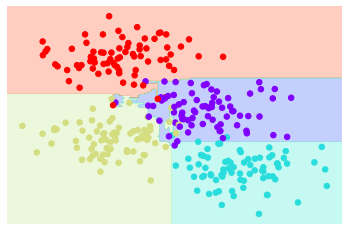

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)


Σε αυτό το παράδειγμα, τα δεδομένα έχουν τυχαιοποιηθεί προσαρμόζοντας κάθε εκτιμητή με ένα τυχαίο υποσύνολο του 80% των σημείων εκπαίδευσης. Στην πράξη, τα δέντρα αποφάσεων τυχαιοποιούνται πιο αποτελεσματικά με τη στοχαστικότητα στον τρόπο επιλογής των διαχωρισμών: με αυτόν τον τρόπο όλα τα δεδομένα συμβάλλουν στην προσαρμογή κάθε φορά, αλλά τα αποτελέσματα της προσαρμογής εξακολουθούν να έχουν την επιθυμητή τυχαιότητα. Για παράδειγμα, κατά τον προσδιορισμό του χαρακτηριστικού στο οποίο θα χωριστεί, το τυχαιοποιημένο δέντρο μπορεί να επιλέξει μεταξύ των κορυφαίων λειτουργιών.

Στο Scikit-Learn, ένα τέτοιο βελτιστοποιημένο σύνολο τυχαιοποιημένων δέντρων αποφάσεων εφαρμόζεται στον εκτιμητή RandomForestClassifier, ο οποίος φροντίζει αυτόματα όλη την τυχαιοποίηση. Το μόνο που χρειάζεται είναι να επιλεγεί ένας αριθμός εκτιμητών ο οποίος και θα ταιριάξει πολύ γρήγορα (παράλληλα, αν θέλετε) στο σύνολο των δέντρων:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: The following kwargs were not used by contour: 'clim'


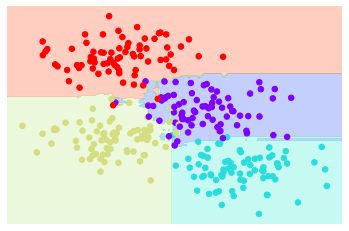

In [8]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

<ul>
<li><b>Ερώτηση 5:</b> Δοκιμάστε να μειώσετε και να αυξήσετε τον αριθμό των εκτιμητών στις παραπάνω περιπτώσεις. Τι παρατηρείτε ως προς την ακρίβεια και το χρόνο εκτέλεσης της μεθόδου Random Forests;</li>
<li><b>Ερώτηση 6:</b> Χρειάζεται η εφαρμογή του pruning στην περίπτωση των Random Forests, όπως στην περίπτωση των Δέντρων Αποφάσεων; Να δικαιολογήσετε την απάντησή σας.</li>
</ul>

# Παλινδρόμηση με Random Forest


Τα Random Forests δεν χρησιμοποιούνται μόνο στο πλαίσιο της ταξινόμησης στοιχείων, αλλά μπορούν επίσης να χρησιμοποιηθούν και σε περίπτωση παλινδρόμησης. Ο εκτιμητής που θα χρησιμοποιηθεί για αυτό είναι το RandomForestRegressor και η σύνταξη είναι παρόμοια με τη περίπτωση της ταξινόμησης.

Έστω ότι έχουμε τα ακόλουθα δεδομένα, που αντλούνται από το συνδυασμό γρήγορης και αργής ταλάντωσης:

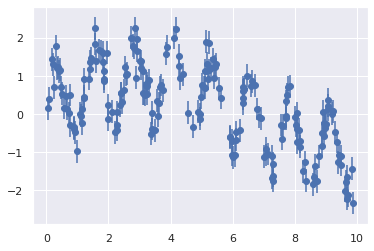

In [9]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');


Χρησιμοποιώντας παλινδρόμηση βασισμένη στα Random Forests, μπορούμε να βρούμε τη καμπύλη βελτιστοποίησης ως εξής:

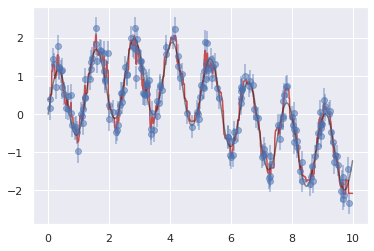

In [10]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Εδώ το αληθινό μοντέλο εμφανίζεται στην γκρι καμπύλη, ενώ το μοντέλο που δημιουργήθηκε με Random Forests εμφανίζεται με την οδοντωτή κόκκινη καμπύλη. Όπως φαίνεται, το μη παραμετρικό μοντέλο βασισμένο σε Random Forests είναι αρκετά ευέλικτο ώστε να χωράει τα δεδομένα πολλαπλών περιόδων, χωρίς να χρειάζεται να προσδιορίσουμε ένα μοντέλο πολλαπλών περιόδων!

# Παράδειγμα: Random Forest για κατηγοριοποίηση ψηφίων

Εισάγουμε τις απαραίτητες βιβλιοθήκες και το σχετικό dataset με τα χειρόγραφα ψηφία

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [12]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

Οπτικοποίηση μερικών ψηφίων

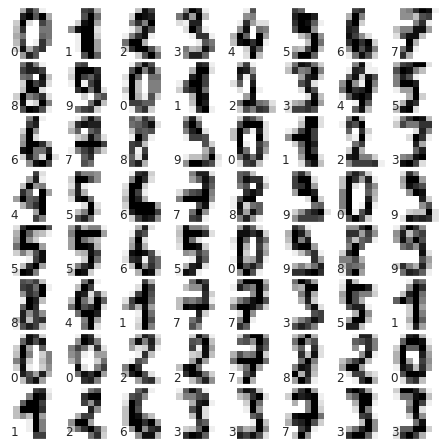

In [13]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

Κατηγοριοποιούμε τα ψηφία με Random Forest

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [15]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.98      0.98        43
           2       0.95      1.00      0.98        42
           3       0.98      0.96      0.97        46
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



Εμφάνιση των λαθών μέσω της [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)

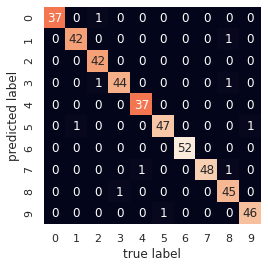

In [16]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

<ul>
<li><b>Ερώτηση 7:</b> Να αναφέρετε για ποιους λόγους απαιτούνται οι μετρικές precision, recall και f1-score πέραν της ακρίβειας (accuracy).</li>
<li><b>Ερώτηση 8:</b> Ποιες άλλες μέθοδοι χρησιμοποιούνται, συνήθως, για την αξιολόγηση μοντέλων μηχανικής μάθησης; Να αναφέρετε μερικές και να αναφέρετε τα πλεονεκτήματά τους (hint: <a href="https://towardsdatascience.com/various-ways-to-evaluate-a-machine-learning-models-performance-230449055f15">Μέθοδοι)</a></li>
</ul>